# Load Libraries and data

In [1]:
library("dplyr")
library("ggplot2")
library("scales")
library("tidyverse")
library('tidyr')
library('ggrepel')
library('ggpubr')
library('stringr')
library('FSA')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 methods overwritten by 'FSA':
  method       from
  confint.boot car 
  hist.boot    car 

## FSA v0.10.0. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('I

In [2]:
# Wait 1 minute for kernel to connect
FCM_raw<- read.csv('std_gate.csv')
LOD_raw<- read.csv('LOD.csv')
rare_raw<- read.csv('rare.csv')


#FCM_new<- read.csv('newmeta.csv')
ATP_raw<- read.csv('ATP.csv')
Study_design<- read.csv('Study_design.csv')
Temp<- read.csv('Temp.csv')
ph<- read.csv('ph.csv')


In [3]:
fig_dir <- 'C:\\Users\\almab\\OneDrive\\Desktop\\Seeding_Figures\\'

# FCM data

In [3]:
#convert cells/110 mL homogenized biofilm sample --> cells/cm2
#convert cells/30mL homogenized media sample --> cells/1 g --> cells/mg

fcm_bf <- FCM_raw %>% filter(Location == 'BF1' |Location == 'BF2' |Location == 'BF3' |Location == 'BF4' |Location == 'BF5'|Location == 'BF6'|Location == 'Blk'  ) %>% 
                  mutate(TCC_density = (TCC_density)*110*20/(15*1.5)) %>% mutate(type="Biofilm") 
fcm_bac <- FCM_raw %>% filter(Location == 'BAC' |Location == 'Blk'  ) %>% 
                  mutate(TCC_density = (TCC_density)*30/(1000)) %>% mutate(type="Media") 
fcm_nbf <- FCM_raw  %>% filter(Location != 'BF1' & Location != 'BF2' & Location != 'BF3' & Location != 'BF4' & Location != 'BF5'& Location != 'BF6' & Location != 'BAC' ) %>% 
mutate(type="Bulk")
FCM <- rbind(fcm_bf,fcm_bac,fcm_nbf)

## Averaging FCM data

In [5]:
# Remove Counting Beads and change names of Rare and column names
FCM_mean  <- FCM %>% filter(Location != "Count") %>% mutate(Location = recode(Location, RAR = 'Rare')) %>% rename(samples_type = Location)

# Change name of BACeff to BFE
Study_design  <- Study_design %>% mutate(samples_type = recode(samples_type, BACEff = 'BFE')) %>% mutate(samples_type = recode(samples_type, ATW = 'Rare')) 



In [6]:
# Merge with metadata csv file
FCM_mean <- merge(Study_design, FCM_mean , by= 'samples_type', all=TRUE)

In [7]:
#geomean and geostd for duplicate reactors
FCM_mean_ARs  <-  FCM_mean %>% filter(Treatment == "Tap" | Treatment == "ATW" |Treatment == "BFE" ) %>% 
select(-Sample) %>% 
group_by(Date,Stain, Treatment, type) %>% 
summarize(geomean = exp(mean(log(TCC_density))), geosd = exp(sd(log(TCC_density)))) %>%
mutate(samples_type='AR') 

#geomean and geostd for feeds
FCM_mean_feeds  <-  FCM_mean %>% filter(Treatment == "Feed" | is.na(Treatment) ) %>% 
select(-Sample) %>% 
group_by(Date,Stain, Treatment, samples_type,type) %>% 
summarize(geomean = exp(mean(log(TCC_density))), geosd = exp(sd(log(TCC_density))))

#geomean and geostd for Media
FCM_mean_media <-  FCM_mean %>% filter(Treatment == "Media"  ) %>% 
select(-Sample) %>% 
group_by(Date,Stain, Treatment, samples_type,type) %>% 
summarize(geomean = exp(mean(log(TCC_density))), geosd = exp(sd(log(TCC_density))))



FCM_new <- rbind(FCM_mean_ARs, FCM_mean_feeds,FCM_mean_media)

`summarise()` has grouped output by 'Date', 'Stain', 'Treatment'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Date', 'Stain', 'Treatment',
'samples_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Date', 'Stain', 'Treatment',
'samples_type'. You can override using the `.groups` argument.


In [8]:
# To use the average LOD Blanks
#data_hline <- data.frame(type = unique(FCM_new$type), Stain = unique(FCM_new$Stain),  
#                         hline = c(T_LOD*110*20/(15*1.5),I_LoD,T_LOD*30/1000, I_LoD*110*20/(15*1.5),T_LOD, I_LoD*30/1000))
 

In [9]:
# To use the average LOD Blanks

#FCM_n <- FCM_new  %>% filter(samples_type != "Blk")  %>% mutate(type = replace_na(type,'BAC Media'))
#FCM_merge <- merge(FCM_n, data_hline, by = c("type", "Stain")) 
#FCM_mean <- FCM_merge %>% group_by(type,Stain) %>% mutate(geomean_blanked = geomean -hline)  


In [10]:
# Subtracting and Removing the Daily Blank
FCM_mean <- FCM_new  %>% group_by(Date,Stain,type) %>% 
                 mutate(geomean_blanked = geomean- geomean[samples_type == "Blk"])  %>%
                       filter(samples_type != "Blk")

In [11]:

FCM_mean$geomean_blanked[FCM_mean$geomean_blanked  <0 ] <- 0


In [12]:
# Convert to date format
FCM_mean$Date <- as.Date(FCM_mean$Date, format = "%Y-%m-%d")

In [13]:
# switch column names around
new <- FCM_mean %>% filter(Treatment == 'Feed' | Treatment == 'Media') 
colnames(new)[colnames(new) %in% c("Treatment", "samples_type")] <- c("samples_type", "Treatment")
old <- FCM_mean %>% filter(Treatment != 'Feed' & Treatment != 'Media') 
FCM_mean <- rbind(new,old)

In [14]:
# Change Labels
FCM_mean  <- FCM_mean %>% mutate(Treatment = recode(Treatment, Rare = 'ATW'))
FCM_mean  <- FCM_mean %>% rename('Sample_Type' = samples_type)
FCM_mean <- FCM_mean %>% mutate(type = recode(type, Media = 'BAC Media'))

In [15]:
FCM_mean$type <- factor(FCM_mean$type, levels = c('Bulk', 'Biofilm', 'BAC Media'))

In [16]:
FCM_mean_nob <- FCM_mean %>% filter(Sample_Type != 'Feed' | Treatment != 'BFE' | Date>as.Date('2022-11-14')) %>% filter(type != 'BAC Media')

In [17]:
#FCM_mean_nob %>% filter(Stain == 'SGPI', Date== '2022-12-16', Treatment== 'ATW', Sample_Type=='Feed')
#FCM_mean_nob %>% filter(Stain == 'SGPI', Date== '2022-12-30', Treatment== 'ATW', Sample_Type=='AR')

In [18]:
FCM_mean_nob$type <- factor(FCM_mean_nob$type, levels = c('Bulk', 'Biofilm'))

In [19]:
FCM_mean_nob <- FCM_mean_nob %>% mutate(Treatment = recode(Treatment, BFE = 'Seeded ATW')) %>% mutate(Treatment = recode(Treatment, ATW = 'Unseeded ATW'))  %>% mutate(Treatment = recode(Treatment, Tap = 'SW'))

In [20]:
FCM_mean_nob$Treatment <- factor(FCM_mean_nob$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))


Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


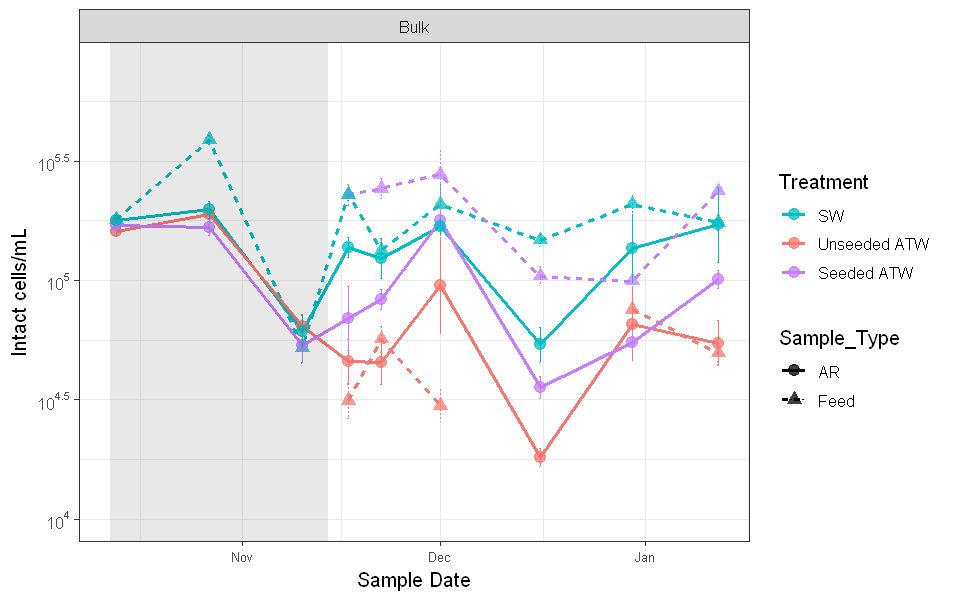

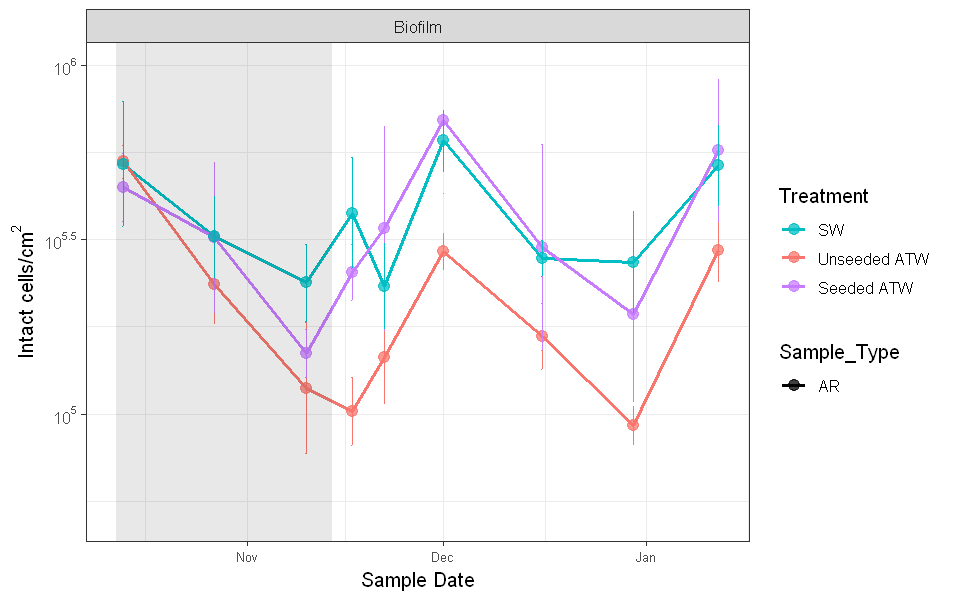

In [160]:
options(repr.plot.width=8, repr.plot.height=5)

FCM_mean_bulk <- FCM_mean_nob  %>% filter(Stain == 'SGPI', type== 'Bulk')
FCM_mean_bf <- FCM_mean_nob  %>% filter(Stain == 'SGPI', type== 'Biofilm')


plot_icc_bulk <- ggplot(FCM_mean_bulk, 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 scale_shape_manual(values = c(19,17)) +
 geom_line(size=1)+
 geom_point(size=3, alpha =0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y="Intact cells/mL") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(1E4, 8E5),  labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline(aes(yintercept = I_LoD), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8))

plot_icc_bulk
                                     
                                     
plot_icc_bf <- ggplot(FCM_mean_bf, 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_shape_manual(values = c(19,17)) +
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha =0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y = expression("Intact cells/cm"^2)) + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(5E4, 1E6), labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline( aes(yintercept = I_LoD*110*20/(15*1.5)), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type', nrow=2, scales = "free")+ 
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8)) 

plot_icc_bf                                     

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


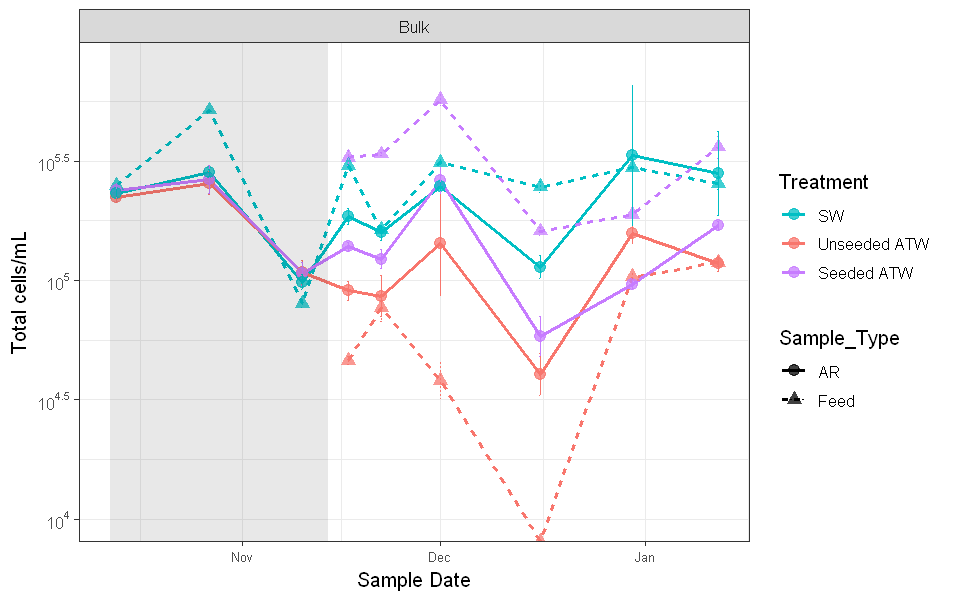

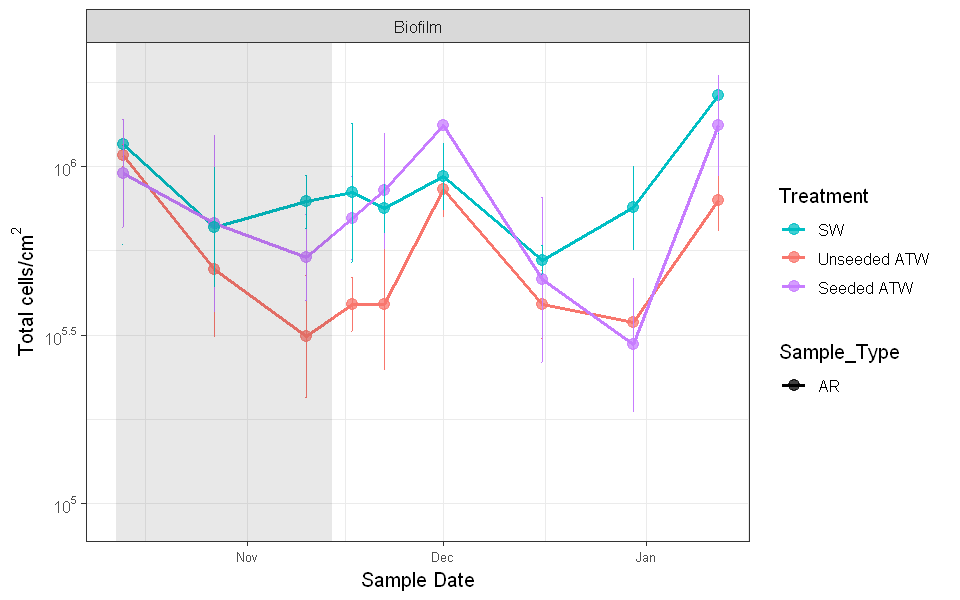

In [161]:
options(repr.plot.width=8, repr.plot.height=5)

FCM_mean_bulk <- FCM_mean_nob  %>% filter(Stain == 'SG', type== 'Bulk')
FCM_mean_bf <- FCM_mean_nob  %>% filter(Stain == 'SG', type== 'Biofilm')


plot_tcc_bulk <- ggplot(FCM_mean_bulk, 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 scale_shape_manual(values = c(19,17)) +
 geom_line(size=1)+
 geom_point(size=3, alpha =0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y="Total cells/mL") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(1E4, 8E5),  labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline(aes(yintercept = I_LoD), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8))

plot_tcc_bulk
                                     
                                     
plot_tcc_bf <- ggplot(FCM_mean_bf, 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_shape_manual(values = c(19,17)) +
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha =0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y = expression("Total cells/cm"^2)) + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(9E4, 2E6), labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline( aes(yintercept = I_LoD*110*20/(15*1.5)), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type', nrow=2, scales = "free")+ 
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8)) 

plot_tcc_bf                                     

In [162]:
FCM_mean_wb <- FCM_mean %>% filter(Sample_Type != 'AR') %>% 
filter( Treatment != 'ATW' | Date>as.Date('2022-11-14')) %>%
filter( Treatment != 'Tap' | Date<as.Date('2022-11-14')) 

In [163]:
FCM_mean_bfe <- FCM_mean_wb %>% filter( Treatment == 'BFE') %>% mutate(Sample_Type = recode(Sample_Type, Feed = 'Column Effluent'))
FCM_mean_nobfe <- FCM_mean_wb %>% filter( Treatment != 'BFE')
FCM_mean_wb <- rbind(FCM_mean_bfe, FCM_mean_nobfe)
FCM_mean_wb$Sample_Type <- factor(FCM_mean_wb$Sample_Type, levels = c('Media','Feed', 'Column Effluent'))

In [164]:
FCM_mean_wb <- FCM_mean_wb %>% mutate(Treatment = recode(Treatment, BFE = 'Column Effluent')) %>% mutate(Treatment = recode(Treatment, ATW = 'Unseeded ATW')) %>% mutate(Treatment = recode(Treatment, Tap = 'SW'))

In [165]:
FCM_mean_wb$Treatment <- factor(FCM_mean_wb$Treatment , levels=c('BAC','SW', 'Unseeded ATW', 'Column Effluent'))


Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


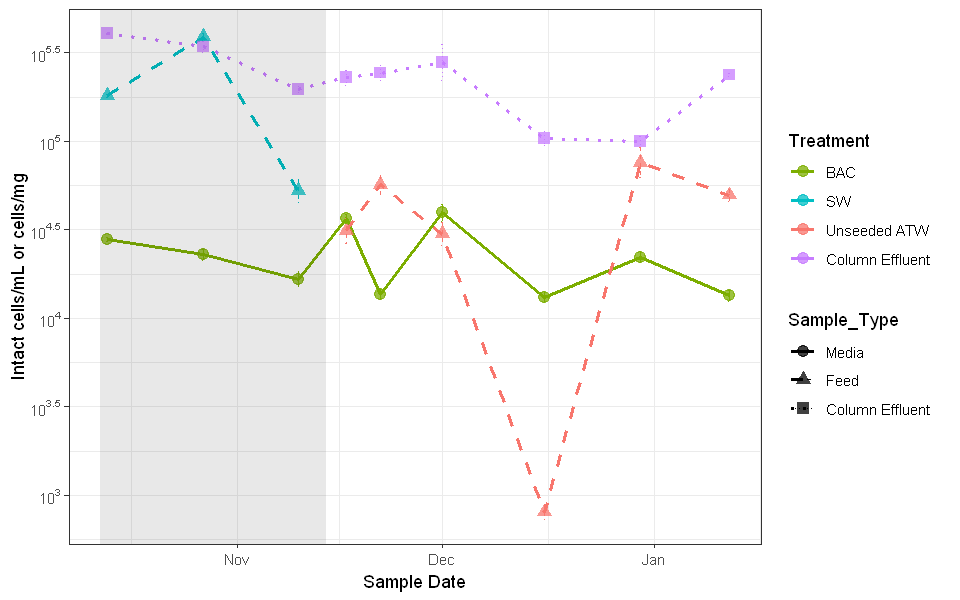

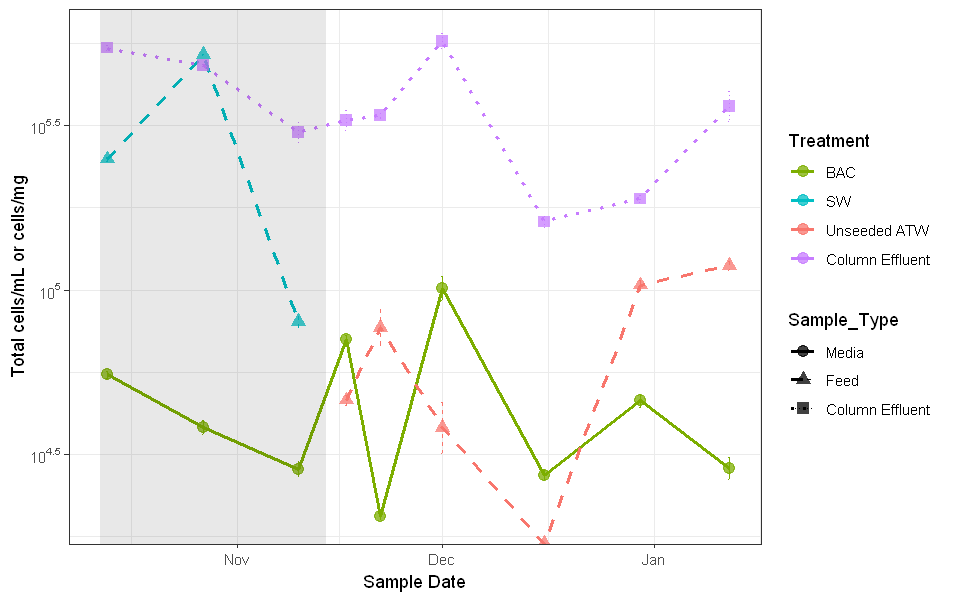

In [166]:
options(repr.plot.width=8, repr.plot.height=5)

plot_icc_bac <- ggplot(FCM_mean_wb  %>% filter(Stain == 'SGPI'), 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_linetype_manual(values = c(1,2,3)) +
 scale_shape_manual(values = c(19,17,15)) +
 scale_color_manual(values = c("#7CAE00", "#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+    
 geom_point(size=3, alpha=0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y="Intact cells/mL or cells/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 #facet_wrap('type', nrow=2, scales = "free")+
 theme_bw(base_size = 11) 

plot_icc_bac
                                     
                                     
plot_tcc_bac <- ggplot(FCM_mean_wb  %>% filter(Stain == 'SG'), 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_linetype_manual(values = c(1,2,3)) +
 scale_shape_manual(values = c(19,17,15)) +
 scale_color_manual(values = c("#7CAE00", "#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+    
 geom_point(size=3, alpha=0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y="Total cells/mL or cells/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 #facet_wrap('type', nrow=2, scales = "free")+
 theme_bw(base_size = 11) 

plot_tcc_bac                                     

## All FCM data

In [4]:

# Adding means and sd 
FCM_std <- FCM %>% filter(Location != "Count") %>% 
group_by(Date,Stain, Location, type) %>% 
summarize(geomean = exp(mean(log(TCC_density))), geosd = exp(sd(log(TCC_density))))


`summarise()` has grouped output by 'Date', 'Stain', 'Location'. You can
override using the `.groups` argument.


In [5]:
# Subtracting and Removing the Blank
FCM_std<- FCM_std %>% group_by(Date,Stain,type) %>% mutate(geomean_blanked = geomean- geomean[Location == "Blk"])  %>%
                 filter(Location != "Blk")

In [6]:
FCM_std$geomean_blanked[FCM_std$geomean_blanked  <0 ] <- 0


In [7]:
# Convert to date format
FCM_std$Date <- as.Date(FCM_std$Date, format = "%Y-%m-%d")

In [8]:
FCM_std  <- FCM_std %>% mutate(Location = recode(Location, RAR = 'ATW') )
FCM_std  <- FCM_std %>% rename('samples_type' = Location)

In [9]:
#FCM_std$samples_type
Study_design <- Study_design %>% mutate(samples_type = recode(samples_type, Rare = 'ATW')) 

In [10]:
# Study design df
FCM_std <- merge(Study_design, FCM_std, by= 'samples_type', all=TRUE)

In [11]:
# switch column names around
new <- FCM_std %>% filter(Treatment == 'Feed' | Treatment == 'Media') 
colnames(new)[colnames(new) %in% c("samples_type", "Treatment")] <- c("Treatment", "samples_type")
old <- FCM_std %>% filter(Treatment != 'Feed' & Treatment != 'Media') %>% mutate(samples_type = 'AR')
FCM_std <- rbind(new,old)

In [12]:
FCM_std <- FCM_std %>% mutate(type = recode(type, Media = 'BAC Media'))
FCM_std$type <- factor(FCM_std$type, levels = c('Bulk', 'Biofilm', 'BAC Media'))

In [14]:
write.csv(FCM_std, file = 'C:/Users/almab/OneDrive/Desktop/Seeding_Code_Update/FCM_std_new.csv', row.names=FALSE)

In [101]:
FCM_std_nob <- FCM_std %>% filter(samples_type != 'Feed' | Treatment != 'BFE' | Date>as.Date('2022-11-14')) %>% filter(type != 'BAC Media')

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


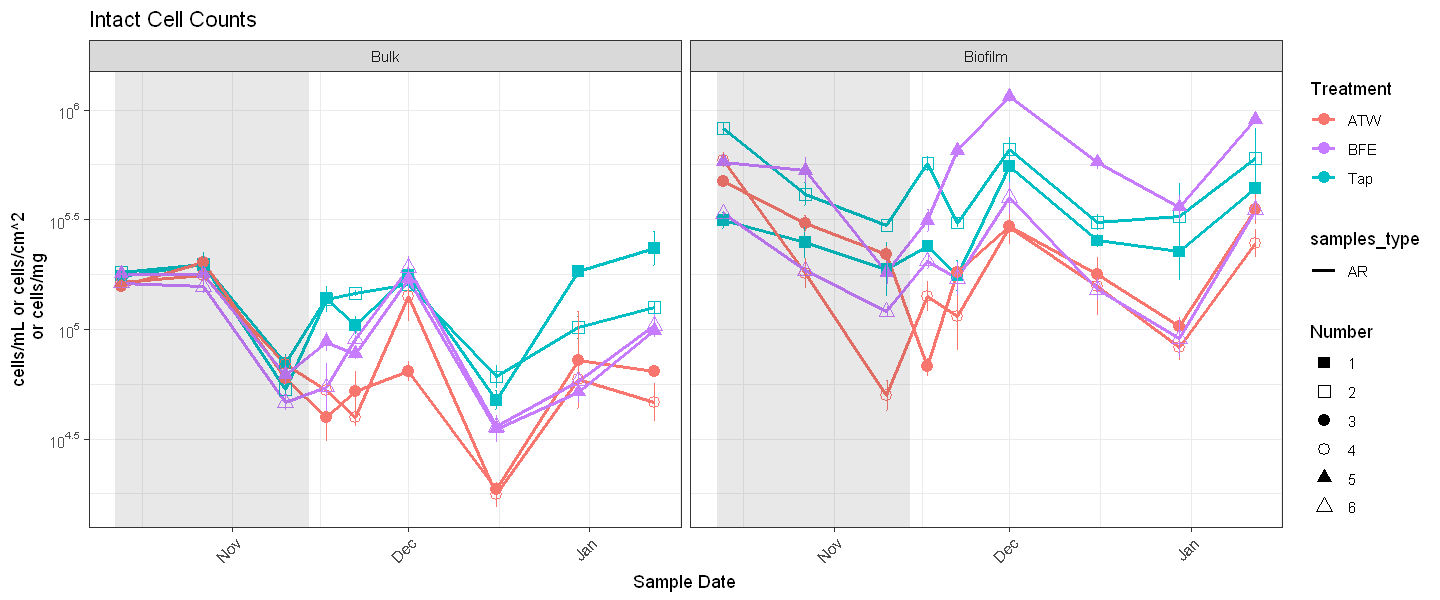

In [133]:
options(repr.plot.width=12, repr.plot.height=5)

plot_icc_ind <- ggplot(FCM_std_nob  %>% filter(Stain == 'SGPI', samples_type != 'Feed'), 
                   aes(x=Date, y=geomean_blanked, group= Number, color=Treatment, shape = Number, linetype=samples_type))+  
 scale_shape_manual(values = c(15,0,19,1,17,2)) + 
 scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4")) +
 geom_line(size=1)+
 geom_point(size=3)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Intact Cell Counts", x="Sample Date", y="cells/mL or cells/cm^2\n or cells/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) + 
#scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 facet_wrap('type', scales = 'fixed')+
 theme_bw() +
 theme(axis.text.x = element_text(angle=45, hjust=1))

plot_icc_ind



Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


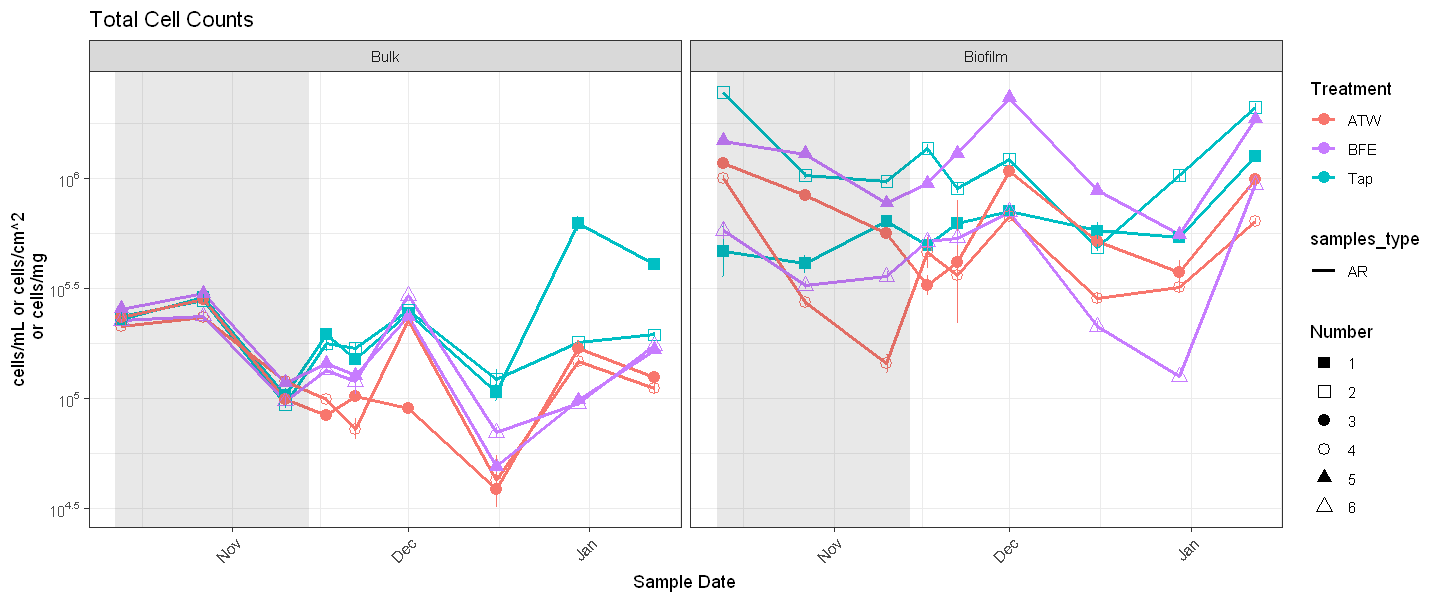

In [134]:
options(repr.plot.width=12, repr.plot.height=5)

plot_tcc_ind <- ggplot(FCM_std_nob  %>% filter(Stain == 'SG', samples_type != 'Feed'), 
                   aes(x=Date, y=geomean_blanked, group= Number, color=Treatment, shape = Number, linetype=samples_type))+  
 scale_shape_manual(values = c(15,0,19,1,17,2)) + 
 scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4")) +
 geom_line(size=1)+
 geom_point(size=3)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Total Cell Counts", x="Sample Date", y="cells/mL or cells/cm^2\n or cells/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) + 
#scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 facet_wrap('type', scales = 'fixed')+
 theme_bw() +
 theme(axis.text.x = element_text(angle=45, hjust=1))

plot_tcc_ind



# ATP data

In [4]:
# convert data columns to numeric
columns <- c('ATPt1_pgmL', 'ATPt2_pgmL', 'ATPt3_pgmL', 'ATPe1_pgmL', 'ATPe2_pgmL', 'ATPe3_pgmL')
ATP <- ATP_raw %>% mutate_at(columns, as.numeric)

# Remove anthracite samples
ATP <- ATP %>% filter(samples_type != 'Biofilm ' & samples_type != 'Source' & samples_type != 'Bulk Water') 

In [5]:
# total and e into separate df. 
ATP_t <- ATP %>% select('sample_id','sample_date','samples_type','ATPt1_pgmL', 'ATPt2_pgmL', 'ATPt3_pgmL')
ATP_e <- ATP %>% select('sample_id','sample_date','samples_type','ATPe1_pgmL', 'ATPe2_pgmL', 'ATPe3_pgmL')

#Converted to wide long format.
ATP_t <- ATP_t %>% pivot_longer(cols= c('ATPt1_pgmL', 'ATPt2_pgmL', 'ATPt3_pgmL'),names_to = "names", values_to = "conc")
ATP_e <- ATP_e %>% pivot_longer(cols= c('ATPe1_pgmL', 'ATPe2_pgmL', 'ATPe3_pgmL'),names_to = "names", values_to = "conc")

#Add column name
ATP_t <- ATP_t %>% mutate(measurement = 'Total ATP')
ATP_e <- ATP_e %>% mutate(measurement = 'EC ATP')

# combine together
df_ATP <- rbind(ATP_t,ATP_e)

In [6]:
# any negative or na's are 0
df_ATP$conc[df_ATP$conc <0] <- 0 
df_ATP$conc[is.na(df_ATP$conc) ] <- 0

In [7]:
#convert pg ATP/110 mL homogenized biofilm sample --> pg ATP/cm2
#convert pg ATP/30mL homogenized media sample --> pg ATP/1 g --> pg ATP/mg

atp_bf <- df_ATP %>% filter(samples_type == 'BF1' |samples_type == 'BF2' |samples_type == 'BF3' |samples_type == 'BF4' |samples_type == 'BF5'|samples_type == 'BF6'|samples_type == 'Blank'  ) %>% 
                  mutate(conc = (conc)*110*20/(15*1.5*1000)) %>% mutate(type="Biofilm") 
atp_bac <- df_ATP %>% filter(samples_type == 'BAC' |samples_type == 'Blank'  ) %>% 
                  mutate(conc = (conc)*30/(1000)) %>% mutate(type="Media") 
atp_nbf <- df_ATP  %>% filter(samples_type != 'BF1' & samples_type != 'BF2' & samples_type != 'BF3' & samples_type != 'BF4' & samples_type != 'BF5'& samples_type != 'BF6' & samples_type != 'BAC' ) %>% 
mutate(type="Bulk")
df_ATP <- rbind(atp_bf,atp_bac,atp_nbf)
df_ATP  <- df_ATP %>% mutate(samples_type = recode(samples_type, BACEff = 'BFE')) 


## Averaging ATP data

In [8]:
# Averaging Replicates Together
ATP_mean <- merge(Study_design, df_ATP, by= 'samples_type', all=TRUE)


In [9]:
# Turn EC ATP into IC ATP
ATP_mean$conc[ATP_mean$measurement == 'Total ATP' & is.na(ATP_mean$conc) ] <- 0
ATP_mean$conc[ATP_mean$measurement == 'EC ATP' & is.na(ATP_mean$conc) ] <- 0
#ATP_mean$geosd[ATP_mean$measurement == 'Total ATP' & is.na(ATP_mean$geosd) ] <- 1.000001
#ATP_mean$geosd[ATP_mean$measurement == 'EC ATP' & is.na(ATP_mean$geosd) ] <- 1.000001


#change to conc if before averaging

ATP_Tot <- ATP_mean %>% filter(measurement=='Total ATP')
#ATP_EC <- ATP_mean  %>% filter(measurement=='EC ATP')

#group_by(sample_date,Treatment,samples_type,type) %>% 
#mutate(conc_IC = conc[measurement == "Total ATP"]- conc[measurement == "EC ATP"]) %>% 
#mutate(geosd_IC = exp(sqrt(log(geosd[measurement == "Total ATP"])^2+ log(geosd[measurement == "EC ATP"])^2 ))) %>% 
#filter(measurement == 'EC ATP') %>% 
#select(-'geomean') %>% rename(geomean = geomean_IC) %>% 
#select(-'geosd') %>% rename(geosd = geosd_IC) %>% 
#mutate(measurement = 'IC ATP')
#ATP_mean<- rbind(ATP_Tot,ATP_IC)

In [10]:
# Total 
ATP_mean_ARs_ep  <-  ATP_Tot %>% filter(Treatment == "Tap" | Treatment == "ATW" |Treatment == "BFE" ) %>% 
select(-names) %>% 
group_by(sample_date, measurement, Treatment, type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc)))) %>%
mutate(samples_type='AR') 


#geomean and geostd for feeds
ATP_mean_feeds_ep  <-  ATP_Tot  %>% filter(Treatment == "Feed" | is.na(Treatment) ) %>% 
select(-names) %>% 
group_by(sample_date, measurement, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc)))) 

ATP_mean_media_ep  <-  ATP_Tot  %>% filter(Treatment == "Media"  ) %>% 
select(-names) %>% 
group_by(sample_date, measurement, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc))))

ATP_Tot <- rbind(ATP_mean_ARs_ep, ATP_mean_feeds_ep,ATP_mean_media_ep)

`summarise()` has grouped output by 'sample_date', 'measurement', 'Treatment'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'measurement', 'Treatment',
'samples_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'measurement', 'Treatment',
'samples_type'. You can override using the `.groups` argument.


In [11]:
# IC 
ATP_mean_ARs_ic  <-  ATP_mean %>% filter(Treatment == "Tap" | Treatment == "ATW" |Treatment == "BFE" ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, type) %>% 
summarize(geomean = exp(mean(log(conc[measurement == "Total ATP"]- conc[measurement == "EC ATP"]))), geosd = exp(sd(log(conc[measurement == "Total ATP"] - conc[measurement == "EC ATP"])))) %>%
mutate(samples_type='AR')  %>% 
mutate(measurement = 'IC ATP')


#geomean and geostd for feeds
ATP_mean_feeds_ic  <-  ATP_mean  %>% filter(Treatment == "Feed" | is.na(Treatment) ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc[measurement == "Total ATP"] - conc[measurement == "EC ATP"]))), geosd = exp(sd(log(conc[measurement == "Total ATP"] - conc[measurement == "EC ATP"])))) %>% 
mutate(measurement = 'IC ATP')

ATP_mean_media_ic  <-  ATP_mean  %>% filter(Treatment == "Media"  ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc[measurement == "Total ATP"] - conc[measurement == "EC ATP"]))), geosd = exp(sd(log(conc[measurement == "Total ATP"] - conc[measurement == "EC ATP"])))) %>% 
 mutate(measurement = 'IC ATP')

ATP_IC <- rbind(ATP_mean_ARs_ic, ATP_mean_feeds_ic,ATP_mean_media_ic)

Warning message:
"There were 2 warnings in `summarize()`.
The first warning was:
ℹ In argument: `geomean = exp(...)`.
ℹ In group 15: `sample_date = "10/26/2022"`, `Treatment = "BFE"`, `type =
  "Biofilm"`.
Caused by warning in `log()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'sample_date', 'Treatment'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'Treatment', 'samples_type'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'Treatment', 'samples_type'.
You can override using the `.groups` argument.


In [12]:
ATP_IC$geomean[is.na(ATP_IC$geomean) ] <- 0
ATP_IC$geosd[is.na(ATP_IC$geosd) ] <- 0

ATP_mean<- rbind(ATP_Tot,ATP_IC)

In [13]:
results <- ATP_mean %>%
  # Split Total and Extracellular ATP values
  group_by(sample_id, sample_date,measurement, samples_type,Treatment, type) %>%
  filter(measurement == "Total ATP") %>%
  summarize(Total = list(conc)) %>%
  inner_join(
    ATP_mean %>% 
      group_by(sample_id,sample_date,measurement, samples_type,Treatment, type) %>% 
      filter(measurement == "EC ATP") %>% 
      summarize(Extracellular = list(conc)),
    by = "sample_id"
  ) %>%
  # Generate all pairwise combinations
  mutate(Pairwise = map2(Total, Extracellular, ~ expand.grid(.x, .y))) %>%
  unnest(Pairwise) %>%
  rename(Total_ATP = Var1, Extracellular_ATP = Var2) %>%
  # Calculate intracellular ATP
  mutate(Intracellular_ATP = Total_ATP - Extracellular_ATP)
 

ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `sample_id` is not found.


In [28]:
results$Intracellular_ATP[results$Intracellular_ATP <0] <- 0 

In [29]:
#geomean and geostd for duplicate reactors
ATP_mean_ARs  <-  results %>% filter(Treatment.x == "Tap" | Treatment.x == "ATW" |Treatment.x == "BFE" ) %>% 
#select(-names) %>% 
group_by(sample_date.x,measurement.x, Treatment.x, type.x) %>% 
summarize(geomean = exp(mean(log(Intracellular_ATP))), geosd = exp(sd(log(Intracellular_ATP)))) %>%
mutate(samples_type.x='AR') %>% mutate(measurement.x='IC ATP') %>%
rename(sample_date = sample_date.x) %>% rename(measurement = measurement.x) %>% rename(Treatment = Treatment.x) %>% rename(type = type.x) %>% rename(samples_type = samples_type.x) 


#geomean and geostd for feeds
ATP_mean_feeds  <-  results %>% filter(Treatment.x == "Feed" | is.na(Treatment.x) ) %>% 
#select(-names) %>% 
group_by(sample_date.x,measurement.x, Treatment.x, samples_type.x , type.x) %>% 
summarize(geomean = exp(mean(log(Intracellular_ATP))), geosd = exp(sd(log(Intracellular_ATP)))) %>%
mutate(measurement.x='IC ATP') %>%
rename(sample_date = sample_date.x) %>% rename(measurement = measurement.x) %>% rename(Treatment = Treatment.x) %>% rename(type = type.x) %>% rename(samples_type = samples_type.x) 


ATP_mean_media  <-  results %>% filter(Treatment.x == "Media"  ) %>% 
#select(-names) %>% 
group_by(sample_date.x,measurement.x, Treatment.x, samples_type.x , type.x) %>% 
summarize(geomean = exp(mean(log(Intracellular_ATP))), geosd = exp(sd(log(Intracellular_ATP)))) %>%
mutate(measurement.x='IC ATP') %>%
rename(sample_date = sample_date.x) %>% rename(measurement = measurement.x) %>% rename(Treatment = Treatment.x) %>% rename(type = type.x) %>% rename(samples_type = samples_type.x) 



# Total 
ATP_mean_ARs_t  <-  ATP_mean %>% filter(measurement == 'Total ATP') %>% filter(Treatment == "Tap" | Treatment == "ATW" |Treatment == "BFE" ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc)))) %>%
mutate(samples_type='AR')  %>% mutate(measurement='Total ATP') 


#geomean and geostd for feeds
ATP_mean_feeds_t  <-  ATP_mean %>% filter(measurement == 'Total ATP') %>% filter(Treatment == "Feed" | is.na(Treatment) ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc)))) %>% 
mutate(measurement='Total ATP') 

ATP_mean_media_t  <-  ATP_mean %>% filter(measurement == 'Total ATP') %>% filter(Treatment == "Media"  ) %>% 
select(-names) %>% 
group_by(sample_date, Treatment, samples_type , type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc))))%>% 
mutate(measurement='Total ATP') 


# biofilm <- c("BF1","BF2","BF3","BF4","BF5","BF6","BAC", "Blank")
# bulk <- c("AR1","AR2","AR3","AR4","AR5","AR6","Tap","Rare","BACEff", "Blank")
# df_bulk <- ATP_mean_feeds  %>% filter(samples_type %in% bulk) %>% mutate(type = 'Bulk') 
# df_biofilm <- ATP_mean_feeds  %>% filter(samples_type %in% biofilm) %>% mutate(type = 'Biofilm')
# ATP_mean_feeds  <- rbind(df_bulk, df_biofilm)

#ATP_mean <- rbind(ATP_mean_ARs, ATP_mean_feeds,ATP_mean_media)

`summarise()` has grouped output by 'sample_date.x', 'measurement.x',
'Treatment.x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date.x', 'measurement.x',
'Treatment.x', 'samples_type.x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date.x', 'measurement.x',
'Treatment.x', 'samples_type.x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'Treatment'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'Treatment', 'samples_type'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_date', 'Treatment', 'samples_type'.
You can override using the `.groups` argument.


In [30]:
ATP_mean<- rbind(ATP_mean_ARs, ATP_mean_feeds,ATP_mean_media,ATP_mean_ARs_t, ATP_mean_feeds_t,ATP_mean_media_t)

In [31]:
ATP_mean$geosd[is.na(ATP_mean$geosd) ] <- 0


In [32]:
ATP_mean <- ATP_mean %>% mutate(samples_type = recode(samples_type, Rare = 'ATW')) 

In [33]:
# Subtracting and Removing the Blank
ATP_mean <- ATP_mean  %>% group_by(sample_date,measurement,type) %>% 
                 mutate(geomean_blanked = geomean- geomean[samples_type == "Blank"])  %>%
                       filter(samples_type != "Blank")

In [34]:
tot_atp <- ATP_mean %>% filter(measurement == "Total ATP") 
log_sd_total <- log(tot_atp$geosd )  # Add small constant to total SD
range(log_sd_total)
ec_atp <- ATP_mean %>% filter(measurement == "IC ATP") 
log_sd_ec <- log(ec_atp$geosd )  # Add small constant to total SD
range(log_sd_ec)

[1] 0.009293398 1.931140627

[1]     -Inf 1.813991

In [35]:
# Convert to date format
ATP_mean$sample_date <- as.Date(ATP_mean$sample_date, format = "%m/%d/%Y")

In [36]:
# Remove 1st contaminated day
ATP_mean   <- ATP_mean  %>% filter(sample_date != '2022-09-28')

In [37]:
# switch column names around
new <- ATP_mean %>% filter(Treatment == 'Feed' | Treatment == 'Media') 
colnames(new)[colnames(new) %in% c("Treatment", "samples_type")] <- c("samples_type", "Treatment")
old <- ATP_mean %>% filter(Treatment != 'Feed' & Treatment != 'Media') 
ATP_mean <- rbind(new,old)

In [38]:
# Change Labels
ATP_mean  <- ATP_mean %>% rename('Sample_Type' = samples_type)
ATP_mean <- ATP_mean %>% mutate(type = recode(type, Media = 'BAC Media'))

In [39]:
ATP_mean$type <- factor(ATP_mean$type, levels = c('Bulk', 'Biofilm', 'BAC Media'))

In [40]:
ATP_mean_nob <- ATP_mean %>% filter(Sample_Type != 'Feed' | Treatment != 'BFE' | sample_date>as.Date('2022-11-14')) %>% filter(type != 'BAC Media')

In [41]:
ATP_mean_nob <- ATP_mean_nob %>% mutate(Treatment = recode(Treatment, BFE = 'Seeded ATW')) %>% mutate(Treatment = recode(Treatment, ATW = 'Unseeded ATW')) %>% mutate(Treatment = recode(Treatment, Tap = 'SW'))

In [42]:
ATP_mean_nob$Treatment <- factor(ATP_mean_nob$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


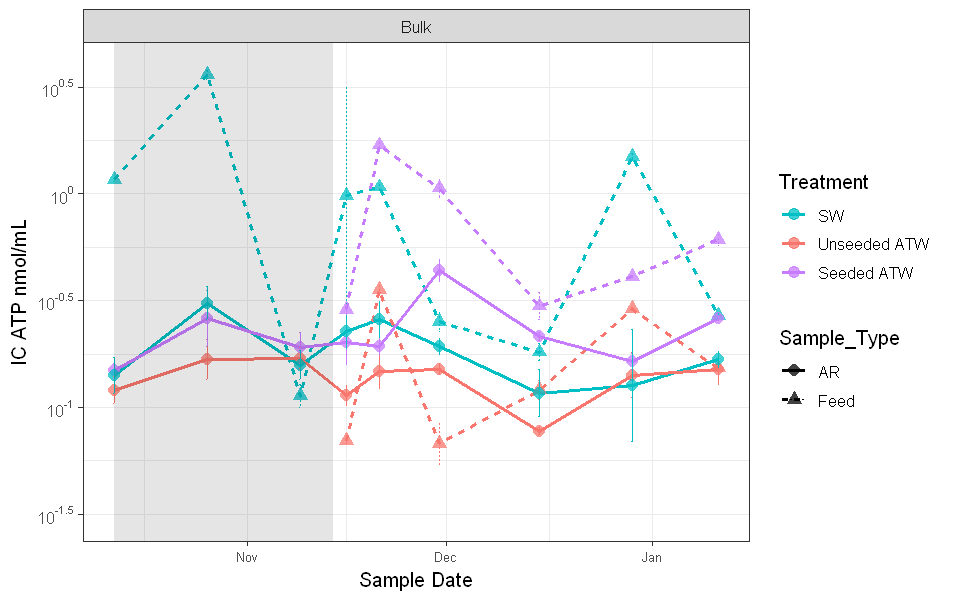

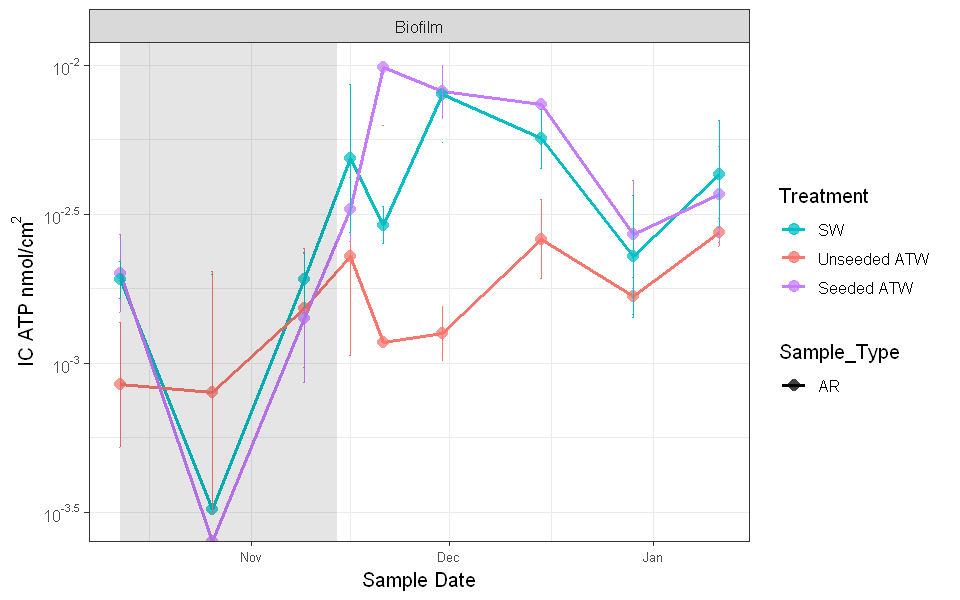

In [43]:
options(repr.plot.width=8, repr.plot.height=5)
plot_iatp_bulk <- ggplot(ATP_mean_nob  %>% filter(measurement == 'IC ATP', type=='Bulk'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_line(method= "loess",  se=FALSE, span=0.66, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y="IC ATP nmol/mL") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(3E-2, 4E0),  labels = trans_format("log10", math_format(10^.x))) + 
 #scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray1") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8)) 


plot_iatp_bulk
                                     
                                     
plot_iatp_bf <- ggplot(ATP_mean_nob  %>% filter(measurement == 'IC ATP', type=='Biofilm'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_line(method= "loess",  se=FALSE, span=0.66, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y = expression("IC ATP nmol/cm"^2)) + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-4, 1E-2),   labels = trans_format("log10", math_format(10^.x))) + 
 #scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray1") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8))         
                                     
plot_iatp_bf                                     

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


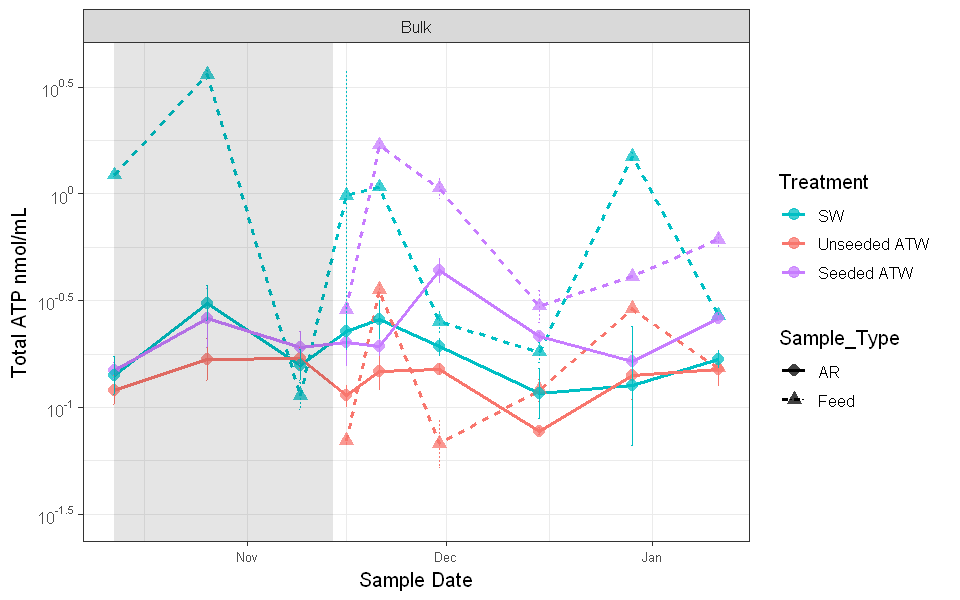

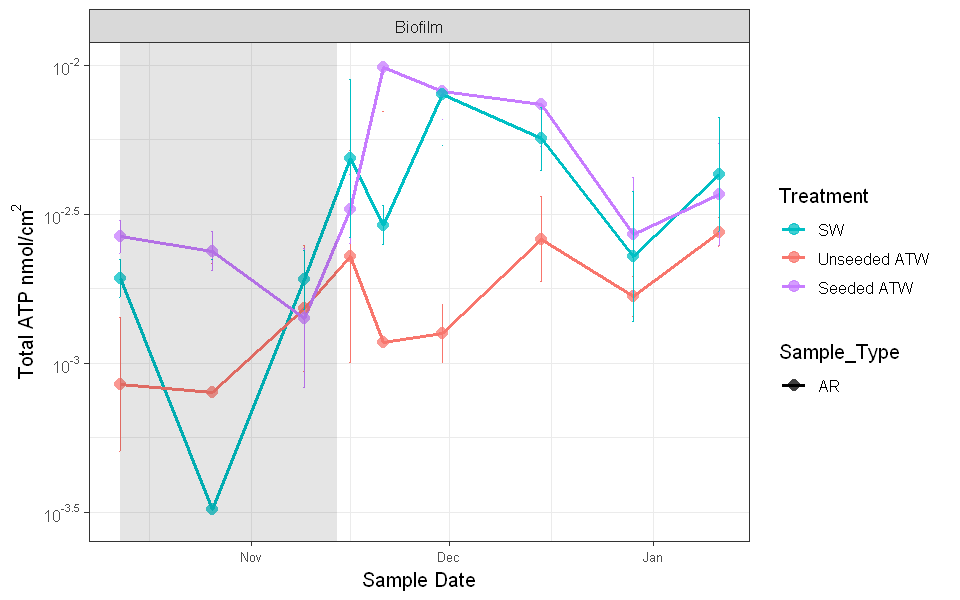

In [219]:
options(repr.plot.width=8, repr.plot.height=5)
plot_tatp_bulk <- ggplot(ATP_mean_nob  %>% filter(measurement == 'Total ATP', type=='Bulk'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_line(method= "loess",  se=FALSE, span=0.66, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y="Total ATP nmol/mL") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  limits=c(3E-2, 4E0),  labels = trans_format("log10", math_format(10^.x))) + 
 #scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray1") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8)) 


plot_tatp_bulk
                                     
                                     
plot_tatp_bf <- ggplot(ATP_mean_nob  %>% filter(measurement == 'Total ATP', type=='Biofilm'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_line(method= "loess",  se=FALSE, span=0.66, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y = expression("Total ATP nmol/cm"^2)) + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-4, 1E-2),   labels = trans_format("log10", math_format(10^.x))) + 
 #scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray1") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type',scales = "free")+
 theme_bw(base_size = 12 )+
 theme(axis.text.x = element_text( size=8))         
                                     
plot_tatp_bf                                     

In [203]:
ATP_mean_wb <- ATP_mean %>% filter(Sample_Type != 'AR') %>% 
filter( Treatment != 'ATW' | sample_date>as.Date('2022-11-14')) %>%
filter( Treatment != 'Tap' | sample_date<as.Date('2022-11-14')) 

In [204]:
ATP_mean_bfe <- ATP_mean_wb %>% filter( Treatment == 'BFE') %>% mutate(Sample_Type = recode(Sample_Type, Feed = 'Column Effluent'))
ATP_mean_nobfe <- ATP_mean_wb %>% filter( Treatment != 'BFE')
ATP_mean_wb <- rbind(ATP_mean_bfe, ATP_mean_nobfe)
ATP_mean_wb$Sample_Type <- factor(ATP_mean_wb$Sample_Type, levels = c( 'Media','Feed','Column Effluent'))

In [205]:
ATP_mean_wb <- ATP_mean_wb %>% mutate(Treatment = recode(Treatment, BFE = 'Column Effluent')) %>% mutate(Treatment = recode(Treatment, ATW = 'Unseeded ATW')) %>% mutate(Treatment = recode(Treatment, Tap = 'SW'))

In [206]:
ATP_mean_wb$Treatment <- factor(ATP_mean_wb$Treatment , levels=c('BAC','SW', 'Unseeded ATW', 'Column Effluent'))


Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


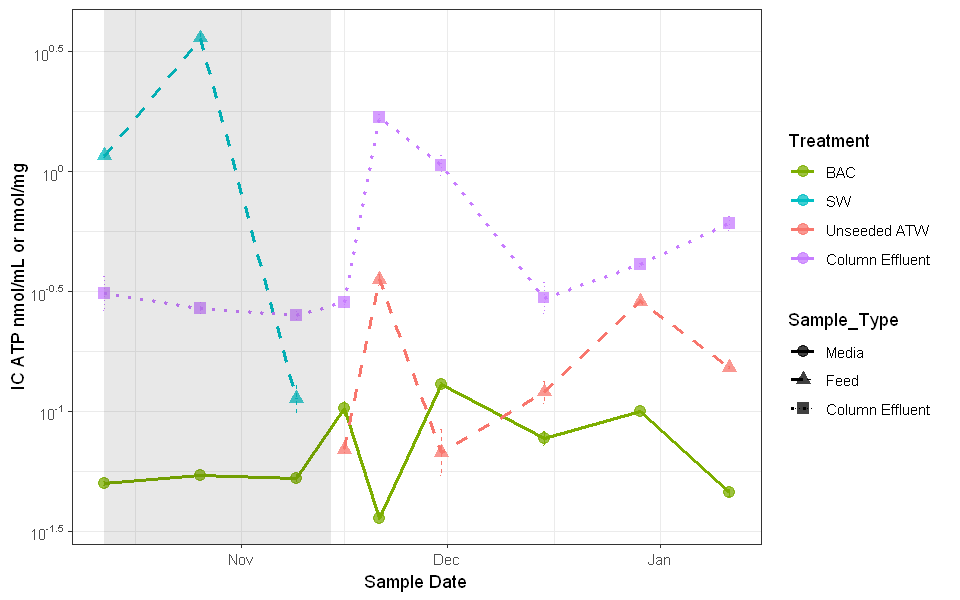

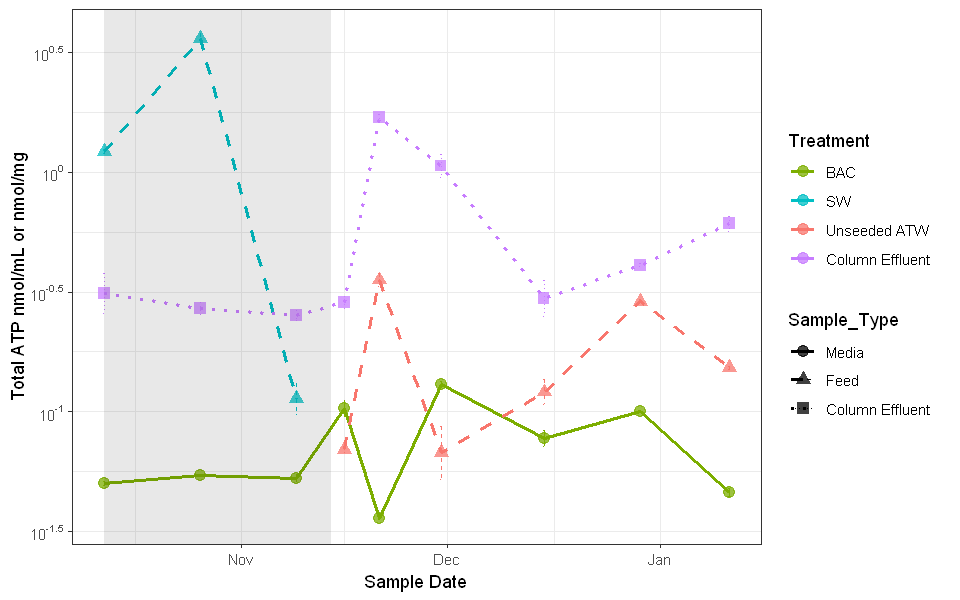

In [207]:
options(repr.plot.width=8, repr.plot.height=5)

plot_iatp_bac <- ggplot(ATP_mean_wb  %>% filter(measurement == 'IC ATP'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_linetype_manual(values = c(1,2,3)) +
 scale_shape_manual(values = c(19,17,15)) +
 scale_color_manual(values = c("#7CAE00", "#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs(x="Sample Date", y="IC ATP nmol/mL or nmol/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 #facet_wrap('type', nrow=2, scales = "free")+
 theme_bw(base_size = 11) 

plot_iatp_bac
                                     
plot_tatp_bac <- ggplot(ATP_mean_wb  %>% filter(measurement == 'Total ATP'), 
                   aes(x=sample_date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_linetype_manual(values = c(1,2,3)) +
 scale_shape_manual(values = c(19,17,15)) +
 scale_color_manual(values = c("#7CAE00", "#00BFC4",'#F8766D',"#C77CFF")) +
 geom_line(size=1)+
 geom_point(size=3, alpha=0.75)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 labs( x="Sample Date", y="Total ATP nmol/mL or nmol/mg") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# geom_hline(data = data_hline, aes(yintercept = hline), linetype = "dashed", color = "blue") +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 #annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 #facet_wrap('type', nrow=2, scales = "free")+
 theme_bw(base_size = 11) 

plot_tatp_bac                                     

## All ATP data

In [115]:
#geomean and geostd
df_ATP_new  <- df_ATP  %>% select(-names) %>% 
group_by(sample_date,measurement, samples_type, type) %>% 
summarize(geomean = exp(mean(log(conc))), geosd = exp(sd(log(conc))))


`summarise()` has grouped output by 'sample_date', 'measurement',
'samples_type'. You can override using the `.groups` argument.


In [116]:
# Turn EC ATP into IC ATP
#ATP_mean$geomean_blanked[ATP_mean$measurement == 'EC ATP' & is.na(ATP_mean$geomean_blanked) ] <- 0
#change to conc if before averaging

ATP_Tot <- df_ATP_new %>% filter(measurement=='Total ATP')
ATP_IC <- df_ATP_new  %>% group_by(sample_date,samples_type,type) %>% 
                 mutate(geomean_IC = geomean[measurement == "Total ATP"]- geomean[measurement == "EC ATP"]) %>% 
filter(measurement == 'EC ATP') %>% 
select(-'geomean') %>% rename(geomean = geomean_IC) %>% 
mutate(measurement = 'IC ATP')
df_ATP_new<- rbind(ATP_Tot,ATP_IC)

In [117]:
# Subtracting and Removing the Blank
df_ATP_new <- df_ATP_new  %>% group_by(sample_date,measurement,type) %>% mutate(geomean_blanked = geomean- geomean[samples_type =='Blank'])  %>%
                 filter(samples_type != "Blank")

In [118]:
# Convert to date format
df_ATP_new$sample_date <- as.Date(df_ATP_new$sample_date, format = "%m/%d/%Y")

In [119]:
# Remove 1st contaminated day
df_ATP_new  <- df_ATP_new %>% filter(sample_date != '2022-09-28')

In [120]:
Study_design<- read.csv('Study_design.csv')

In [121]:
df_ATP_new  <- df_ATP_new %>% mutate(samples_type = recode(samples_type, Rare = 'ATW')) 


In [122]:
# Study design df
df_ATP_new <- merge(Study_design, df_ATP_new , by= 'samples_type', all=TRUE)

In [123]:
# switch column names around
new <- df_ATP_new %>% filter(Treatment == 'Feed' | Treatment == 'Media') 
colnames(new)[colnames(new) %in% c("samples_type", "Treatment")] <- c("Treatment", "samples_type")
old <- df_ATP_new %>% filter(Treatment != 'Feed' & Treatment != 'Media') %>% mutate(samples_type = 'AR')
df_ATP_new <- rbind(new,old)

In [124]:
df_ATP_new <- df_ATP_new %>% mutate(type = recode(type, Media = 'BAC Media'))
df_ATP_new$type <- factor(df_ATP_new$type, levels = c('Bulk', 'Biofilm', 'BAC Media'))

In [127]:
df_ATP_nob <- df_ATP_new %>% filter(samples_type != 'Feed' | Treatment != 'BFE' | sample_date>as.Date('2022-11-14')) %>% filter(type != 'BAC Media')

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite valu

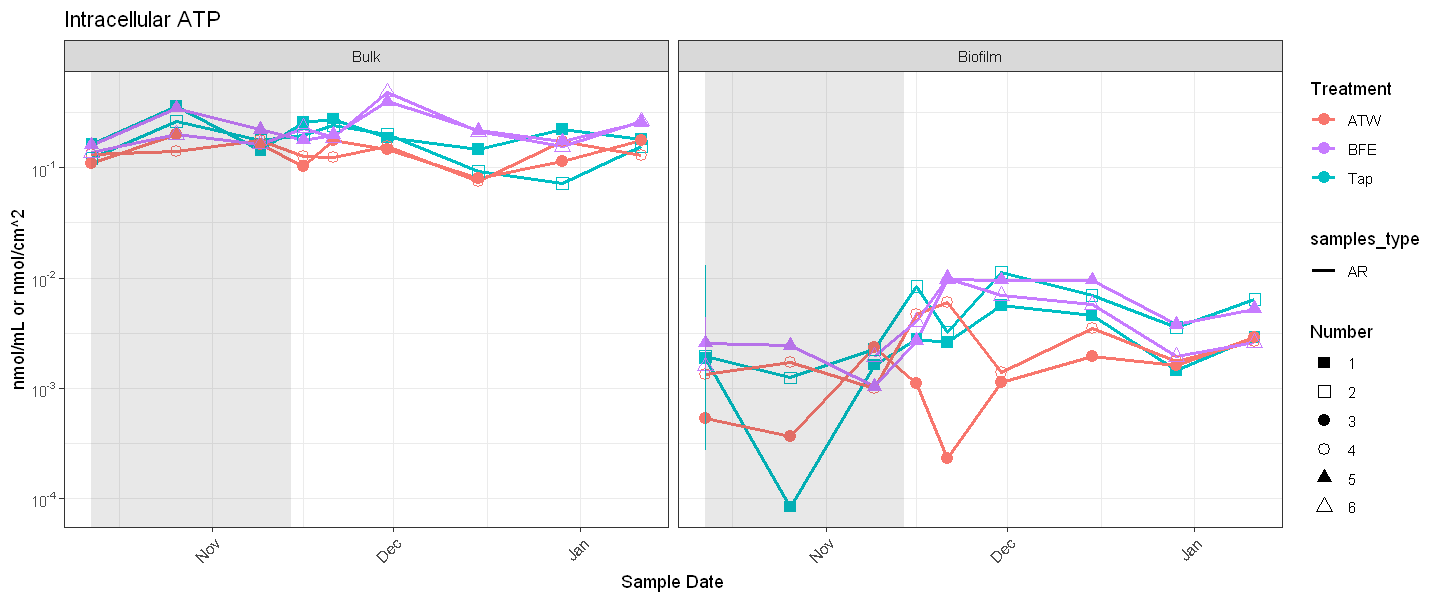

In [132]:
options(repr.plot.width=12, repr.plot.height=5)

plot_iatp_ind <- ggplot(df_ATP_nob  %>% filter(measurement == 'IC ATP',samples_type != 'Feed'), 
                   aes(x=sample_date, y=geomean_blanked, group= Number, color=Treatment, shape = Number, linetype = samples_type))+  
 scale_shape_manual(values = c(15,0,19,1,17,2)) + 
 scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4")) +
 geom_line(size=1)+
 geom_point(size=3)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Intracellular ATP", x="Sample Date", y="nmol/mL or nmol/cm^2") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 facet_wrap('type')+
 theme_bw() +
theme(axis.text.x = element_text(angle=45, hjust=1))

plot_iatp_ind
                                     
                                     
                                   

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


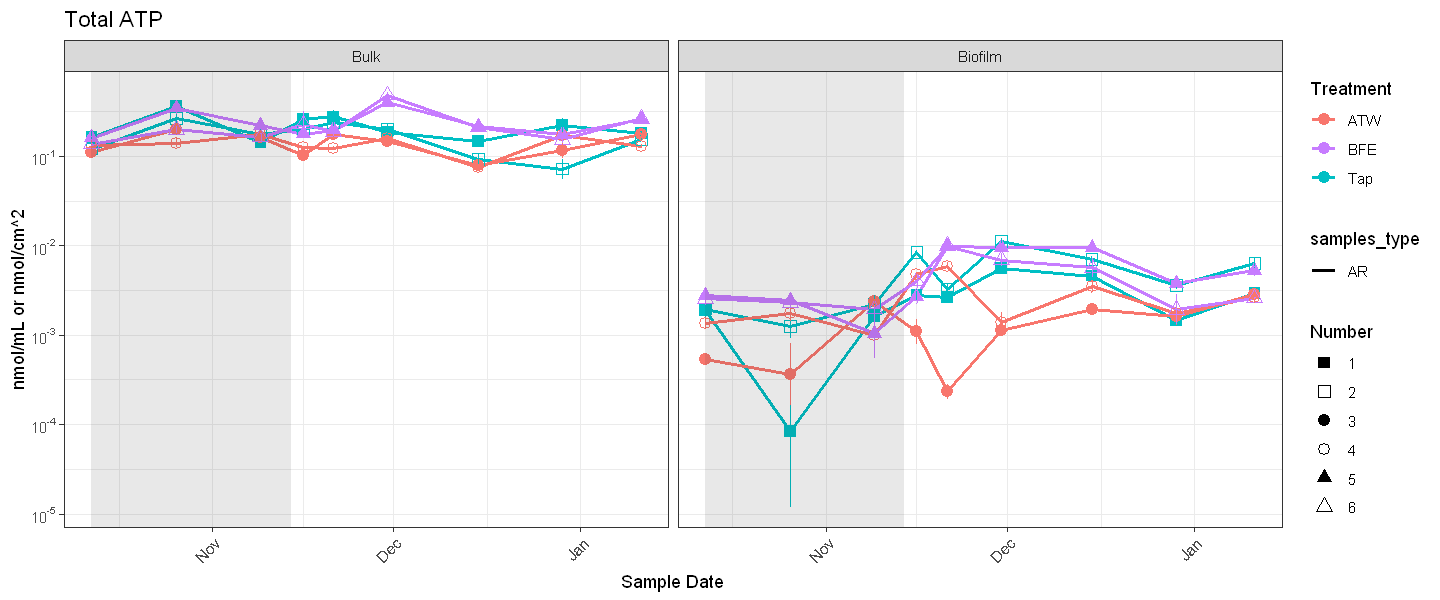

In [136]:
options(repr.plot.width=12, repr.plot.height=5)

plot_tatp_ind <- ggplot(df_ATP_nob  %>% filter(measurement == 'Total ATP',samples_type != 'Feed'), 
                   aes(x=sample_date, y=geomean_blanked, group= Number, color=Treatment, shape = Number, linetype = samples_type))+  
 scale_shape_manual(values = c(15,0,19,1,17,2)) + 
 scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4")) +
 geom_line(size=1)+
 geom_point(size=3)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Total ATP", x="Sample Date", y="nmol/mL or nmol/cm^2") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 facet_wrap('type')+
 theme_bw() +
theme(axis.text.x = element_text(angle=45, hjust=1))

plot_tatp_ind
                                     
                                     
                                   

# Temperature

In [5]:
Temp_df <- Temp %>% group_by(sample_date) %>%  
 summarize(geomean = exp(mean(log(temp_1))), geosd = exp(sd(log(temp_1))))
#Temp_df <- Temp

In [6]:
Temp_df$sample_date <- as.Date(Temp_df$sample_date, format = "%m/%d/%Y")

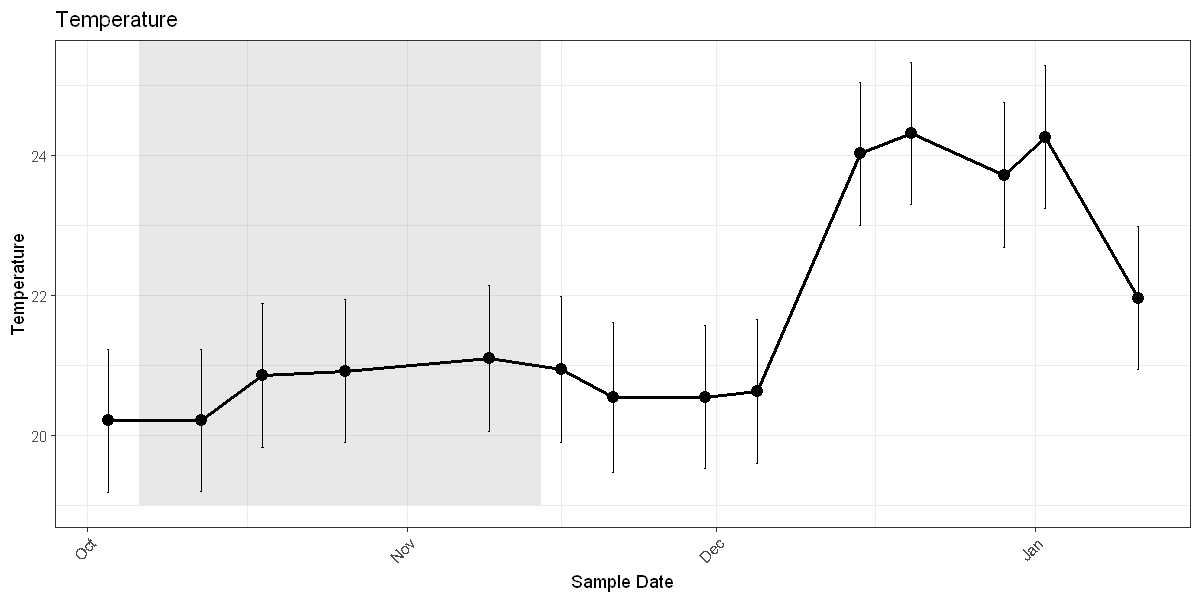

In [13]:
options(repr.plot.width=10, repr.plot.height=5)

plot_temp <- ggplot(Temp_df  , 
                   aes(x=sample_date, y=geomean))+  
 #scale_shape_manual(values = c(4,8,15,16,17,18,21,22,3,42)) + 
 geom_line(size=1)+
 geom_point(size=3)+
# geom_smooth(method= "loess", span=0.8, se=FALSE, lwd=1.5)+
geom_errorbar(aes(ymin=geomean-geosd, ymax=geomean+geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Temperature", x="Sample Date", y="Temperature") + 
annotate("rect", xmin = as.Date('2022-10-03'), xmax = as.Date('2022-11-14'), ymin = 19, ymax = Inf, alpha = 0.1, fill = "gray11") +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #facet_wrap('type')+
 theme_bw() +
theme(axis.text.x = element_text(angle=45, hjust=1))

plot_temp



## Mean

In [128]:
# Convert to date format
Temp$sample_date <- as.Date(Temp$sample_date, format = "%m/%d/%Y") 

In [129]:
Temp_new <- Temp %>% filter(Temp$sample_date > as.Date('2022-11-14'))

In [130]:
tap_AR <- Temp_new %>% filter(samples_type == 'AR1' | samples_type == 'AR2') %>% 
summarize(mean = mean(temp_1))  
tap_AR
ATW_AR <- Temp_new %>% filter(samples_type == 'AR3' | samples_type == 'AR4') %>% 
summarize(mean = mean(temp_1))   
ATW_AR
BFE_AR <- Temp_new %>% filter(samples_type == 'AR5' | samples_type == 'AR6') %>% 
summarize(mean = mean(temp_1))   
BFE_AR


tap <- Temp_new %>% filter(samples_type == 'Tap') %>% 
summarize(mean = mean(temp_1))  
tap
ATW <- Temp_new %>% filter(samples_type == 'Rare' ) %>% 
summarize(mean = mean(temp_1))   
ATW
BFE <- Temp_new %>% filter(samples_type == 'BFE' ) %>% 
summarize(mean = mean(temp_1))   
BFE

mean
<dbl>
22.89444


mean
<dbl>
22.76111


mean
<dbl>
22.12778


mean
<dbl>
21


mean
<dbl>
21.64


mean
<dbl>
21.38


In [137]:
Temp <- Temp %>% group_by(sample_date) %>%  
 summarize(geomean = exp(mean(log(temp_1))), geosd = exp(sd(log(temp_1))))
#Temp_df <- Temp

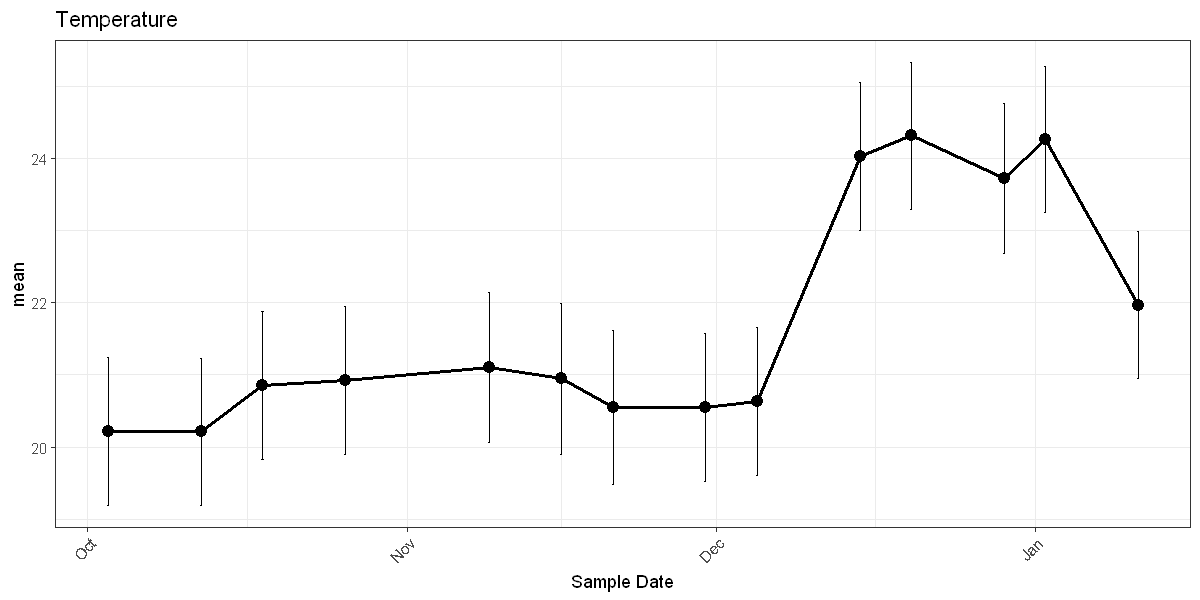

In [139]:
options(repr.plot.width=10, repr.plot.height=5)

plot_temp <- ggplot(Temp  , 
                   aes(x=sample_date, y=geomean))+  
 #scale_shape_manual(values = c(4,8,15,16,17,18,21,22,3,42)) + 
 geom_line(size=1)+
 geom_point(size=3)+
# geom_smooth(method= "loess", span=0.8, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean-geosd, ymax=geomean+geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "Temperature", x="Sample Date", y="mean") + 
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #facet_wrap('type')+
 theme_bw() +
theme(axis.text.x = element_text(angle=45, hjust=1))

plot_temp

ggsave(paste0(fig_dir, 'fig_s1.png'), width=10, height=5)

# pH

In [227]:
ph_df <- ph %>% group_by(sample_date) %>%  
 summarize(geomean = exp(mean(log(ph))), geosd = exp(sd(log(ph))))
#Temp_df <- Temp

In [232]:
ph_df$sample_date <- as.Date(ph_df$sample_date, format = "%m/%d/%Y") 

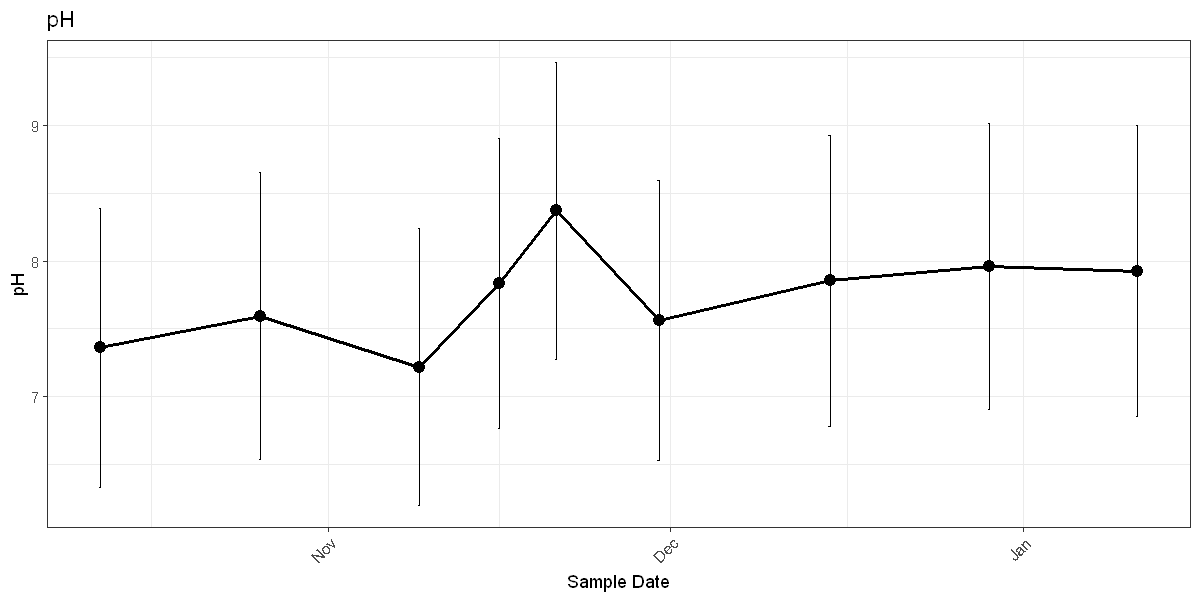

In [240]:
options(repr.plot.width=10, repr.plot.height=5)

plot_temp <- ggplot(ph_df  , 
                   aes(x=sample_date, y=geomean))+  
 #scale_shape_manual(values = c(4,8,15,16,17,18,21,22,3,42)) + 
 geom_line(size=1)+
 geom_point(size=3)+
# geom_smooth(method= "loess", span=0.8, se=FALSE, lwd=1.5)+
geom_errorbar(aes(ymin=geomean-geosd, ymax=geomean+geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "pH", x="Sample Date", y="pH") + 
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 #facet_wrap('type')+
 theme_bw() +
theme(axis.text.x = element_text(angle=45, hjust=1))

plot_temp



## Mean

In [236]:
ph_new <- ph %>% filter(sample_date > as.Date('2022-11-14'))

In [238]:
tap_AR <- ph_new %>% filter(samples_type == 'AR1' | samples_type == 'AR2') %>% 
summarize(mean = mean(ph))  
tap_AR
ATW_AR <- ph_new %>% filter(samples_type == 'AR3' | samples_type == 'AR4') %>% 
summarize(mean = mean(ph))   
ATW_AR
BFE_AR <- ph_new %>% filter(samples_type == 'AR5' | samples_type == 'AR6') %>% 
summarize(mean = mean(ph))   
BFE_AR




tap <- ph_new %>% filter(samples_type == 'Tap') %>% 
summarize(mean = mean(ph))  
tap
ATW <- ph_new %>% filter(samples_type == 'Rare' ) %>% 
summarize(mean = mean(ph))   
ATW
BFE <- ph_new %>% filter(samples_type == 'BFE' ) %>% 
summarize(mean = mean(ph))   
BFE

mean
<dbl>
7.303333


mean
<dbl>
7.645833


mean
<dbl>
7.716667


mean
<dbl>
7.466667


mean
<dbl>
7.851667


mean
<dbl>
7.896667


# Combinations

## BAC Time Series

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks =

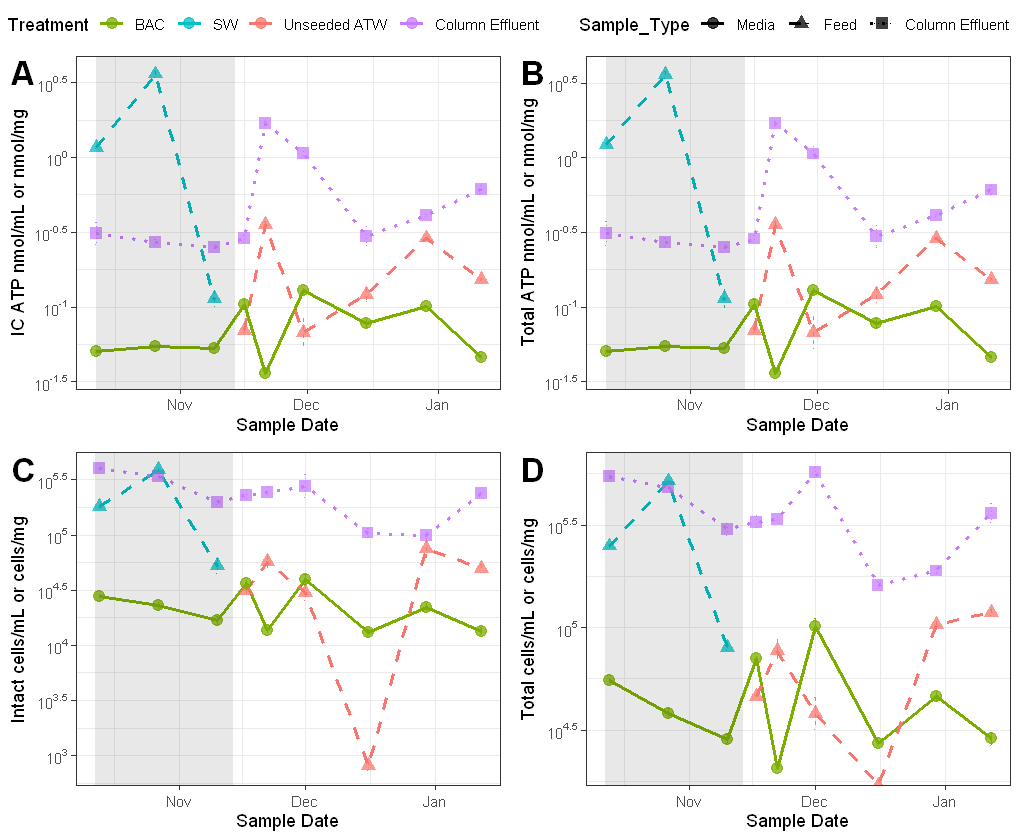

In [215]:


options(repr.plot.width = 8.5, repr.plot.height =7)
fig_s4<- ggarrange(plot_iatp_bac,plot_tatp_bac, plot_icc_bac, plot_tcc_bac, ncol=2, nrow=2, labels= c("A", "B", "C", "D"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_s4

ggsave(paste0(fig_dir, 'fig_s4.png'), width=8.5, height=7)


## ICC:TCC

In [25]:
ICC_TCC %>% filter(type == 'Biofilm') %>% ungroup() %>% summarize(min= min(Percent_Intact)) %>% pull(min)
ICC_TCC %>% filter(Sample_Type == 'AR',type == 'Bulk') %>% ungroup() %>% summarize(min= min(Percent_Intact)) %>% pull(min)
ICC_TCC %>% filter(Sample_Type == 'Feed',type == 'Bulk') %>% ungroup() %>% summarize(min= min(Percent_Intact)) %>% pull(min)
ICC_TCC %>% filter(type == 'BAC Media') %>% ungroup() %>% summarize(min= min(Percent_Intact)) %>% pull(min)


ICC_TCC %>% filter(type == 'Biofilm') %>% ungroup() %>% summarize(max= max(Percent_Intact)) %>% pull(max)
ICC_TCC %>% filter(Sample_Type == 'AR', type == 'Bulk') %>% ungroup() %>% summarize(max= max(Percent_Intact)) %>% pull(max)
ICC_TCC %>% filter(Sample_Type == 'Feed', type == 'Bulk') %>% ungroup() %>% summarize(max= max(Percent_Intact)) %>% pull(max)
ICC_TCC %>% filter(type == 'BAC Media') %>% ungroup() %>% summarize(max= max(Percent_Intact)) %>% pull(max)


[1] 26.04065

[1] 40.71502

[1] 41.79909

Warning message:
"There was 1 warning in `summarize()`.
ℹ In argument: `min = min(Percent_Intact)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf"


[1] Inf

[1] 65.22982

[1] 77.70344

[1] Inf

Warning message:
"There was 1 warning in `summarize()`.
ℹ In argument: `max = max(Percent_Intact)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf"


[1] -Inf

### Time Series

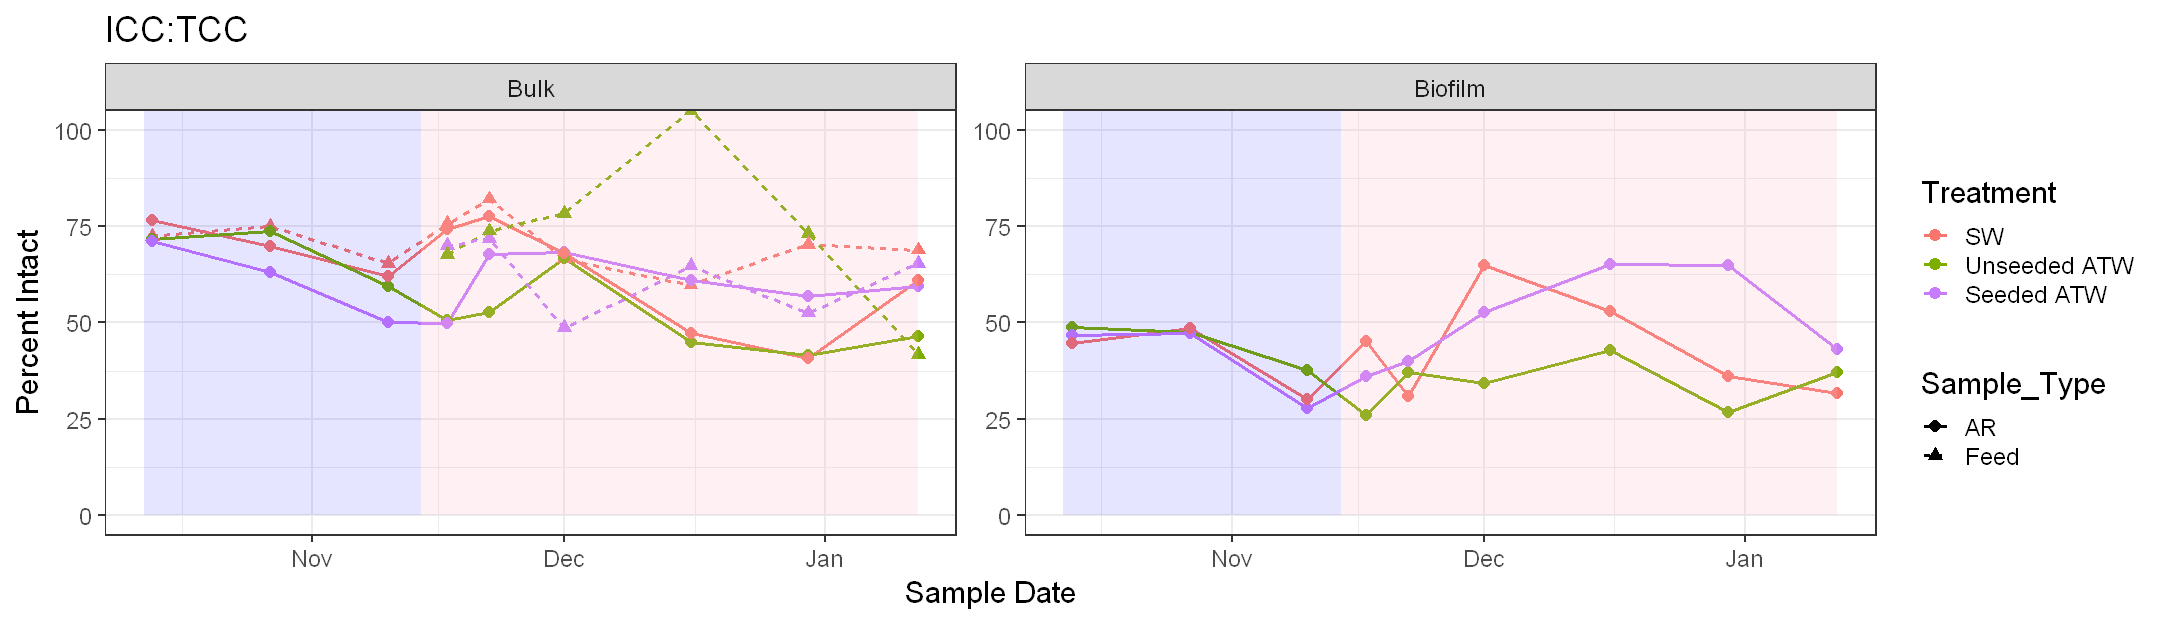

In [455]:
ICC_TCC <- FCM_mean_nob %>% group_by(Date,Treatment,Sample_Type,type) %>% mutate(Percent_Intact  = 100*geomean_blanked[Stain == "SGPI"]/geomean_blanked[Stain == "SG"])
ICC_TCC <- ICC_TCC %>% filter(Sample_Type  != 'Feed' | Treatment != 'uATW' | Date !='2022-12-16') 
options(repr.plot.width=18, repr.plot.height=5.2)

plot_fcm <- ggplot(ICC_TCC  %>% filter(Stain == 'SGPI'), 
                   aes(x=Date, y=Percent_Intact, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
 scale_color_manual(values = c('#F8766D',"#7CAE00","#C77CFF","#00BFC4")) +
 geom_line(size=1)+
 geom_point(size=3)+
 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
#geom_errorbar(aes(ymin=geomean_blanked-geosd, ymax=geomean_blanked+geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "ICC:TCC", x="Sample Date", y="Percent Intact") + 
 scale_y_continuous(limits= c(0, 100) )+ 

# scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "blue1") +
 annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type', scales = "free")+
 theme_bw(base_size = 18) 

plot_fcm

### Boxplots

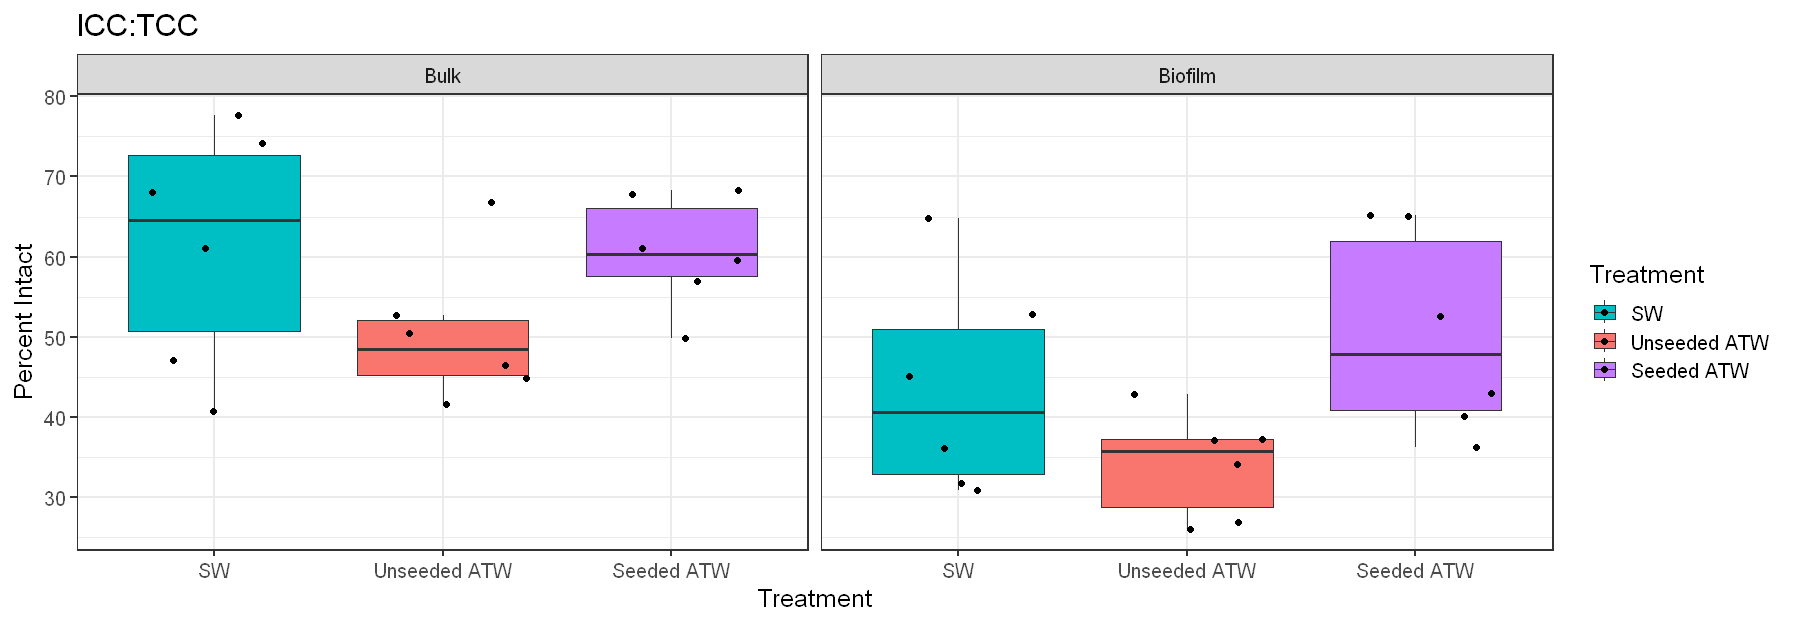

In [456]:

options(repr.plot.width=15, repr.plot.height=5.2)

fig_s7 <- ggplot(ICC_TCC  %>%  filter(Stain == 'SGPI', Sample_Type == 'AR', Date > as.Date('2022-11-14')), aes(x= Treatment, y= Percent_Intact, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
 #   scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E-9, 1E-5), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "ICC:TCC", x="Treatment", y="Percent Intact") + 
 #   geom_vline(xintercept = 6.5,size=1)+                                    
 #   geom_vline(xintercept = 3.5,size=1)+  
                                        #facet_wrap(~type, scales= "free", ncol=2) +
   # geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
  #          ymin = -Inf,ymax = Inf,alpha = 0.1)+
  #  geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
   #         ymin = -Inf,ymax = Inf,alpha = 0.2)+
    facet_wrap('type', scales='fixed' )  +
    theme(axis.text.x = element_text(face = "bold")) +
    theme_bw(base_size = 15 )
                                        
fig_s7
ggsave(paste0(fig_dir, 'fig_s7.png'), width=15, height=5.2)
              

In [26]:
ICC_TCC

Date,Stain,Sample_Type,type,geomean,geosd,Treatment,geomean_blanked,Percent_Intact
<date>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
2022-10-13,SG,Feed,Bulk,253575.419,1.014647,Tap,249757.1182,72.28930
2022-10-13,SGPI,Feed,Bulk,182008.320,1.023152,Tap,180547.6706,72.28930
2022-10-27,SG,Feed,Bulk,519766.820,1.006154,Tap,518146.0413,74.91678
2022-10-27,SGPI,Feed,Bulk,388738.425,1.044221,Tap,388178.3232,74.91678
2022-11-10,SG,Feed,Bulk,82441.212,1.038308,Tap,80099.8262,65.34251
2022-11-10,SGPI,Feed,Bulk,53342.421,1.159237,Tap,52339.2369,65.34251
2022-11-17,SG,Feed,Bulk,328501.542,1.074108,Seeded ATW,327024.9783,69.91600
2022-11-17,SG,Feed,Bulk,47714.749,1.034754,Unseeded ATW,46238.1853,67.64765
2022-11-17,SG,Feed,Bulk,304587.275,1.016141,Tap,303110.7116,75.62787


### Tests

In [457]:
a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14') )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
kruskal.test(Percent_Intact ~ Treatment, data = AR_ICC)

a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14') )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
kruskal.test(Percent_Intact ~ Treatment, data = AR_ICC)


a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14') )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
kruskal.test(Percent_Intact ~ Treatment, data = AR_ICC)


Adding missing grouping variables: `Date`, `Sample_Type`, `type`



	Kruskal-Wallis rank sum test

data:  Percent_Intact by Treatment
Kruskal-Wallis chi-squared = 3.5205, df = 2, p-value = 0.172


Adding missing grouping variables: `Date`, `Sample_Type`, `type`



	Kruskal-Wallis rank sum test

data:  Percent_Intact by Treatment
Kruskal-Wallis chi-squared = 5.1579, df = 2, p-value = 0.07585


Adding missing grouping variables: `Date`, `Sample_Type`, `type`



	Kruskal-Wallis rank sum test

data:  Percent_Intact by Treatment
Kruskal-Wallis chi-squared = 3.3099, df = 2, p-value = 0.1911


In [458]:
a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14'))%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
dunnTest(Percent_Intact ~ Treatment, data=AR_ICC_2,  method="bh")


a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14'))%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
dunnTest(Percent_Intact ~ Treatment, data=AR_ICC_2,  method="bh")


a <- ICC_TCC %>% filter(Stain == 'SGPI', Date > as.Date('2022-11-14'))%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_Intact) %>% drop_na()
dunnTest(Percent_Intact ~ Treatment, data=AR_ICC_2,  method="bh")

Adding missing grouping variables: `Date`, `Sample_Type`, `type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z    P.unadj     P.adj
1           Seeded ATW - SW -0.1081476 0.91387860 0.9138786
2 Seeded ATW - Unseeded ATW  1.5681404 0.11684837 0.1752726
3         SW - Unseeded ATW  1.6762880 0.09368179 0.2810454

Adding missing grouping variables: `Date`, `Sample_Type`, `type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison       Z    P.unadj      P.adj
1           Seeded ATW - SW 1.13555 0.25614497 0.25614497
2 Seeded ATW - Unseeded ATW 2.27110 0.02314093 0.06942279
3         SW - Unseeded ATW 1.13555 0.25614497 0.38421745

Adding missing grouping variables: `Date`, `Sample_Type`, `type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z    P.unadj     P.adj
1           Seeded ATW - SW -1.3518452 0.17642485 0.2646373
2 Seeded ATW - Unseeded ATW -1.7303618 0.08356565 0.2506969
3         SW - Unseeded ATW -0.3785166 0.70504683 0.7050468

## Individual Reactor Plots

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite valu

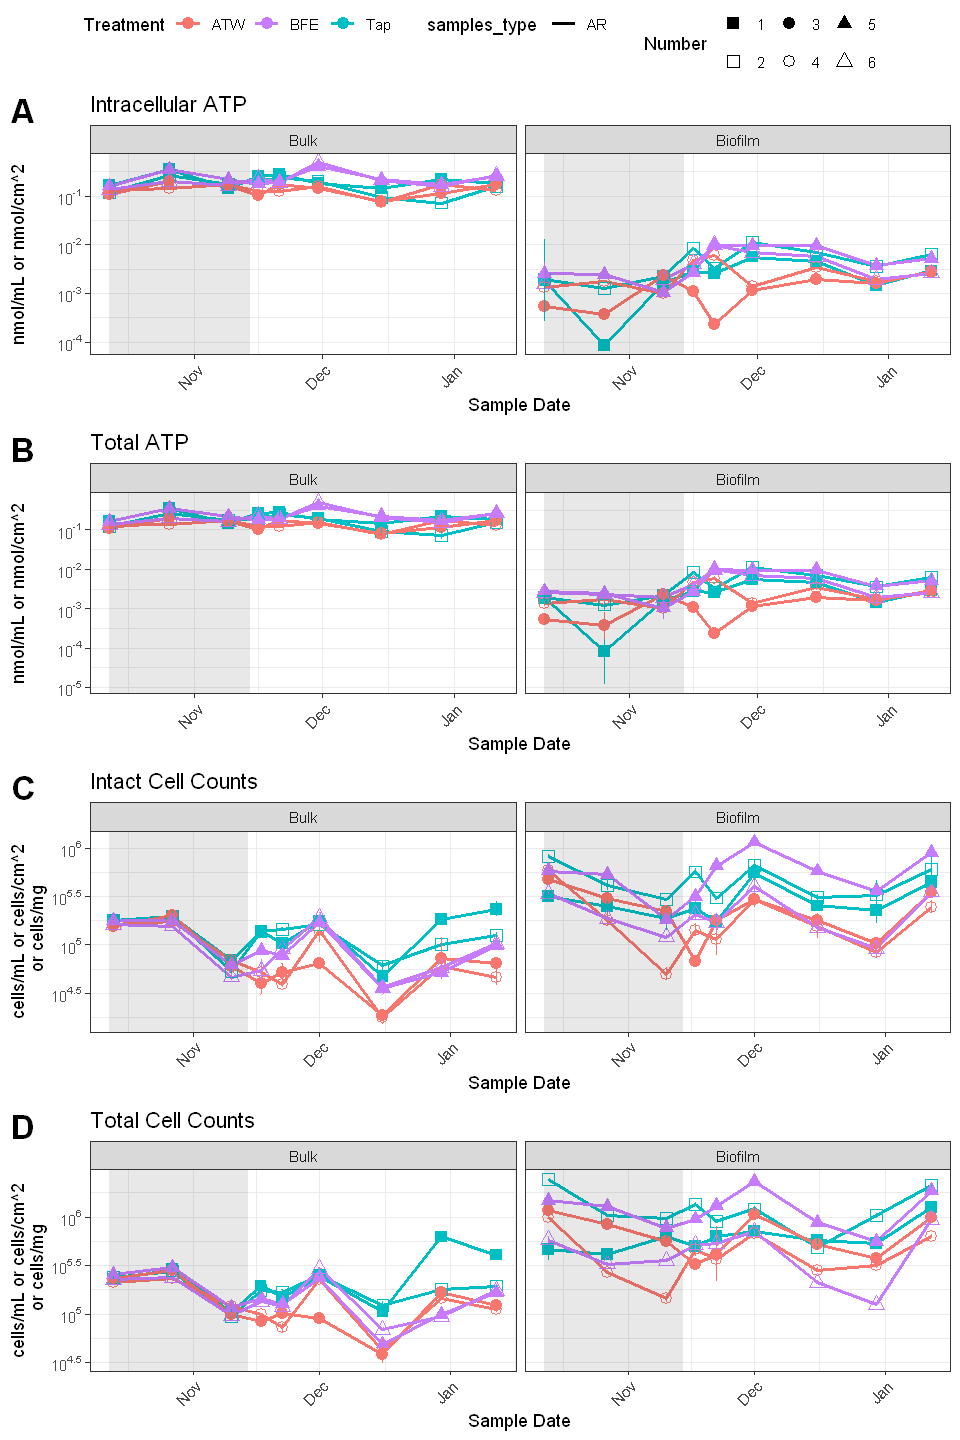

In [148]:
options(repr.plot.width = 8, repr.plot.height =12)
fig_s3<- ggarrange( plot_iatp_ind, plot_tatp_ind, plot_icc_ind, plot_tcc_ind, ncol=1, nrow=4, labels= c("A", "B", "C", "D"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_s3

ggsave(paste0(fig_dir, 'fig_s3.png'), width=8, height=12)


## Combine Data for further analysis

In [145]:
# Combine Individual Data
#Reorganize FCM data to same format as ATP

FCM_un <- FCM_std
FCM_TCC <- FCM_un %>% filter(Stain=='SG') %>% mutate(measurement= 'TCC') %>% ungroup() %>% select(- "Stain")
FCM_ICC <- FCM_un %>% filter(Stain=='SGPI') %>% mutate(measurement= 'ICC') %>% ungroup() %>% select(- "Stain")
FCM_un <- rbind(FCM_TCC,FCM_ICC) 
FCM_un$Date <- FCM_un$Date -1

ATP_un <- df_ATP_new  %>% rename(Date = sample_date)

#Combo
tot_un <- rbind(FCM_un, ATP_un)

tot_un["phase"] <- "Phase I"
tot_un$phase[tot_un$Date > as.Date('2022-11-14')] <- "Phase II"

specific_order <- c('IC ATP', 'Total ATP', 'ICC', 'TCC')
tot_un$measurement <- factor(tot_un$measurement, levels = specific_order)

In [44]:
# Combine combined data
#Reorganize FCM data to same format as ATP
FCM_df <- FCM_mean_nob   #  FCM_mean
FCM_TCC <- FCM_df %>% filter(Stain=='SG') %>% mutate(measurement= 'TCC') %>% ungroup() %>% select(- "Stain")
FCM_ICC <- FCM_df %>% filter(Stain=='SGPI') %>% mutate(measurement= 'ICC') %>% ungroup() %>% select(- "Stain")
FCM_df <- rbind(FCM_TCC,FCM_ICC) 
FCM_df$Date <- FCM_df$Date -1
ATP <- ATP_mean_nob   %>% rename(Date = sample_date)

#ATP_mean

#Combine
tot <- rbind(FCM_df, ATP)
tot["phase"] <- "Phase I"
tot$phase[tot$Date > as.Date('2022-11-14')] <- "Phase II"

# Reorder in specific order
specific_order <- c('IC ATP', 'Total ATP', 'ICC', 'TCC')
tot$measurement <- factor(tot$measurement, levels = specific_order)

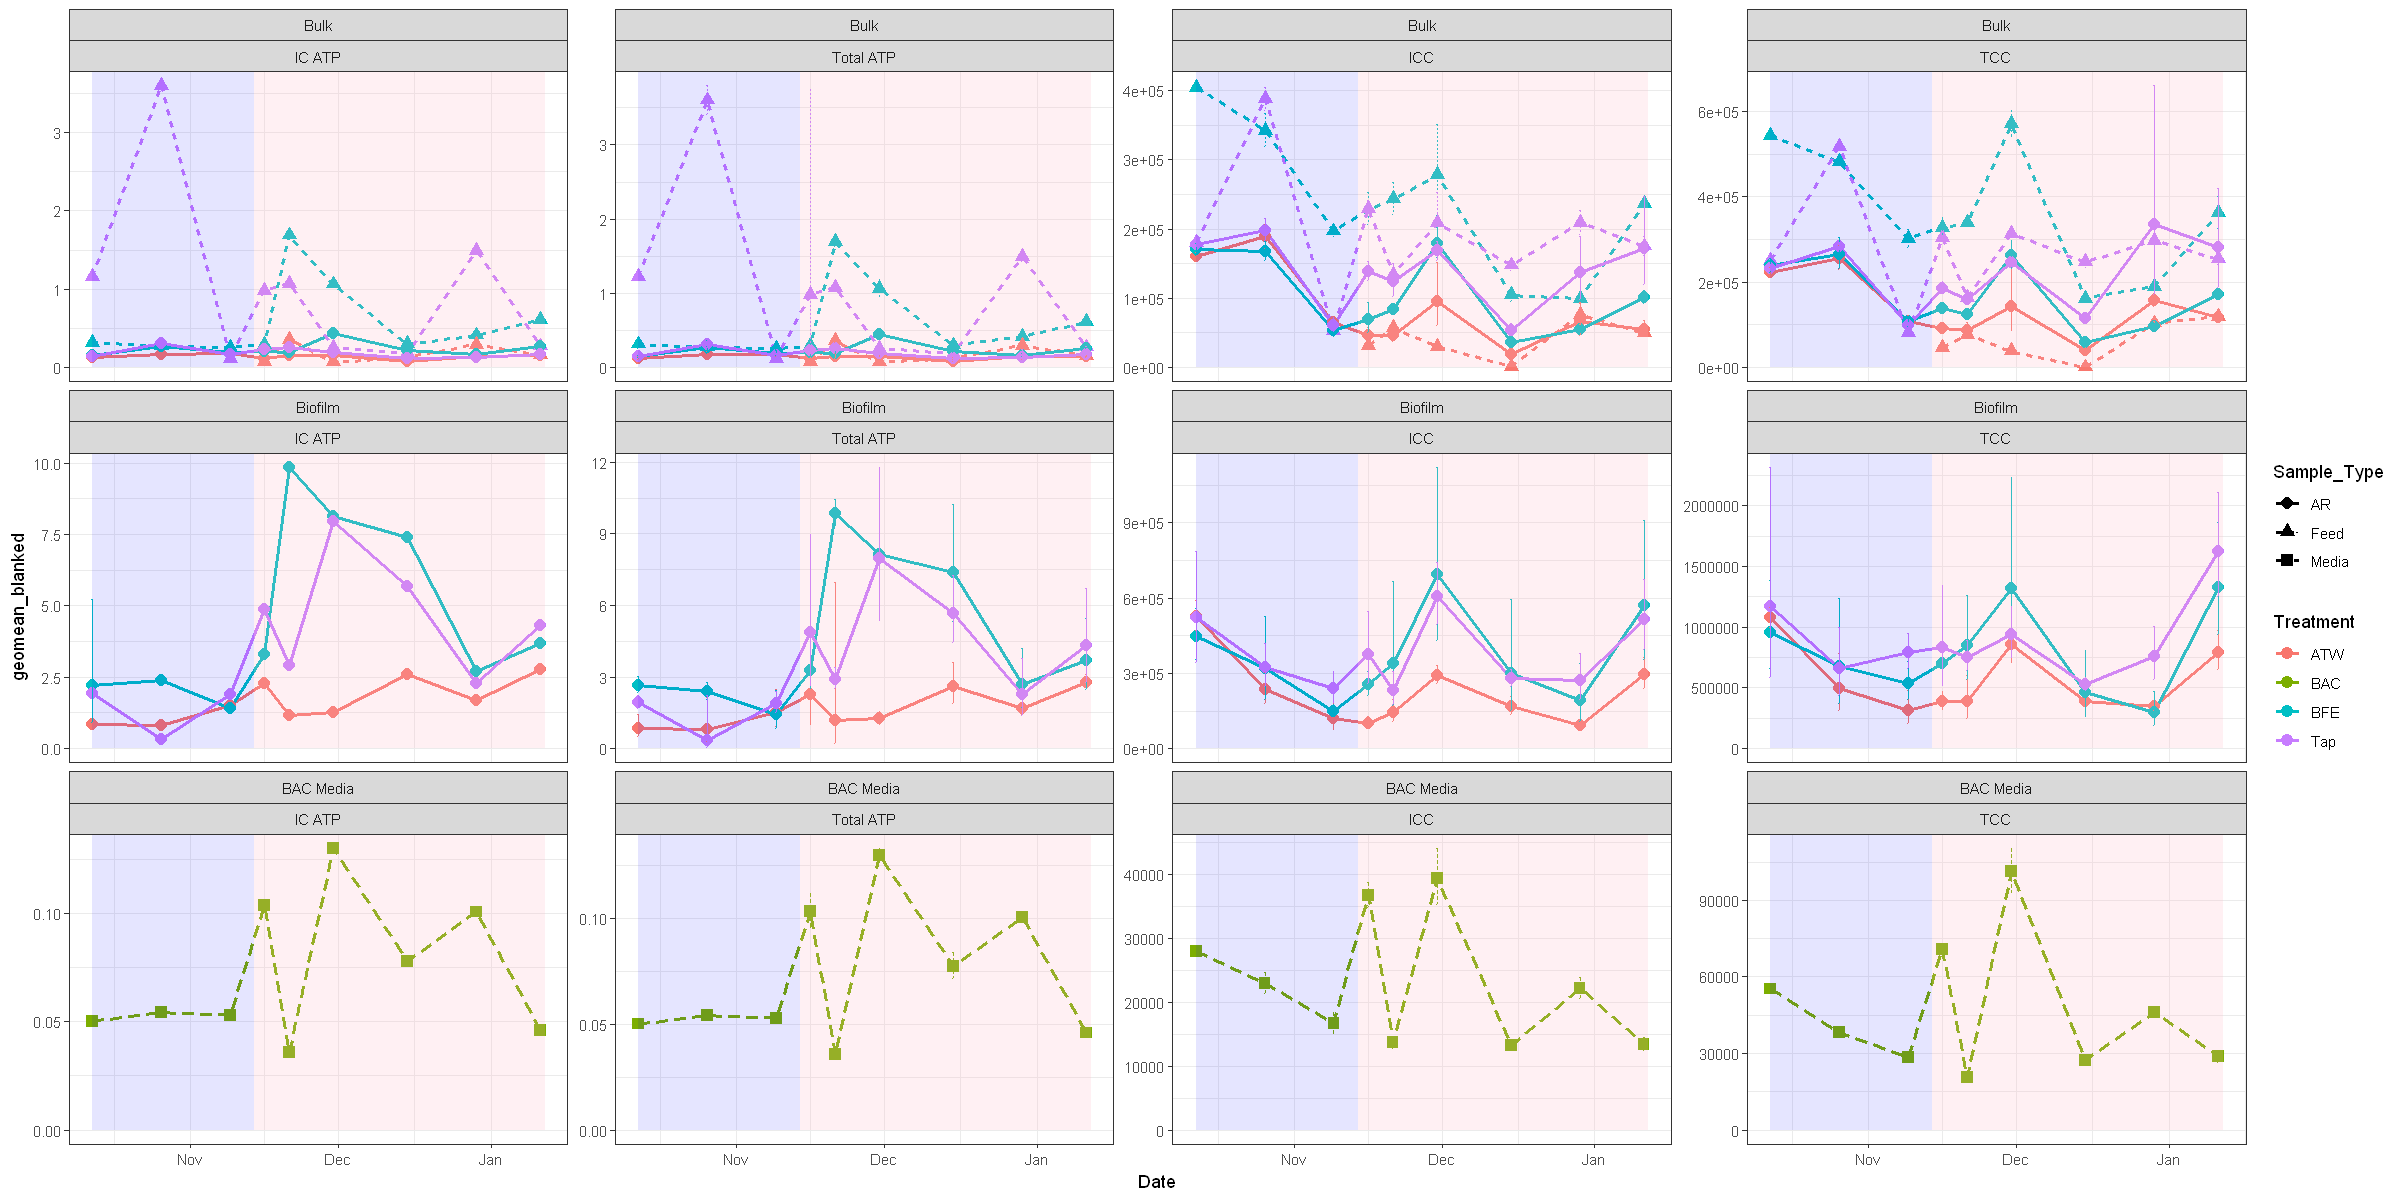

In [264]:
options(repr.plot.width=20, repr.plot.height=10)

plot_tot <- ggplot(tot, aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+
 geom_line(size=1)+
 geom_point(size=3)+
 geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 #labs( x="Sample Date", y="pg ATP/mg or cells/mg                                     pg ATP/mL or cells/mL                                     pg ATP/cm^2 or cells/cm^2") + 
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "blue1") +
 annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type~measurement', scales='free_y' )  +
 theme_bw()

plot_tot

# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +


## ATP:ICC

In [69]:
ATP_perICC<- tot %>% group_by(Date,Treatment,Sample_Type,type) %>% summarize(Percent_ATP  = geomean_blanked[measurement == "IC ATP"]/geomean_blanked[measurement == "ICC"])
ATP_perICC 

`summarise()` has grouped output by 'Date', 'Treatment', 'Sample_Type'. You can
override using the `.groups` argument.


Date,Treatment,Sample_Type,type,Percent_ATP
<date>,<fct>,<chr>,<fct>,<dbl>
2022-10-12,SW,AR,Bulk,7.913293e-07
2022-10-12,SW,AR,Biofilm,3.661406e-09
2022-10-12,SW,Feed,Bulk,6.438620e-06
2022-10-12,Unseeded ATW,AR,Bulk,7.531301e-07
2022-10-12,Unseeded ATW,AR,Biofilm,1.600823e-09
2022-10-12,Seeded ATW,AR,Bulk,8.715673e-07
2022-10-12,Seeded ATW,AR,Biofilm,4.475358e-09
2022-10-26,SW,AR,Bulk,1.551128e-06
2022-10-26,SW,AR,Biofilm,1.003066e-09


### Time Series

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


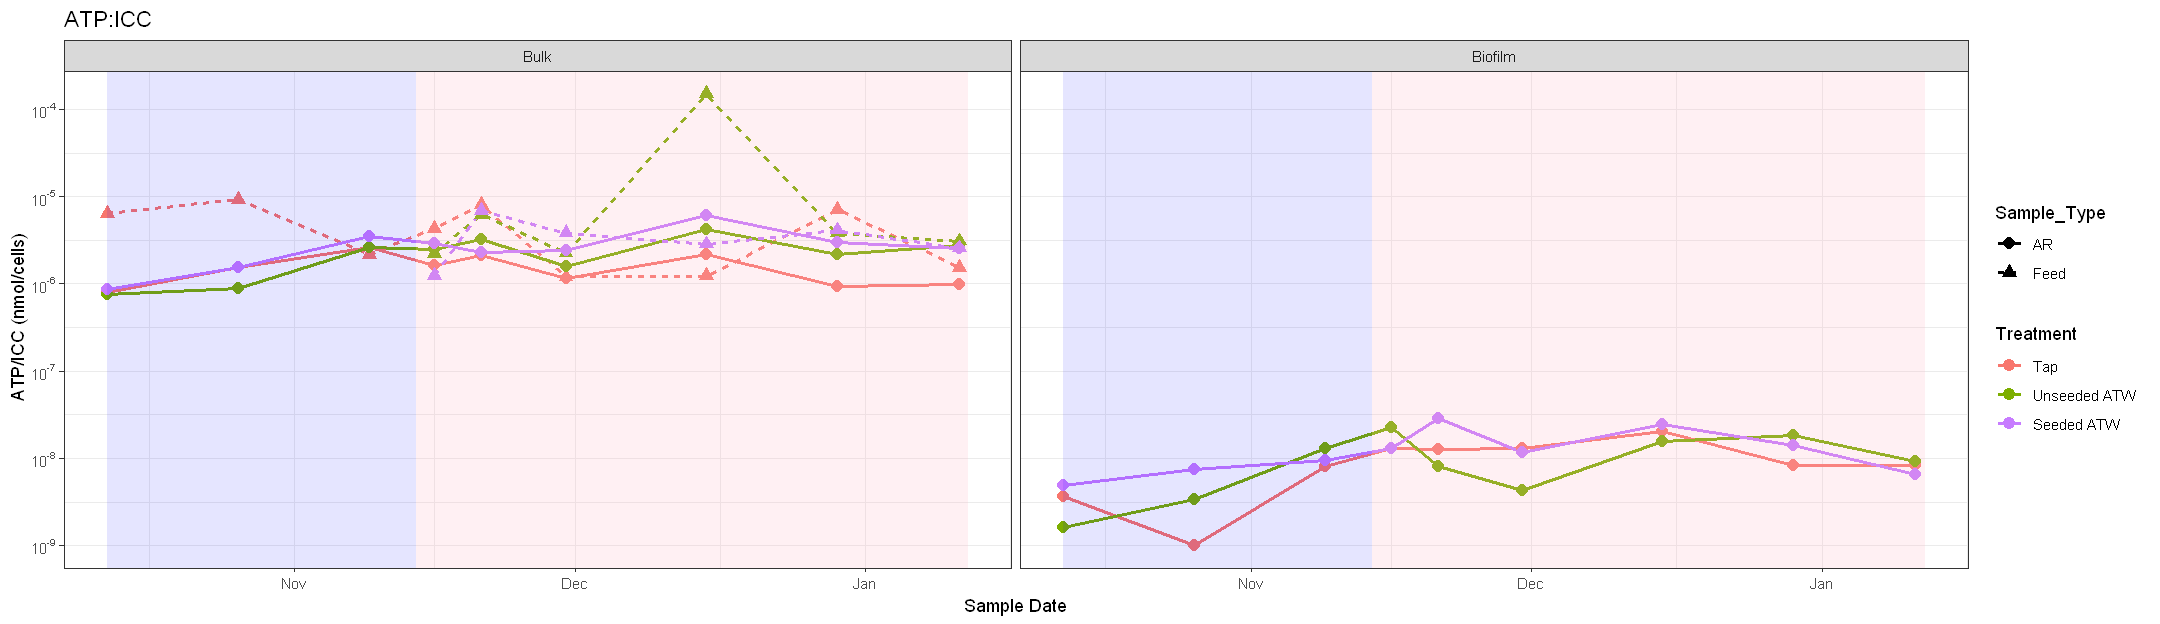

In [116]:
options(repr.plot.width=18, repr.plot.height=5.2)

plot_tot <- ggplot(ATP_perICC, aes(x=Date, y=Percent_ATP, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+
 geom_line(size=1)+
 geom_point(size=3)+
 scale_color_manual(values = c('#F8766D',"#7CAE00","#C77CFF","#00BFC4")) +
 labs(title = "ATP:ICC", x="Sample Date", y=" ATP/ICC (nmol/cells)") + 
 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) + 
 #geom_errorbar(aes(ymin=geomean_blanked/geosd, ymax=geomean_blanked*geosd), width=0.2) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "blue1") +
 annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink1") +
 facet_wrap('type', scales='fixed' )  +
 theme_bw()

plot_tot

# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
# scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +



### Boxplot

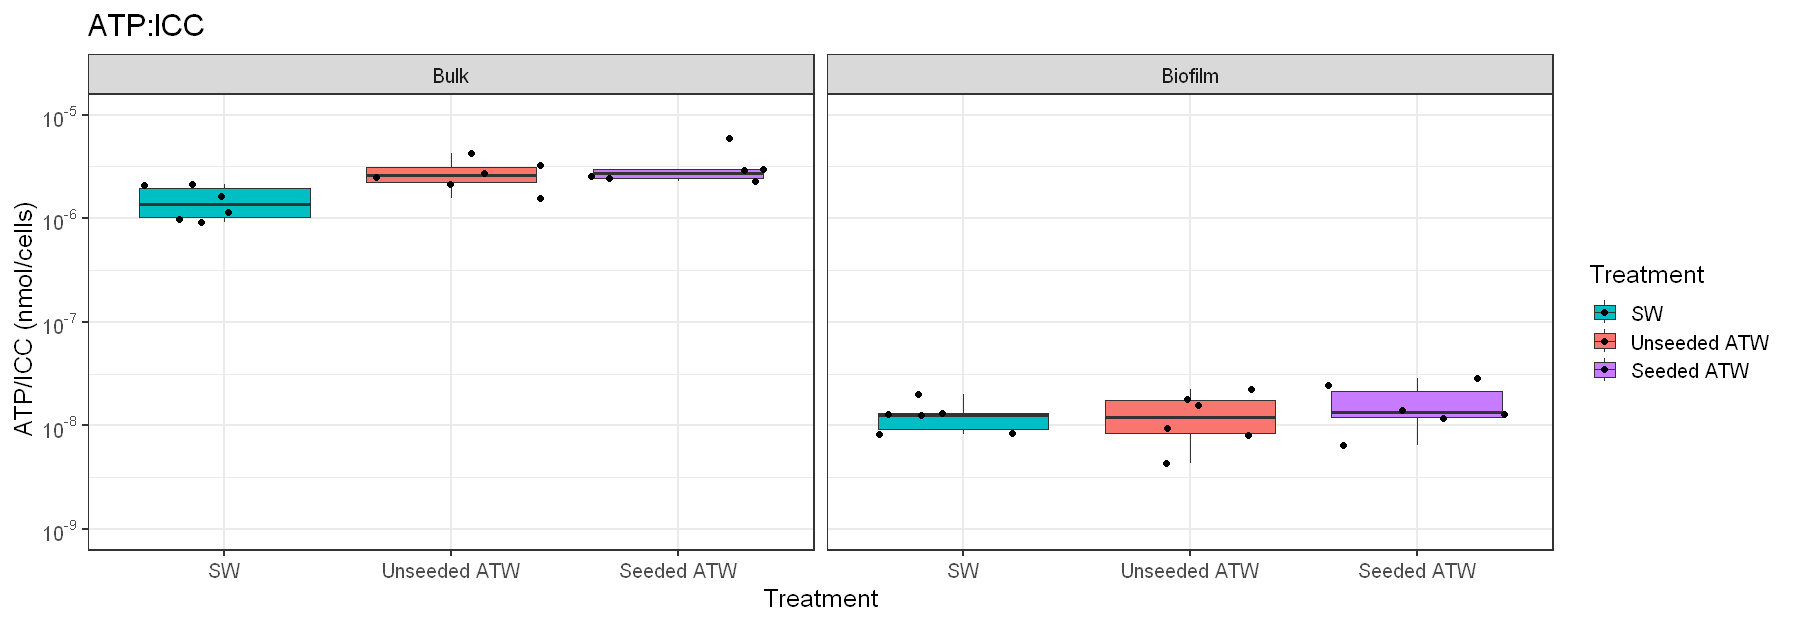

In [461]:
fig_s8 <- ggplot(ATP_perICC %>% filter(Sample_Type == 'AR', Date > as.Date('2022-11-14')), aes(x= Treatment, y= Percent_ATP, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E-9, 1E-5), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "ATP:ICC", x="Treatment", y=" ATP/ICC (nmol/cells)") + 
 #   geom_vline(xintercept = 6.5,size=1)+                                    
 #   geom_vline(xintercept = 3.5,size=1)+  
                                        #facet_wrap(~type, scales= "free", ncol=2) +
   # geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
  #          ymin = -Inf,ymax = Inf,alpha = 0.1)+
  #  geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
   #         ymin = -Inf,ymax = Inf,alpha = 0.2)+
    facet_wrap('type', scales='fixed' )  +
    theme(axis.text.x = element_text(face = "bold")) +
    theme_bw(base_size = 15 )
                                        
fig_s8
ggsave(paste0(fig_dir, 'fig_s8.png'), width=15, height=5)       

### Tests

In [70]:
a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14') )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
kruskal.test(Percent_ATP ~ Treatment, data = AR_ICC)

a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14') )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
kruskal.test(Percent_ATP ~ Treatment, data = AR_ICC)


a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14') )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
kruskal.test(Percent_ATP ~ Treatment, data = AR_ICC)


Adding missing grouping variables: `Date`, `Sample_Type`



	Kruskal-Wallis rank sum test

data:  Percent_ATP by Treatment
Kruskal-Wallis chi-squared = 9.2749, df = 2, p-value = 0.009683


Adding missing grouping variables: `Date`, `Sample_Type`



	Kruskal-Wallis rank sum test

data:  Percent_ATP by Treatment
Kruskal-Wallis chi-squared = 0.5614, df = 2, p-value = 0.7553


Adding missing grouping variables: `Date`, `Sample_Type`



	Kruskal-Wallis rank sum test

data:  Percent_ATP by Treatment
Kruskal-Wallis chi-squared = 0.24561, df = 2, p-value = 0.8844


In [71]:
a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14'))%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
dunnTest(Percent_ATP ~ Treatment, data=AR_ICC_2,  method="bh")


a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14'))%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
dunnTest(Percent_ATP ~ Treatment, data=AR_ICC_2,  method="bh")


a <- ATP_perICC %>% filter( Date > as.Date('2022-11-14'))%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% dplyr::select(Treatment, Percent_ATP) %>% drop_na()
dunnTest(Percent_ATP ~ Treatment, data=AR_ICC_2,  method="bh")

Adding missing grouping variables: `Date`, `Sample_Type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z     P.unadj      P.adj
1           Seeded ATW - SW  2.8659118 0.004158101 0.01247430
2 Seeded ATW - Unseeded ATW  0.5407381 0.588688134 0.58868813
3         SW - Unseeded ATW -2.3251737 0.020062674 0.03009401

Adding missing grouping variables: `Date`, `Sample_Type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z   P.unadj     P.adj
1           Seeded ATW - SW 0.6488857 0.5164123 0.7746184
2 Seeded ATW - Unseeded ATW 0.6488857 0.5164123 1.0000000
3         SW - Unseeded ATW 0.0000000 1.0000000 1.0000000

Adding missing grouping variables: `Date`, `Sample_Type`
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z   P.unadj     P.adj
1           Seeded ATW - SW  0.1622214 0.8711315 0.8711315
2 Seeded ATW - Unseeded ATW -0.3244428 0.7456028 1.0000000
3         SW - Unseeded ATW -0.4866643 0.6264963 1.0000000

In [61]:
ATP_perICC %>% filter( Date > as.Date('2022-11-14'))%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 


Date,Treatment,Sample_Type,type,Percent_ATP
<date>,<fct>,<chr>,<fct>,<dbl>
2022-11-16,Tap,AR,Bulk,1.636004e-06
2022-11-16,Unseeded ATW,AR,Bulk,2.476195e-06
2022-11-16,Seeded ATW,AR,Bulk,2.915961e-06
2022-11-21,Tap,AR,Bulk,2.093834e-06
2022-11-21,Unseeded ATW,AR,Bulk,3.249939e-06
2022-11-21,Seeded ATW,AR,Bulk,2.308937e-06
2022-11-30,Tap,AR,Bulk,1.143535e-06
2022-11-30,Unseeded ATW,AR,Bulk,1.586303e-06
2022-11-30,Seeded ATW,AR,Bulk,2.442872e-06


## Mean parameters

In [43]:
Reservoir <- tot %>% filter( Sample_Type== 'Feed',type == 'Bulk', phase == 'Phase II' ) %>% 
group_by(Treatment,measurement) %>% 
summarize(mean = mean(geomean_blanked))  

Reservoir %>% mutate(calculation_non_scientific = format(mean, scientific = FALSE))

Bulk <- tot %>% filter( Sample_Type== 'AR',type == 'Bulk', phase == 'Phase II' ) %>% 
group_by(Treatment,measurement) %>% 
summarize(mean = mean(geomean_blanked))  

Bulk %>% mutate(calculation_non_scientific = format(mean, scientific = FALSE))

Biofilm <- tot %>% filter( Sample_Type== 'AR',type == 'Biofilm', phase == 'Phase II' ) %>% 
group_by(Treatment,measurement) %>% 
summarize(mean = mean(geomean_blanked))  

Biofilm %>% mutate(calculation_non_scientific = format(mean, scientific = FALSE))


`summarise()` has grouped output by 'Treatment'. You can override using the
`.groups` argument.


Treatment,measurement,mean,calculation_non_scientific
<fct>,<fct>,<dbl>,<chr>
Tap,IC ATP,7.075709e-01,0.7075709
Tap,Total ATP,7.075709e-01,0.7075709
Tap,ICC,1.837910e+05,183791.0376644
Tap,TCC,2.629092e+05,262909.2418323
Unseeded ATW,IC ATP,1.753757e-01,0.1753757
Unseeded ATW,Total ATP,1.753757e-01,0.1753757
Unseeded ATW,ICC,4.065452e+04,40654.5163970
Unseeded ATW,TCC,6.388230e+04,63882.3002600
Seeded ATW,IC ATP,7.252375e-01,0.7252375


`summarise()` has grouped output by 'Treatment'. You can override using the
`.groups` argument.


Treatment,measurement,mean,calculation_non_scientific
<fct>,<fct>,<dbl>,<chr>
Tap,IC ATP,1.811349e-01,0.1811349
Tap,Total ATP,1.811349e-01,0.1811349
Tap,ICC,1.319220e+05,131922.0004370
Tap,TCC,2.203606e+05,220360.5816291
Unseeded ATW,IC ATP,1.302355e-01,0.1302355
Unseeded ATW,Total ATP,1.302355e-01,0.1302355
Unseeded ATW,ICC,5.411774e+04,54117.7410680
Unseeded ATW,TCC,1.057620e+05,105761.9823085
Seeded ATW,IC ATP,2.451494e-01,0.2451494


`summarise()` has grouped output by 'Treatment'. You can override using the
`.groups` argument.


Treatment,measurement,mean,calculation_non_scientific
<fct>,<fct>,<dbl>,<chr>
Tap,IC ATP,4.663931e-03,0.004663931
Tap,Total ATP,4.663931e-03,0.004663931
Tap,ICC,3.807927e+05,380792.681299638
Tap,TCC,9.055763e+05,905576.301864685
Unseeded ATW,IC ATP,1.959972e-03,0.001959972
Unseeded ATW,Total ATP,1.959972e-03,0.001959972
Unseeded ATW,ICC,1.822986e+05,182298.554318019
Unseeded ATW,TCC,5.270377e+05,527037.721393556
Seeded ATW,IC ATP,5.841695e-03,0.005841695


## Functions 

In [ ]:
#Calculate gmean and gstd of triplicates
geo_m <- function(a,b,c,d){
    x<- c(a,b,c)
    if(is.na(d)){
    return(Gmean(x, na.rm=TRUE))   
    }
    else{
    x<-x*d  
    return(Gmean(x, na.rm=TRUE))
    }
    
}

geo_s <- function(a,b,c,d){
    x<- c(a,b,c)
    if(is.na(d)){
    return(Gsd(x, na.rm=TRUE))   
    }
    else{
    x<-x*d  
    return(Gsd(x, na.rm=TRUE))
    }
    
}
nulltoNA <- function(x) {
    x[sapply(x, is.null)] <- NA
    return(x)
}

# Boxplots

## ARs + Feeds

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


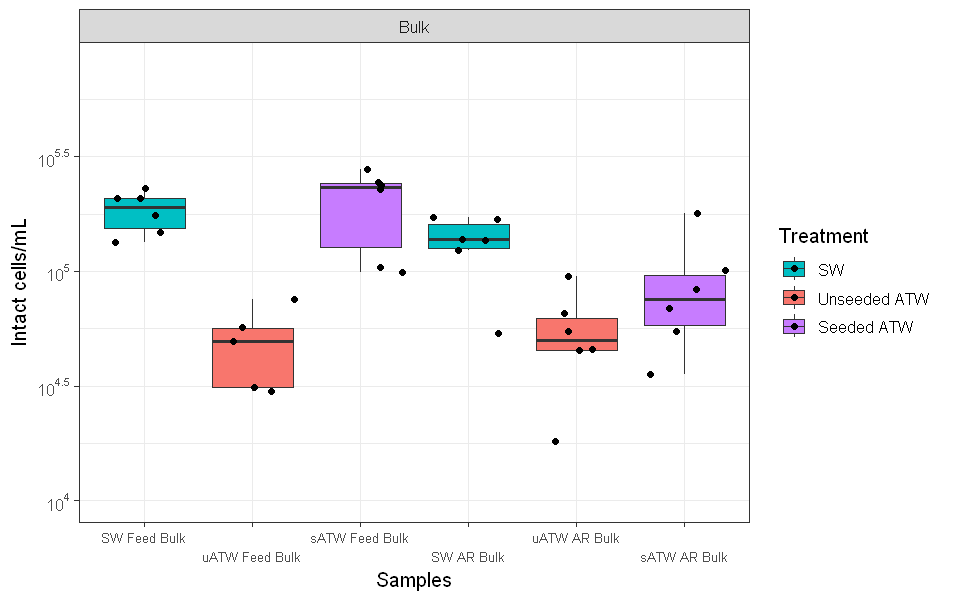

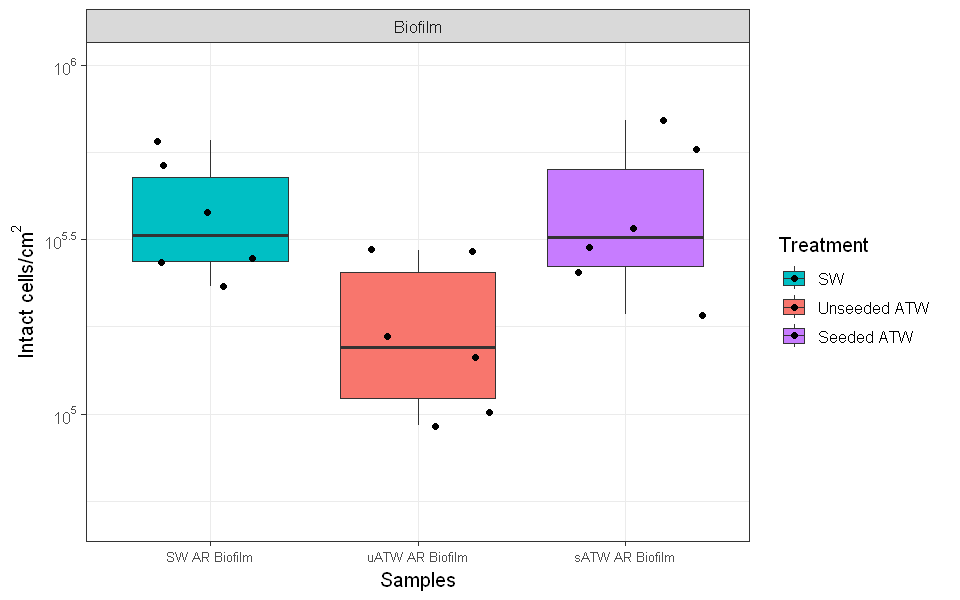

In [222]:
# plot boxplots of averaged reactors + feeds

a <- tot %>% filter( measurement == 'ICC') %>% filter( type == 'Bulk')
a <- a %>% filter( phase == 'Phase II' )

a<- a %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
a$Location <- factor(a$Location , levels=c('SW Feed Bulk', 'Unseeded ATW Feed Bulk', 'Seeded ATW Feed Bulk','SW AR Bulk', 'Unseeded ATW AR Bulk', 'Seeded ATW AR Bulk'))

a <- a %>% mutate(Location = recode(Location, 'Unseeded ATW AR Bulk' = 'uATW AR Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Bulk' = 'sATW AR Bulk')) %>% mutate(Location = recode(Location, 'Unseeded ATW Feed Bulk' = 'uATW Feed Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW Feed Bulk' = 'sATW Feed Bulk'))

a$Treatment <- factor(a$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

     


options(repr.plot.width = 8, repr.plot.height = 5)


box_ICC_bulk <- ggplot(a, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(1E4, 8E5), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(x="Samples", y="Intact cells/mL") + 
    facet_wrap('type', nrow=2, scales = "free") +
    scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
  
  
                                        
box_ICC_bulk
                                        

b <- tot %>% filter( measurement == 'ICC') %>% filter( type == 'Biofilm' )
b <- b %>% filter( phase == 'Phase II' )

b<- b %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
b$Location <- factor(b$Location , levels=c('SW AR Biofilm', 'Unseeded ATW AR Biofilm', 'Seeded ATW AR Biofilm'))

b <- b %>% mutate(Location = recode(Location, 'Unseeded ATW AR Biofilm' = 'uATW AR Biofilm')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Biofilm' = 'sATW AR Biofilm'))

b$Treatment <- factor(b$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

      


box_ICC_bf <- ggplot(b, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),limits=c(5E4, 1E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Samples", y=expression("Intact cells/cm"^2)) + 
    facet_wrap('type', nrow=2, scales = "free") +
    #scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_ICC_bf

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."


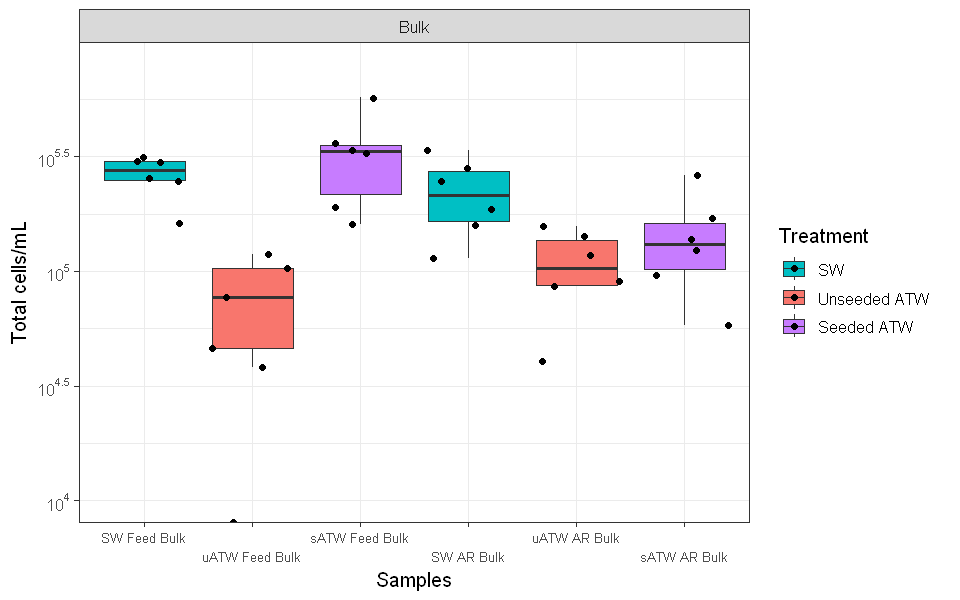

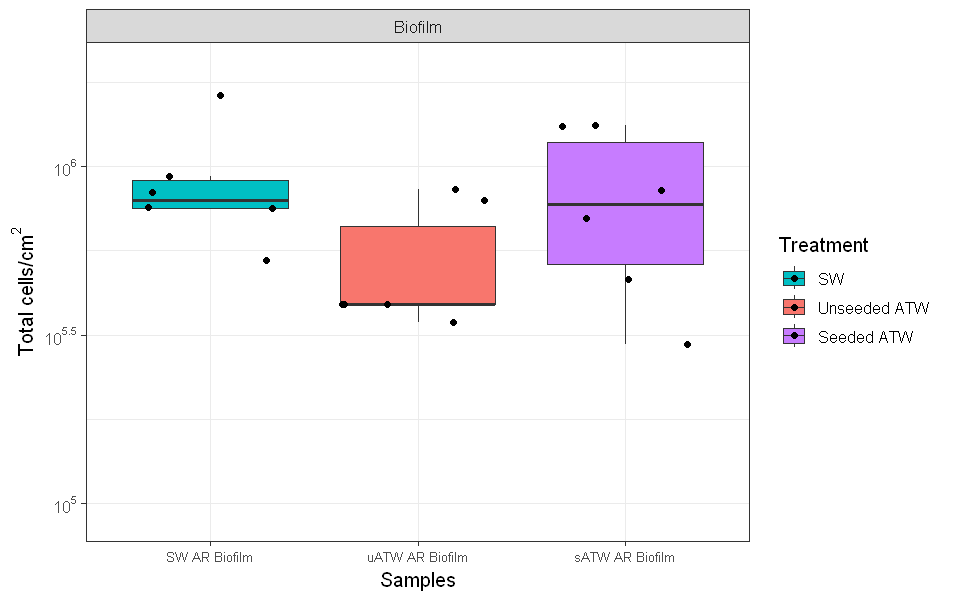

In [223]:
# plot boxplots of averaged reactors + feeds

a <- tot %>% filter( measurement == 'TCC') %>% filter( type == 'Bulk')
a <- a %>% filter( phase == 'Phase II' )

a<- a %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
a$Location <- factor(a$Location , levels=c('SW Feed Bulk', 'Unseeded ATW Feed Bulk', 'Seeded ATW Feed Bulk','SW AR Bulk', 'Unseeded ATW AR Bulk', 'Seeded ATW AR Bulk'))

a <- a %>% mutate(Location = recode(Location, 'Unseeded ATW AR Bulk' = 'uATW AR Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Bulk' = 'sATW AR Bulk')) %>% mutate(Location = recode(Location, 'Unseeded ATW Feed Bulk' = 'uATW Feed Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW Feed Bulk' = 'sATW Feed Bulk'))

a$Treatment <- factor(a$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

options(repr.plot.width = 8, repr.plot.height = 5)


box_TCC_bulk <- ggplot(a, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(1E4, 8E5), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(x="Samples", y="Total cells/mL") + 
    facet_wrap('type', nrow=2, scales = "free") +
    scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_TCC_bulk
                                        

b <- tot %>% filter( measurement == 'TCC') %>% filter( type == 'Biofilm' )
b <- b %>% filter( phase == 'Phase II' )

b<- b %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
b$Location <- factor(b$Location , levels=c('SW AR Biofilm', 'Unseeded ATW AR Biofilm', 'Seeded ATW AR Biofilm'))

b <- b %>% mutate(Location = recode(Location, 'Unseeded ATW AR Biofilm' = 'uATW AR Biofilm')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Biofilm' = 'sATW AR Biofilm'))

b$Treatment <- factor(b$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

  
#options(repr.plot.width = 8, repr.plot.height = 8)



box_TCC_bf <- ggplot(b, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),limits=c(9E4, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Samples", y=expression("Total cells/cm"^2)) + 
    facet_wrap('type', nrow=2, scales = "free") +
    #scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_TCC_bf

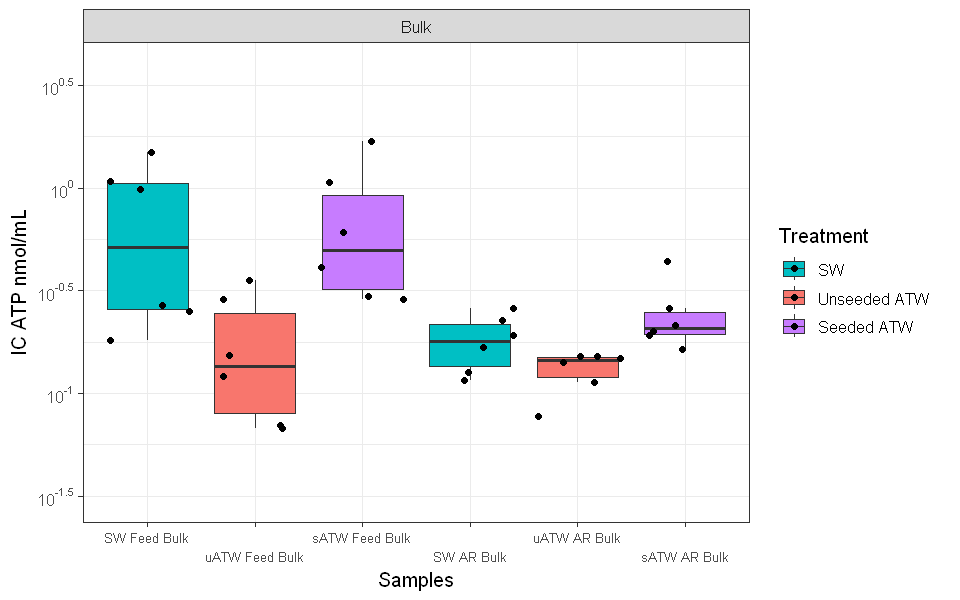

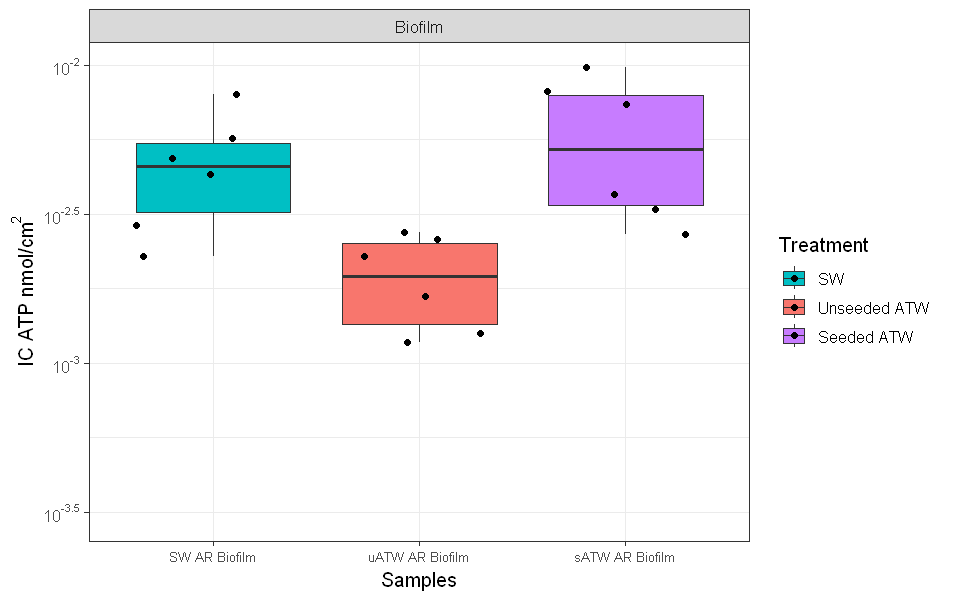

In [224]:
# plot boxplots of averaged reactors + feeds

a <- tot %>% filter( measurement == 'IC ATP') %>% filter( type == 'Bulk')
a <- a %>% filter( phase == 'Phase II' )

a<- a %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
a$Location <- factor(a$Location , levels=c('SW Feed Bulk', 'Unseeded ATW Feed Bulk', 'Seeded ATW Feed Bulk','SW AR Bulk', 'Unseeded ATW AR Bulk', 'Seeded ATW AR Bulk'))

a <- a %>% mutate(Location = recode(Location, 'Unseeded ATW AR Bulk' = 'uATW AR Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Bulk' = 'sATW AR Bulk')) %>% mutate(Location = recode(Location, 'Unseeded ATW Feed Bulk' = 'uATW Feed Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW Feed Bulk' = 'sATW Feed Bulk'))

a$Treatment <- factor(a$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

options(repr.plot.width = 8, repr.plot.height = 5)


box_iatp_bulk <- ggplot(a, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-2, 4E0),labels = trans_format("log10", math_format(10^.x)))+ 
    labs(x="Samples", y="IC ATP nmol/mL") + 
    facet_wrap('type', nrow=2, scales = "free") +
    scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_iatp_bulk
                                        

b <- tot %>% filter( measurement == 'IC ATP') %>% filter( type == 'Biofilm' )
b <- b %>% filter( phase == 'Phase II' )

b<- b %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
b$Location <- factor(b$Location , levels=c('SW AR Biofilm', 'Unseeded ATW AR Biofilm', 'Seeded ATW AR Biofilm'))

b <- b %>% mutate(Location = recode(Location, 'Unseeded ATW AR Biofilm' = 'uATW AR Biofilm')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Biofilm' = 'sATW AR Biofilm'))

b$Treatment <- factor(b$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

                                       
#options(repr.plot.width = 8, repr.plot.height = 8)



box_iatp_bf <- ggplot(b, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-4, 1E-2), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Samples", y=expression("IC ATP nmol/cm"^2)) + 
    facet_wrap('type', nrow=2, scales = "free") +
    #scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_iatp_bf

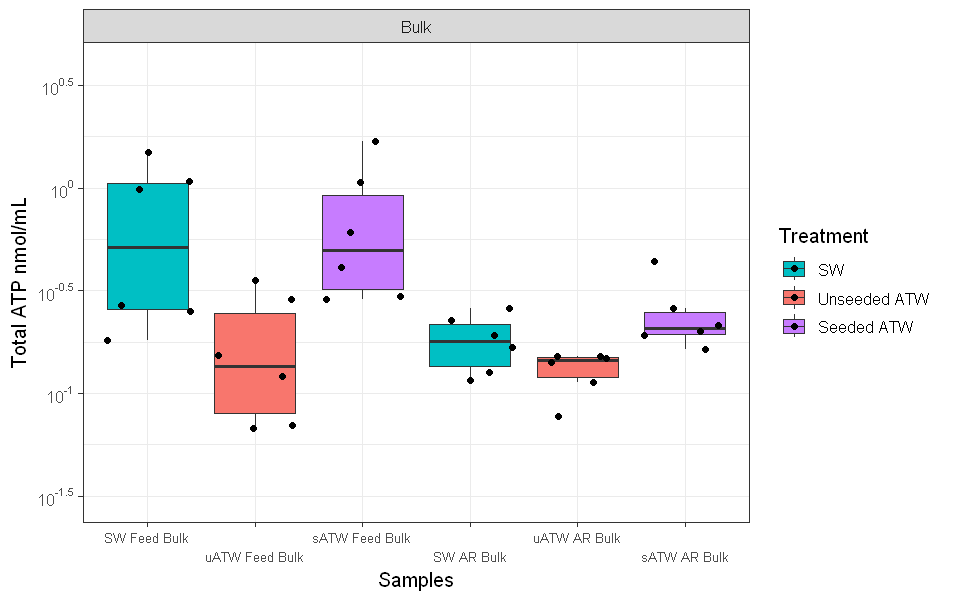

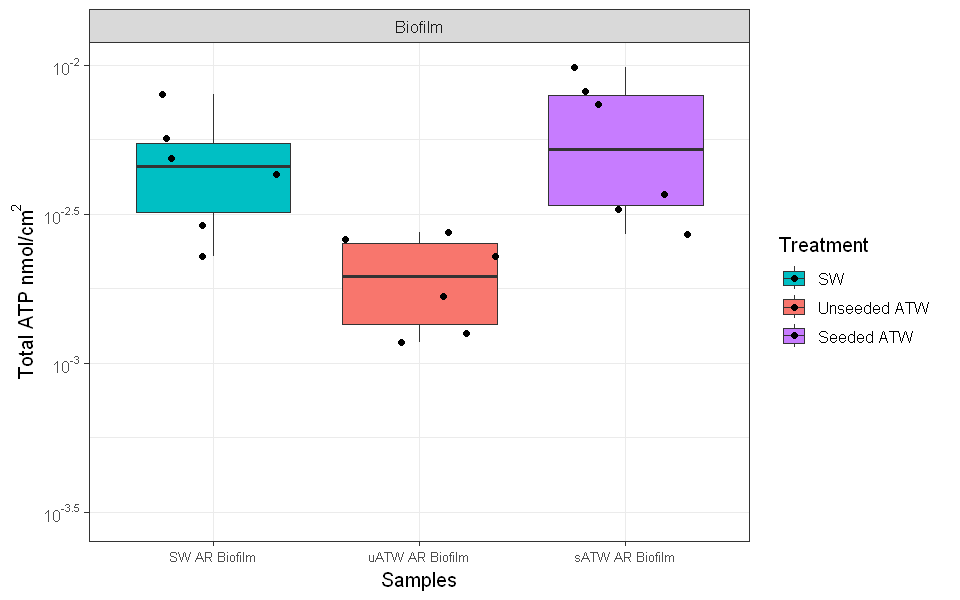

In [225]:
# plot boxplots of averaged reactors + feeds

a <- tot %>% filter( measurement == 'Total ATP') %>% filter( type == 'Bulk')
a <- a %>% filter( phase == 'Phase II' )

a<- a %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
a$Location <- factor(a$Location , levels=c('SW Feed Bulk', 'Unseeded ATW Feed Bulk', 'Seeded ATW Feed Bulk','SW AR Bulk', 'Unseeded ATW AR Bulk', 'Seeded ATW AR Bulk'))

a <- a %>% mutate(Location = recode(Location, 'Unseeded ATW AR Bulk' = 'uATW AR Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Bulk' = 'sATW AR Bulk')) %>% mutate(Location = recode(Location, 'Unseeded ATW Feed Bulk' = 'uATW Feed Bulk')) %>% mutate(Location = recode(Location, 'Seeded ATW Feed Bulk' = 'sATW Feed Bulk'))

a$Treatment <- factor(a$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

options(repr.plot.width = 8, repr.plot.height = 5)


box_tatp_bulk <- ggplot(a, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-2, 4E0),labels = trans_format("log10", math_format(10^.x)))+ 
    labs(x="Samples", y="Total ATP nmol/mL") + 
    facet_wrap('type', nrow=2, scales = "free") +
    scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_tatp_bulk
                                        

b <- tot %>% filter( measurement == 'Total ATP') %>% filter( type == 'Biofilm' )
b <- b %>% filter( phase == 'Phase II' )

b<- b %>% mutate( Location = paste( Treatment,Sample_Type,type, sep = " "))
b$Location <- factor(b$Location , levels=c('SW AR Biofilm', 'Unseeded ATW AR Biofilm', 'Seeded ATW AR Biofilm'))

b <- b %>% mutate(Location = recode(Location, 'Unseeded ATW AR Biofilm' = 'uATW AR Biofilm')) %>% mutate(Location = recode(Location, 'Seeded ATW AR Biofilm' = 'sATW AR Biofilm'))

b$Treatment <- factor(b$Treatment , levels=c('SW', 'Unseeded ATW', 'Seeded ATW'))

#options(repr.plot.width = 8, repr.plot.height = 8)



box_tatp_bf <- ggplot(b, aes(x= Location, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits=c(3E-4, 1E-2), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Samples", y=expression("Total ATP nmol/cm"^2)) + 
    facet_wrap('type', nrow=2, scales = "free") +
    #scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    theme_bw(base_size = 12 )+
    theme(axis.text.x = element_text( size=8)) 
    
                                        
box_tatp_bf

### Combine Time Series/Boxplots

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned."


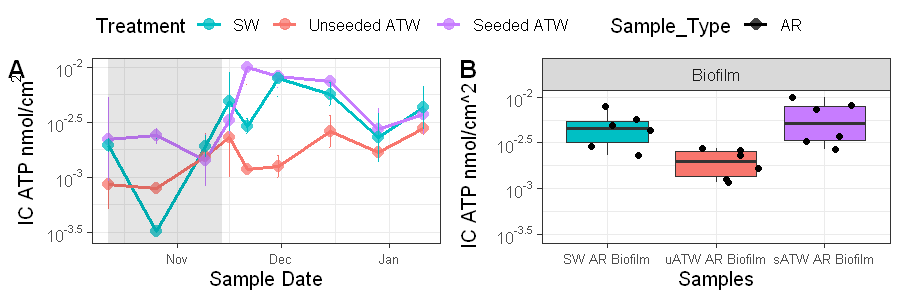

In [449]:
options(repr.plot.width = 7.5, repr.plot.height =2.5)
fig_pres<- ggarrange( plot_iatp_bf,  box_iatp_bf, ncol=2, nrow=1, labels= c("A", "B"), font.label = list(size = 15, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_pres

ggsave(paste0(fig_dir, 'fig_pres.png'), width=7.5, height=2.5)

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks =

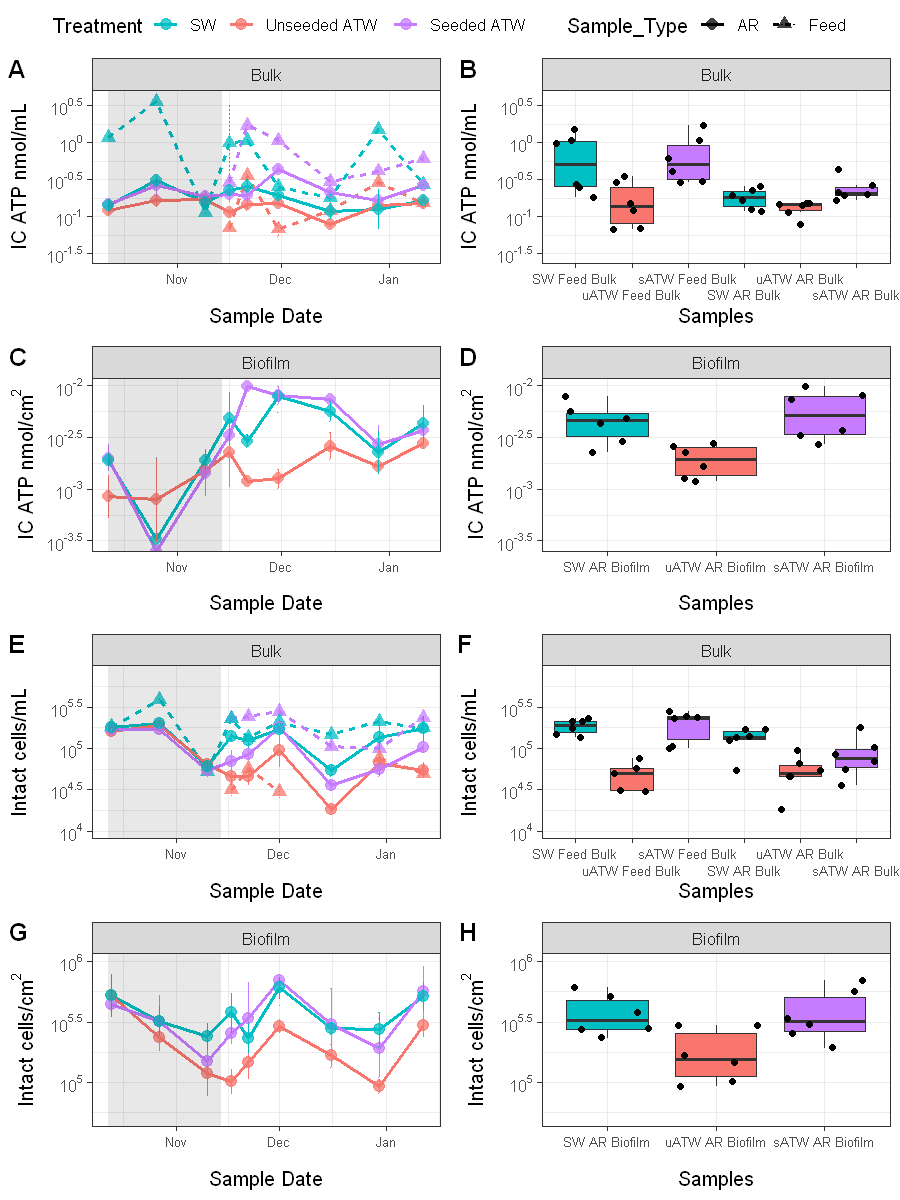

In [226]:
options(repr.plot.width = 7.5, repr.plot.height =10)
fig_2<- ggarrange(plot_iatp_bulk,box_iatp_bulk, plot_iatp_bf,  box_iatp_bf, plot_icc_bulk,box_ICC_bulk, plot_icc_bf, box_ICC_bf, ncol=2, nrow=4, labels= c("A", "B", "C", "D","E","F","G","H"), font.label = list(size = 15, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_2

ggsave(paste0(fig_dir, 'fig_2.png'), width=7.5, height=10)
ggsave(paste0(fig_dir, 'fig_2.svg'), width=7.5, height=10)

Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks =

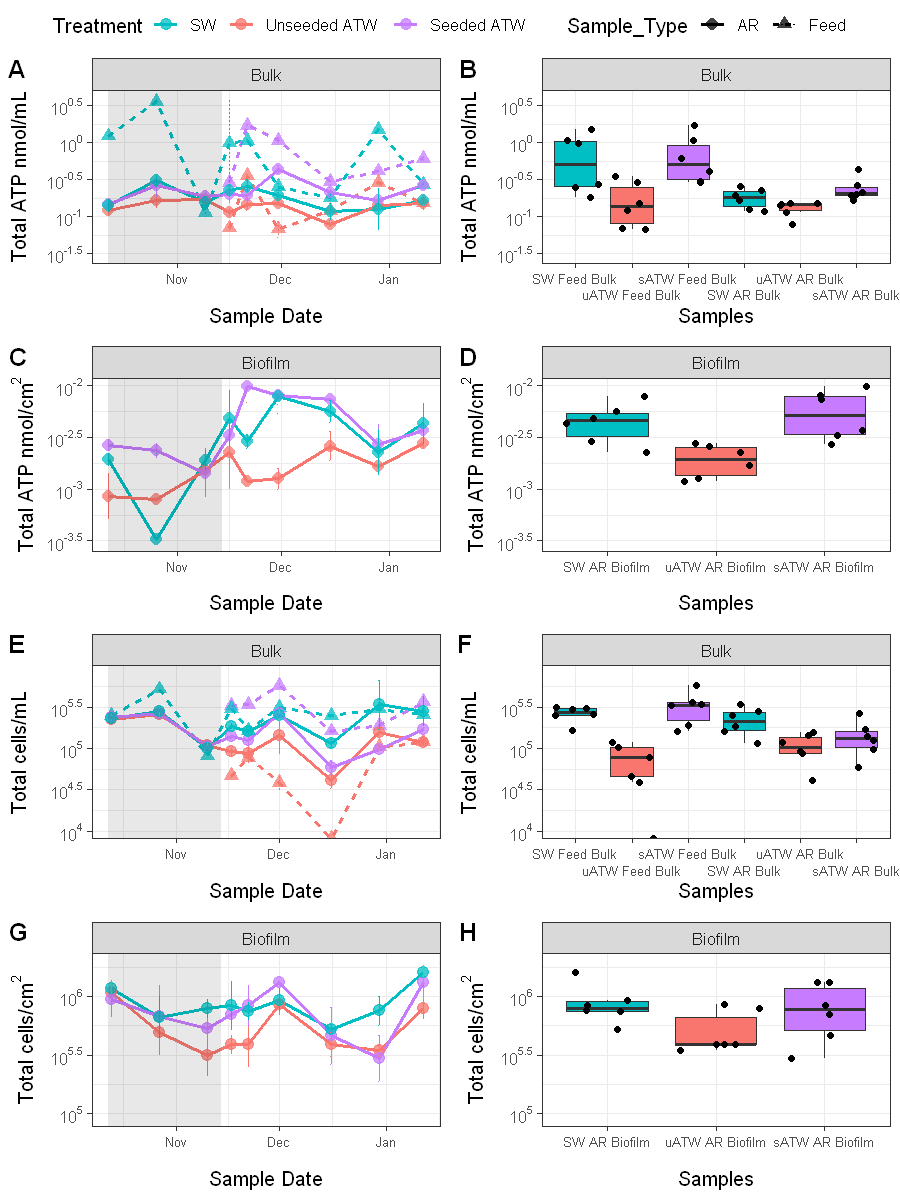

In [227]:
options(repr.plot.width = 7.5, repr.plot.height =10)
fig_s6<- ggarrange(plot_tatp_bulk,box_tatp_bulk, plot_tatp_bf,  box_tatp_bf, plot_tcc_bulk,box_TCC_bulk, plot_tcc_bf, box_TCC_bf, ncol=2, nrow=4, labels= c("A", "B", "C", "D","E","F","G","H"), font.label = list(size = 15, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_s6

ggsave(paste0(fig_dir, 'fig_s6.png'), width=7.5, height=10)
ggsave(paste0(fig_dir, 'fig_s6.svg'), width=7.5, height=10)


## By Reactors

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


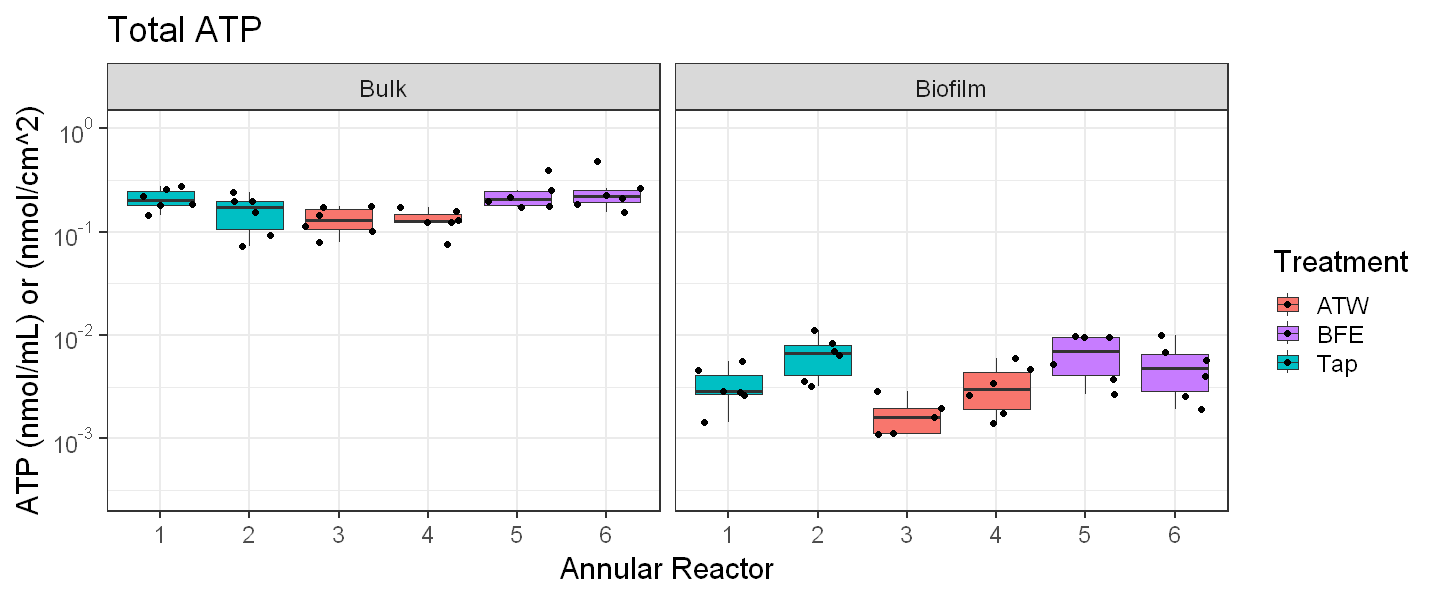

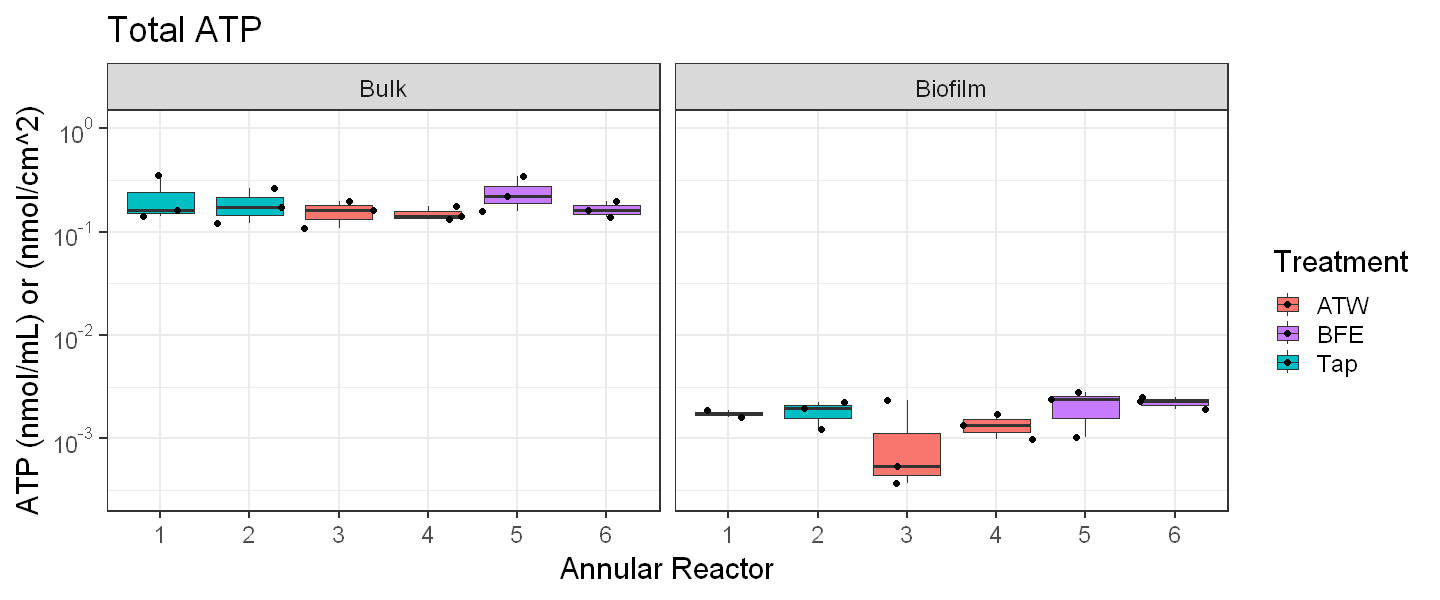

In [234]:
# plot boxplots of ICC in each biofilm

options(repr.plot.width = 12, repr.plot.height =5)

a <- tot_un %>% filter( measurement == 'Total ATP', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
a <- a %>% filter( phase == 'Phase II' )
a$type <- factor(a$type , levels=c('Bulk', 'Biofilm'))

fig_bf_tatp_2 <- ggplot(a, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(3E-4, 1E0), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "Total ATP", x="Annular Reactor", y="ATP (nmol/mL) or (nmol/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_tatp_2
                                        

a <- tot_un %>% filter( measurement == 'Total ATP', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
a <- a %>% filter( phase == 'Phase I' )
a$type <- factor(a$type , levels=c('Bulk', 'Biofilm'))

fig_bf_tatp_1 <- ggplot(a, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(3E-4, 1E0), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "Total ATP", x="Annular Reactor", y="ATP (nmol/mL) or (nmol/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_tatp_1                                  

  

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


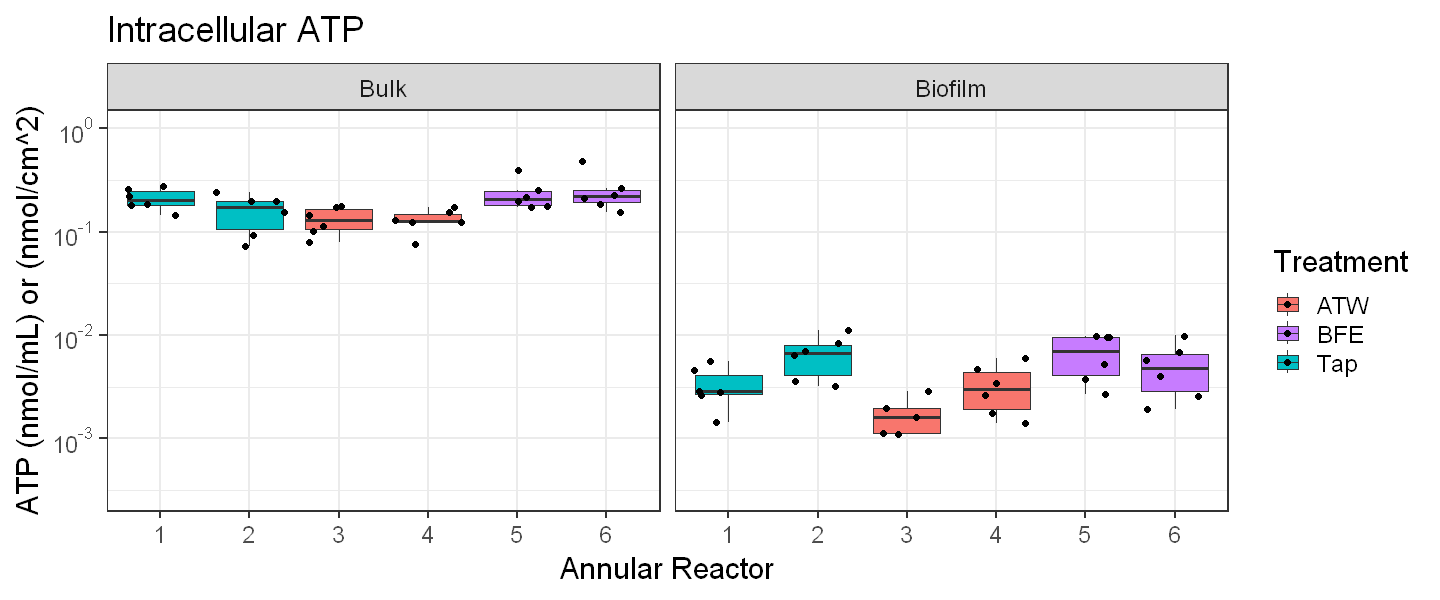

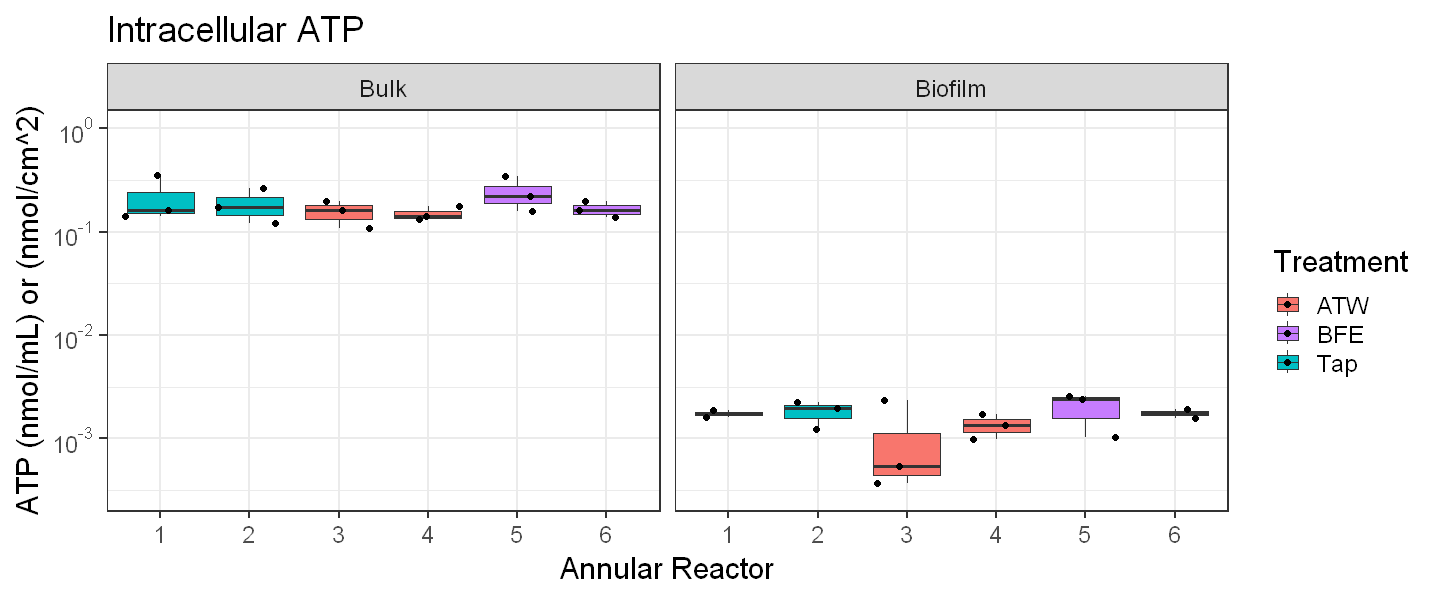

In [235]:
b <- tot_un %>% filter( measurement == 'IC ATP', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
b <- b %>% filter( phase == 'Phase II' )
b$type <- factor(b$type , levels=c('Bulk', 'Biofilm'))

fig_bf_iatp_2 <- ggplot(b, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(3E-4, 1E0), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "Intracellular ATP", x="Annular Reactor", y="ATP (nmol/mL) or (nmol/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_iatp_2  
                                        
b <- tot_un %>% filter( measurement == 'IC ATP', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
b <- b %>% filter( phase == 'Phase I' )
b$type <- factor(b$type , levels=c('Bulk', 'Biofilm'))

fig_bf_iatp_1 <- ggplot(b, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(3E-4, 1E0), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "Intracellular ATP", x="Annular Reactor", y="ATP (nmol/mL) or (nmol/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_iatp_1                                          

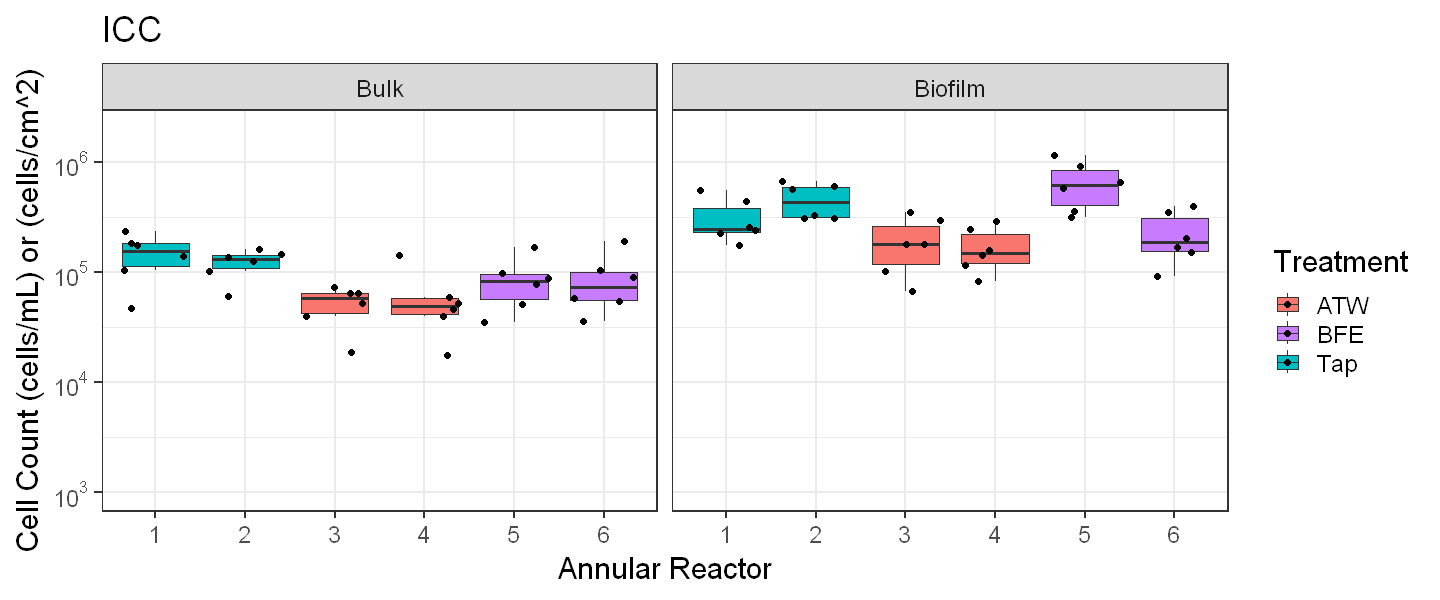

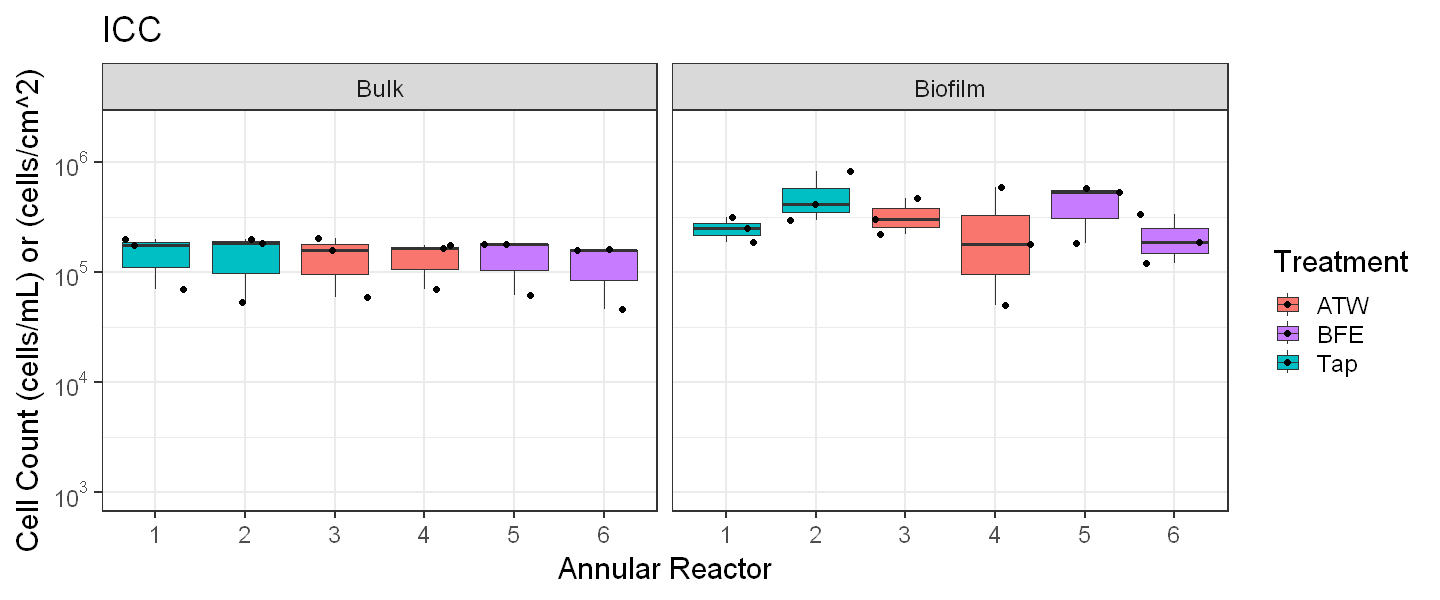

In [236]:
c <- tot_un %>% filter( measurement == 'ICC', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
c <- c %>% filter( phase == 'Phase II' )
c$type <- factor(c$type , levels=c('Bulk', 'Biofilm'))

fig_bf_icc_2 <- ggplot(c, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "ICC", x="Annular Reactor", y="Cell Count (cells/mL) or (cells/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_icc_2 
                                        
c <- tot_un %>% filter( measurement == 'ICC', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
c <- c %>% filter( phase == 'Phase I' )
c$type <- factor(c$type , levels=c('Bulk', 'Biofilm'))

fig_bf_icc_1 <- ggplot(c, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "ICC", x="Annular Reactor", y="Cell Count (cells/mL) or (cells/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_icc_1                                         

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


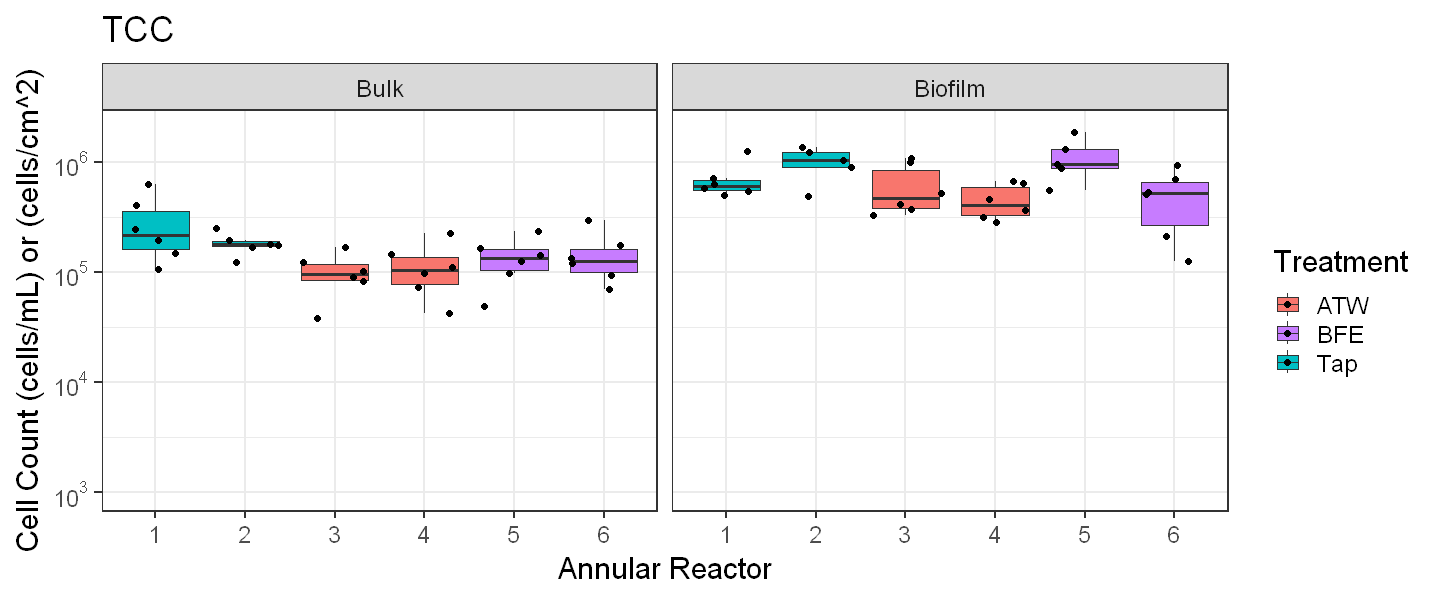

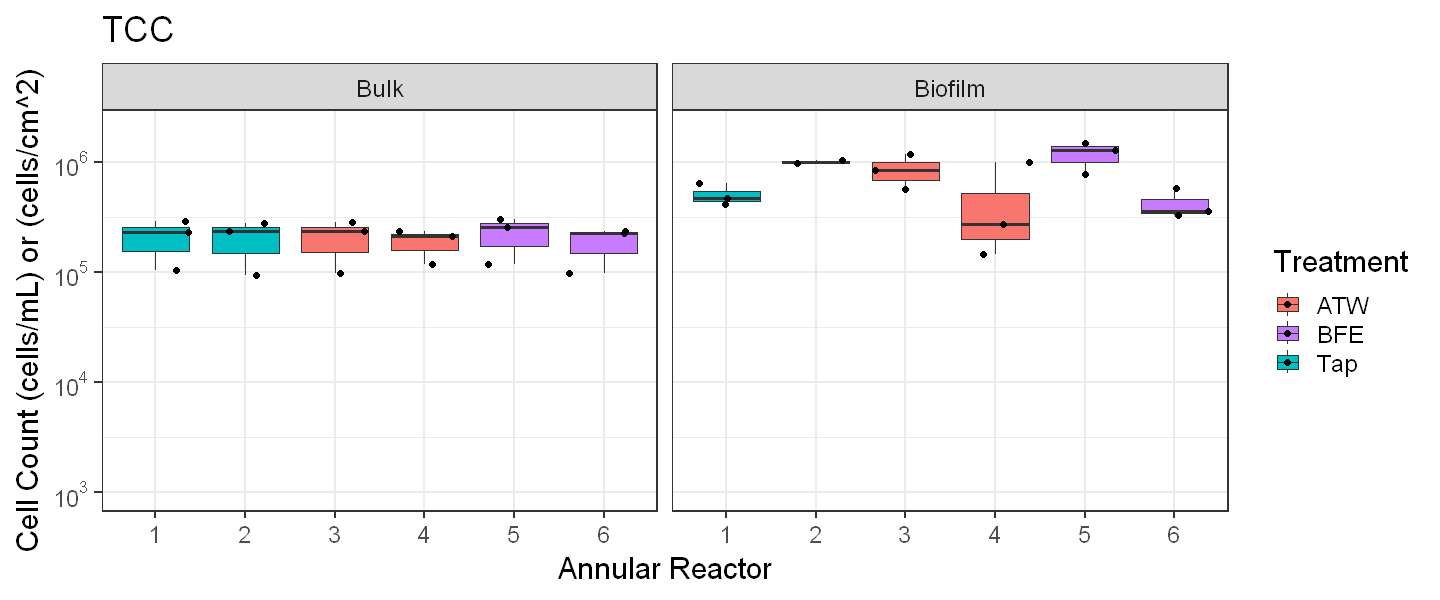

In [237]:
d <- tot_un %>% filter( measurement == 'TCC', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
d <- d %>% filter( phase == 'Phase II' )
d$type <- factor(d$type , levels=c('Bulk', 'Biofilm'))

fig_bf_tcc_2 <- ggplot(d, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "TCC", x="Annular Reactor", y="Cell Count (cells/mL) or (cells/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_tcc_2
                                        
d <- tot_un %>% filter( measurement == 'TCC', samples_type == 'AR') %>% filter( type == 'Biofilm' | type == 'Bulk')
d <- d %>% filter( phase == 'Phase I' )
d$type <- factor(d$type , levels=c('Bulk', 'Biofilm'))

fig_bf_tcc_1 <- ggplot(d, aes(x= Number, y= geomean_blanked, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    labs(title = "TCC", x="Annular Reactor", y="Cell Count (cells/mL) or (cells/cm^2)") + 
    facet_wrap(~type, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_tcc_1                                           

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


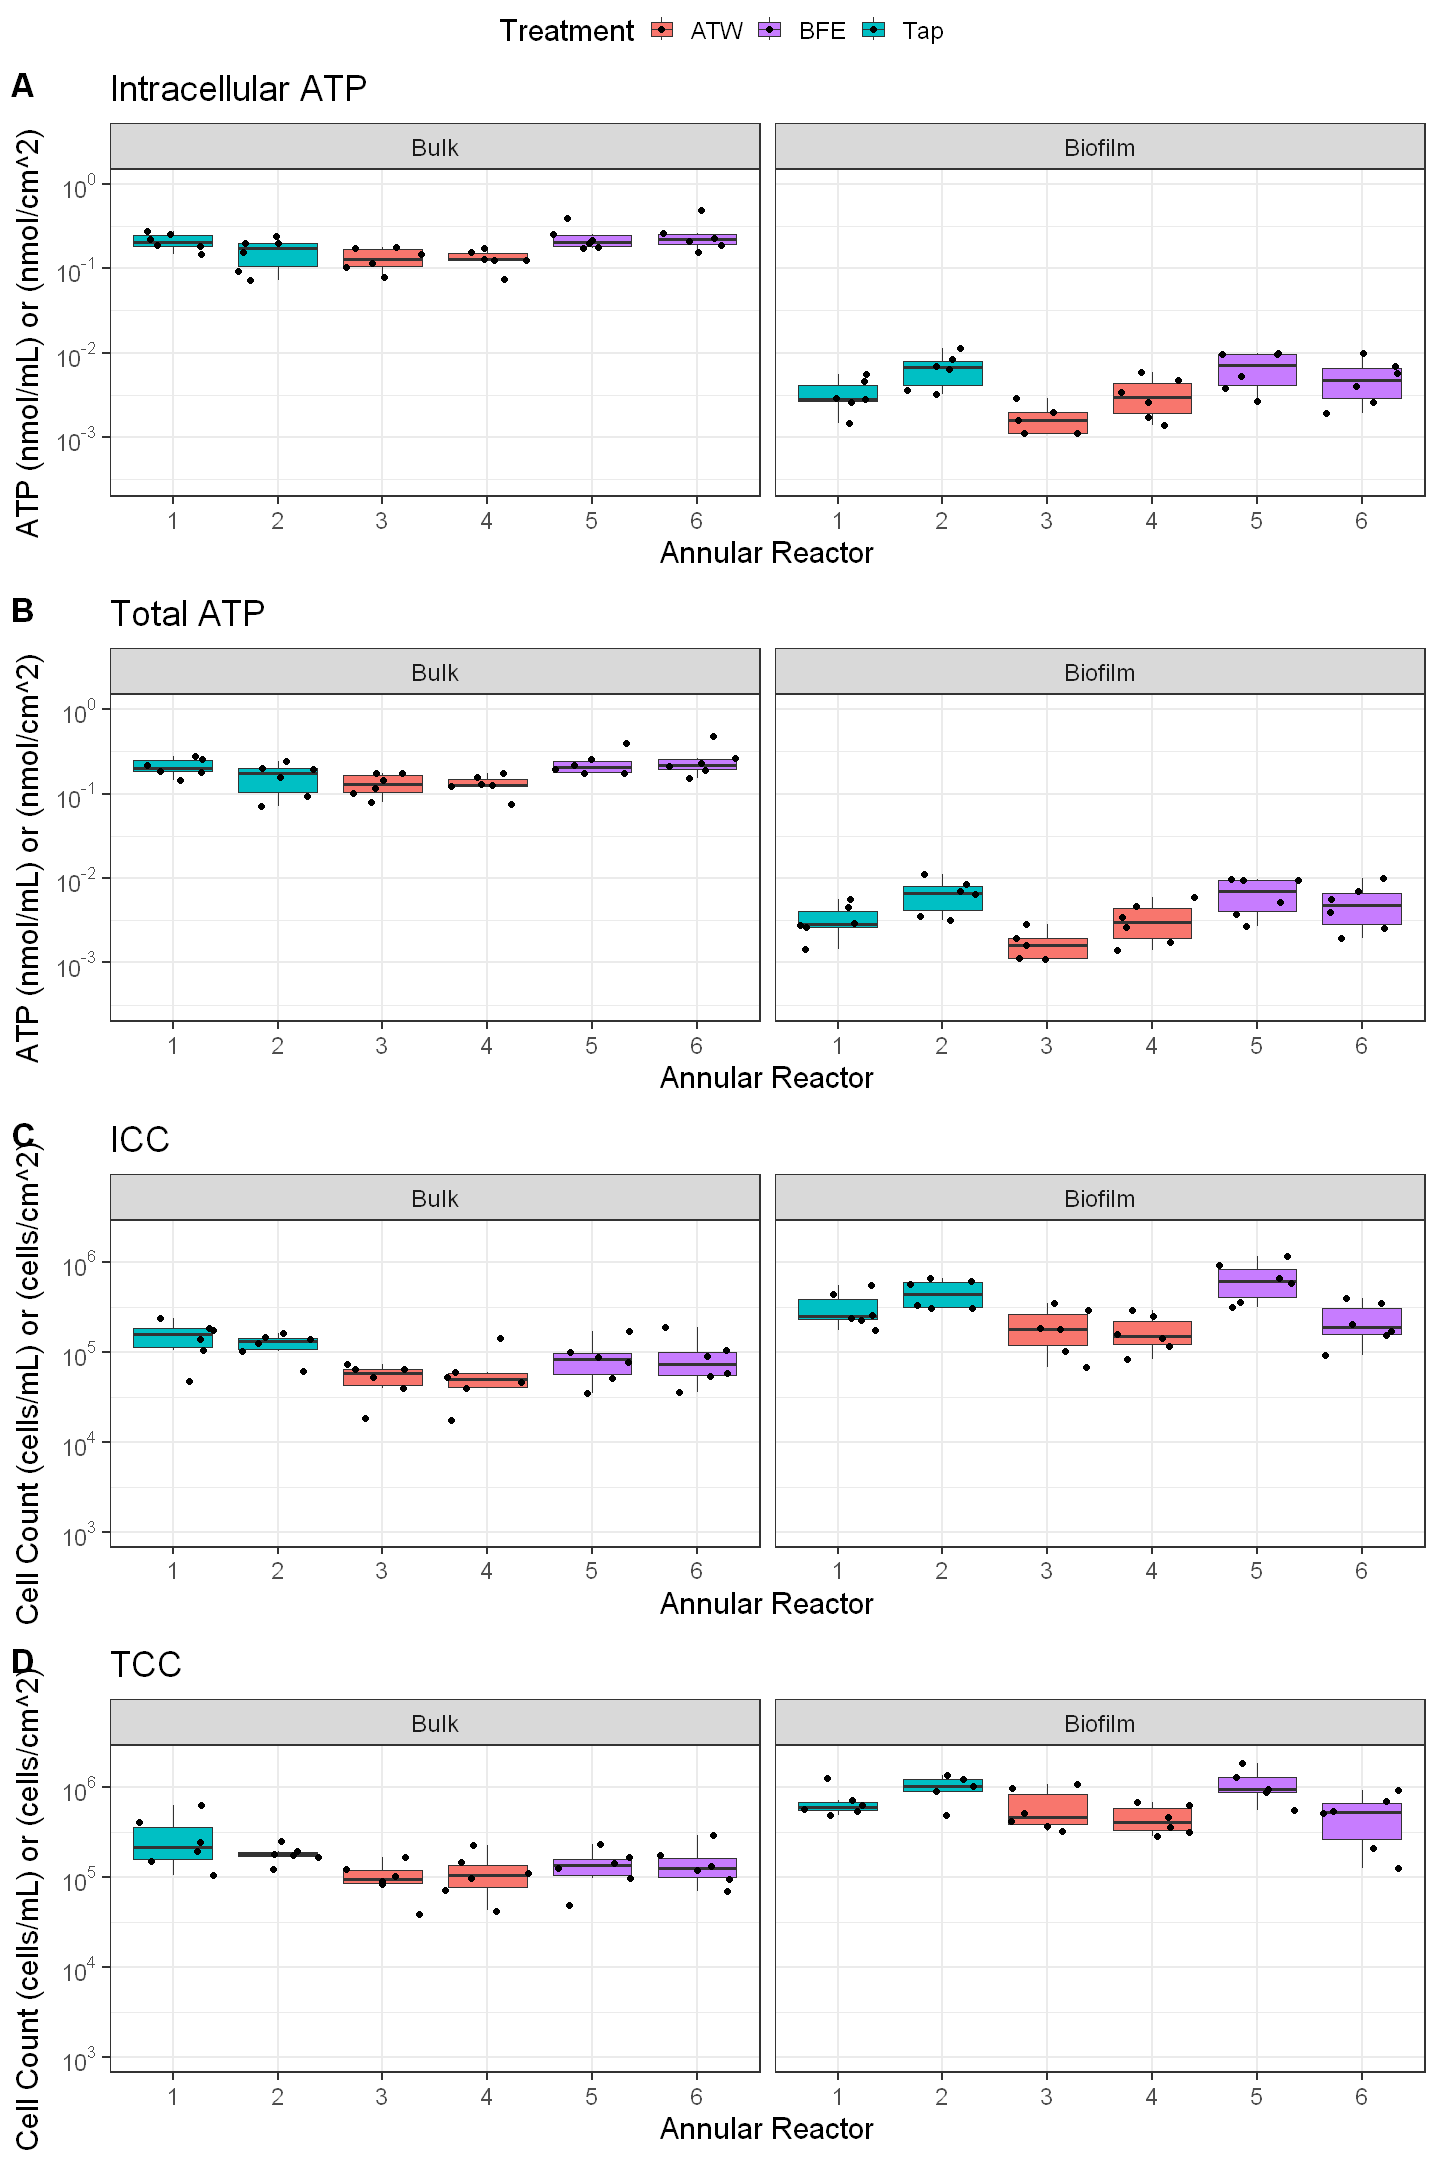

In [242]:
options(repr.plot.width = 12, repr.plot.height =18)
#fig_s7<- ggarrange( fig_bf_iatp_2, fig_bf_tatp_2, fig_bf_icc_2, fig_bf_tcc_2, ncol=1, nrow=4, labels= c("A", "B", "C", "D"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
#fig_s7

#ggsave(paste0(fig_dir, 'fig_s7.png'), width=12, height=18)


Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced in

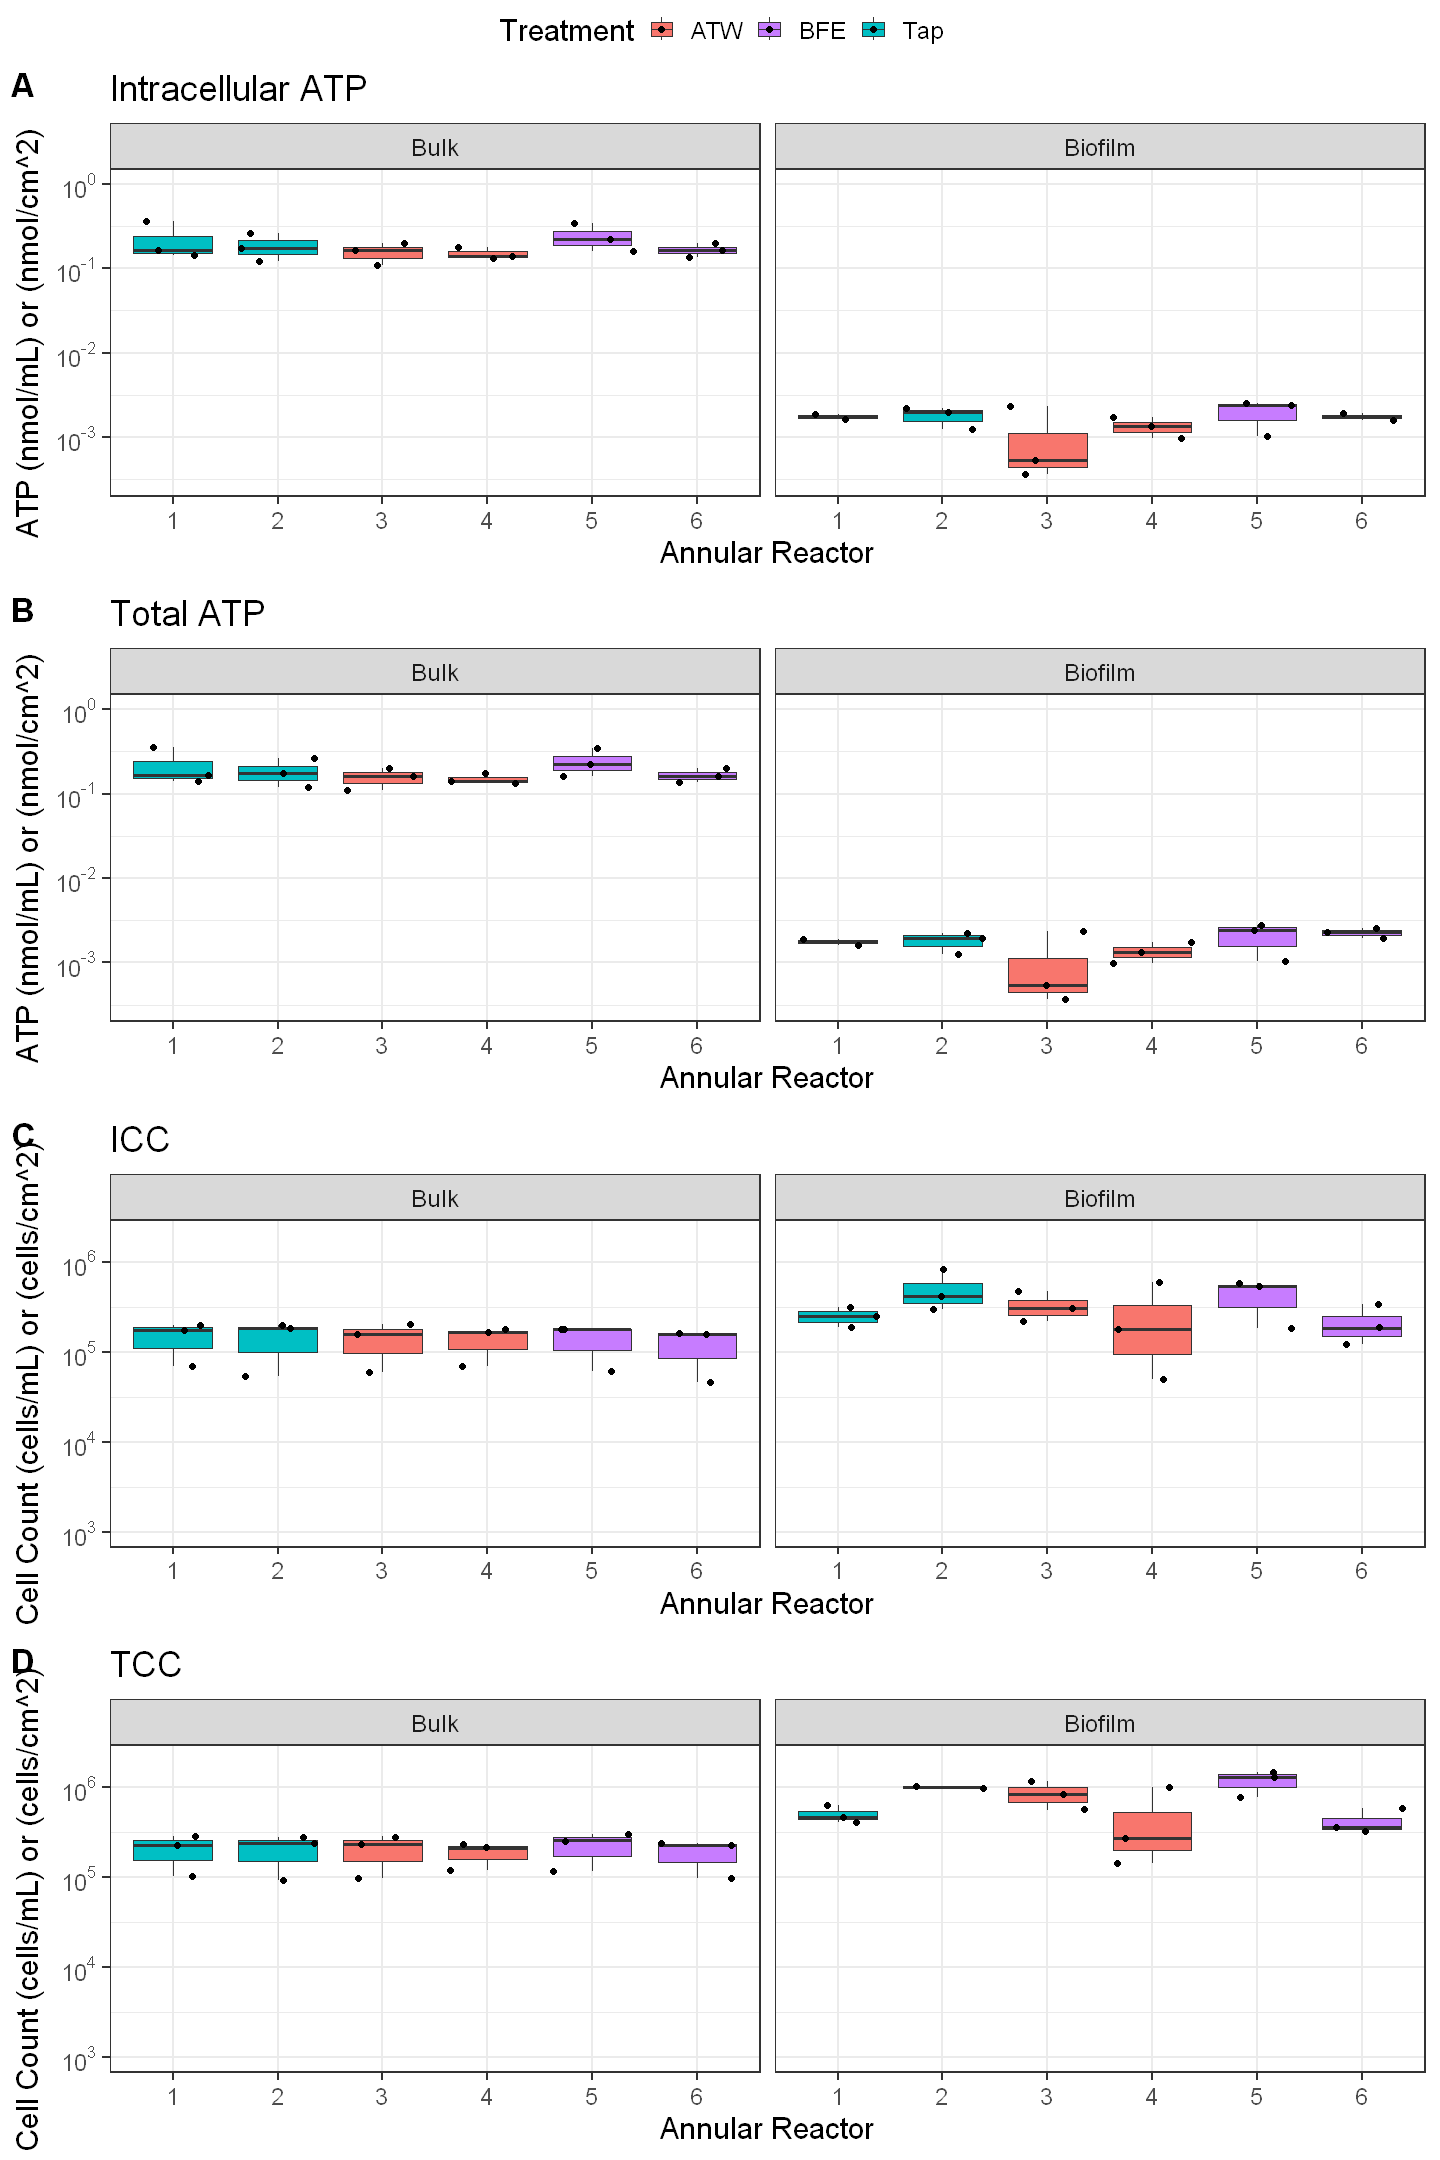

In [245]:
options(repr.plot.width = 12, repr.plot.height =18)
fig_s8<- ggarrange( fig_bf_iatp_1, fig_bf_tatp_1, fig_bf_icc_1, fig_bf_tcc_1, ncol=1, nrow=4, labels= c("A", "B", "C", "D"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_s8

ggsave(paste0(fig_dir, 'fig_s8.png'), width=12, height=18)


## Media

In [467]:
FCM_df <- FCM_mean_wb   #  FCM_mean
FCM_TCC <- FCM_df %>% filter(Stain=='SG') %>% mutate(measurement= 'TCC') %>% ungroup() %>% select(- "Stain")
FCM_ICC <- FCM_df %>% filter(Stain=='SGPI') %>% mutate(measurement= 'ICC') %>% ungroup() %>% select(- "Stain")
FCM_df <- rbind(FCM_TCC,FCM_ICC) 
FCM_df$Date <- FCM_df$Date -1
ATP <- ATP_mean_wb   %>% rename(Date = sample_date)

#ATP_mean

#Combine
tot_wb <- rbind(FCM_df, ATP)
tot_wb["phase"] <- "Est. Phase"
tot_wb$phase[tot_wb$Date > as.Date('2022-11-14')] <- "Exp. Phase"
tot_wb$phase <- factor(tot_wb$phase, levels = c("Est. Phase","Exp. Phase"))
# Reorder in specific order
specific_order <- c('IC ATP', 'Total ATP', 'ICC', 'TCC')
tot_wb$measurement <- factor(tot_wb$measurement, levels = specific_order)

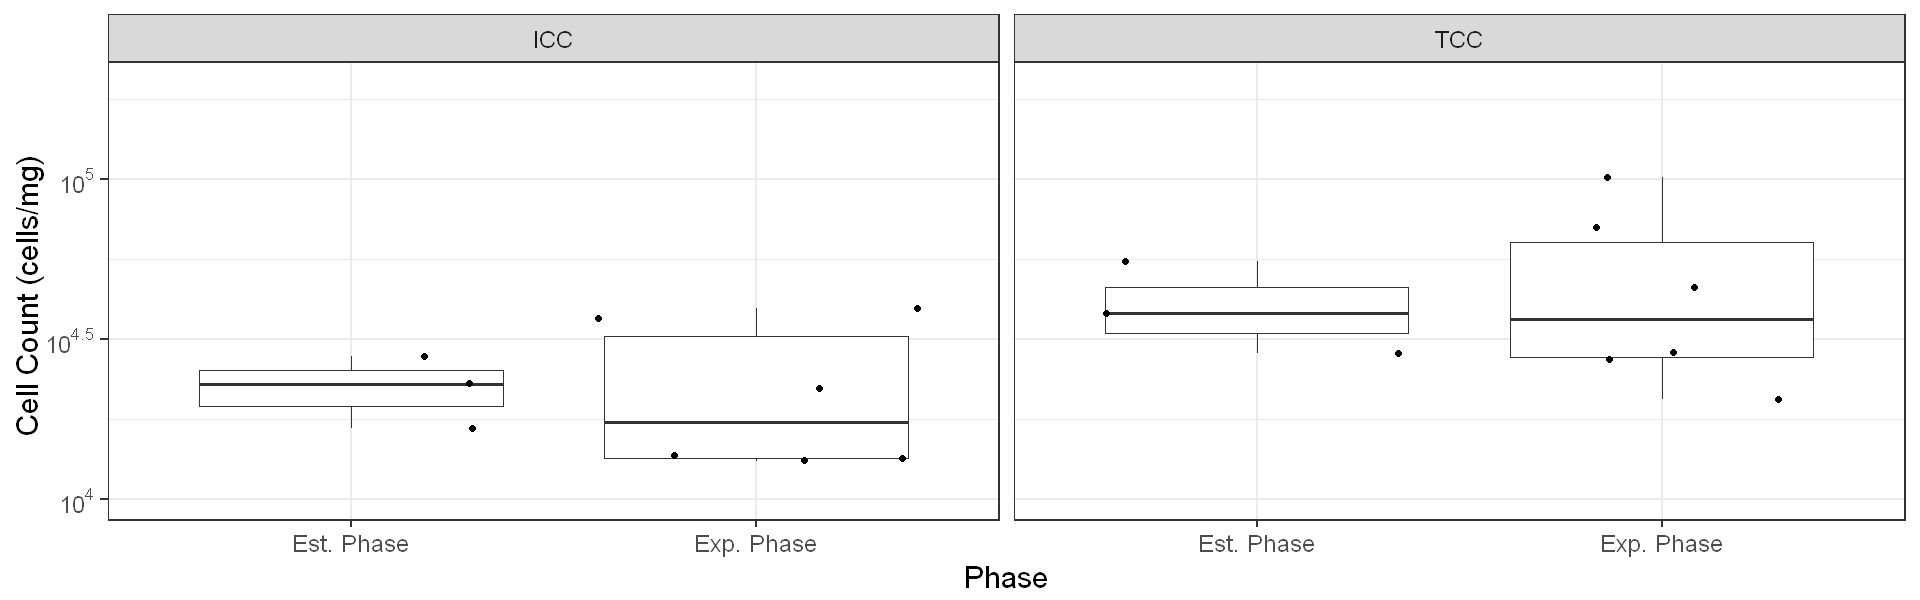

In [468]:
d <- tot_wb %>% filter(Sample_Type == 'Media') %>% filter(measurement == 'ICC' | measurement =='TCC')
options(repr.plot.width = 16, repr.plot.height = 5)

fig_bf_tcc <- ggplot(d, aes(x= phase, y= geomean_blanked))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    #scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E4, 2E5), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Phase", y="Cell Count (cells/mg) ") + 
    facet_wrap(~measurement, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_tcc                                              

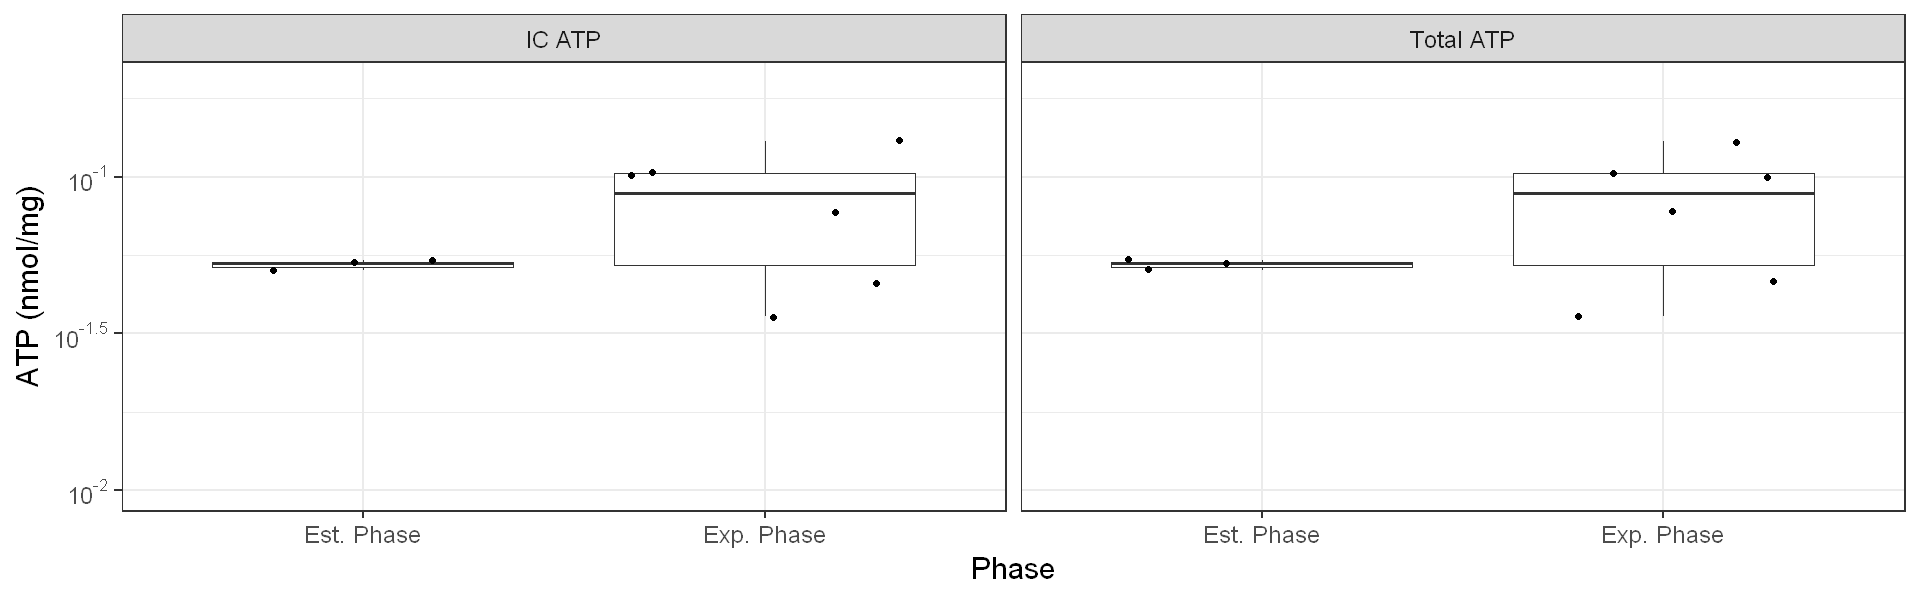

In [469]:
d <- tot_wb %>% filter(Sample_Type == 'Media') %>% filter(measurement == 'IC ATP' | measurement =='Total ATP')
options(repr.plot.width = 16, repr.plot.height = 5)

fig_bf_atp <- ggplot(d, aes(x= phase, y= geomean_blanked))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    #scale_fill_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E-2, 2E-1), labels = trans_format("log10", math_format(10^.x)))+ 
    labs( x="Phase", y="ATP (nmol/mg)") + 
    facet_wrap(~measurement, scales= "fixed", ncol=2) +
    #geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.1)+
    #geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
    #        ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_atp                                           

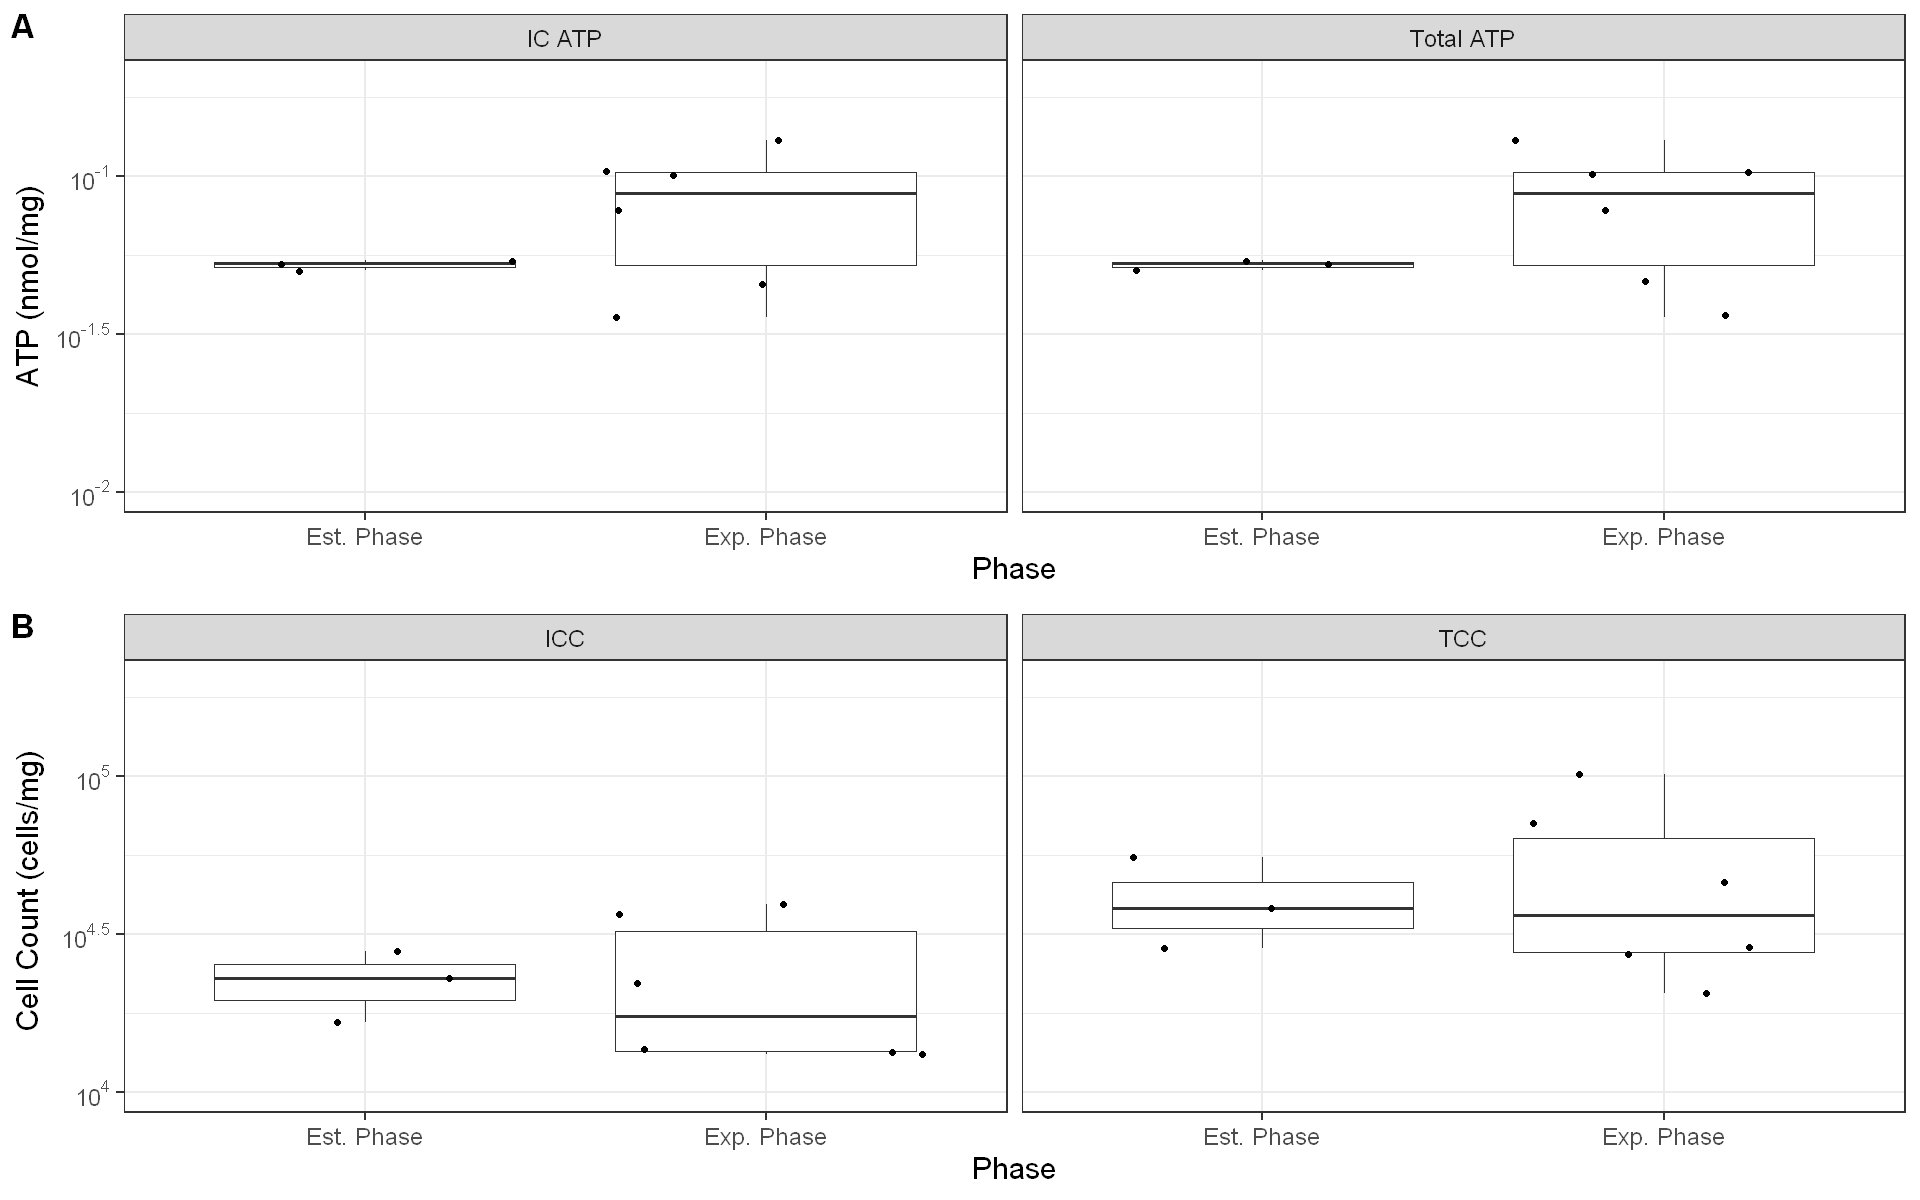

In [470]:
options(repr.plot.width = 16, repr.plot.height =10)
fig_s9<- ggarrange( fig_bf_atp, fig_bf_tcc,  ncol=1, nrow=2, labels= c("A", "B"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_s9

ggsave(paste0(fig_dir, 'fig_s9.png'), width=16, height=10)


## By Phase

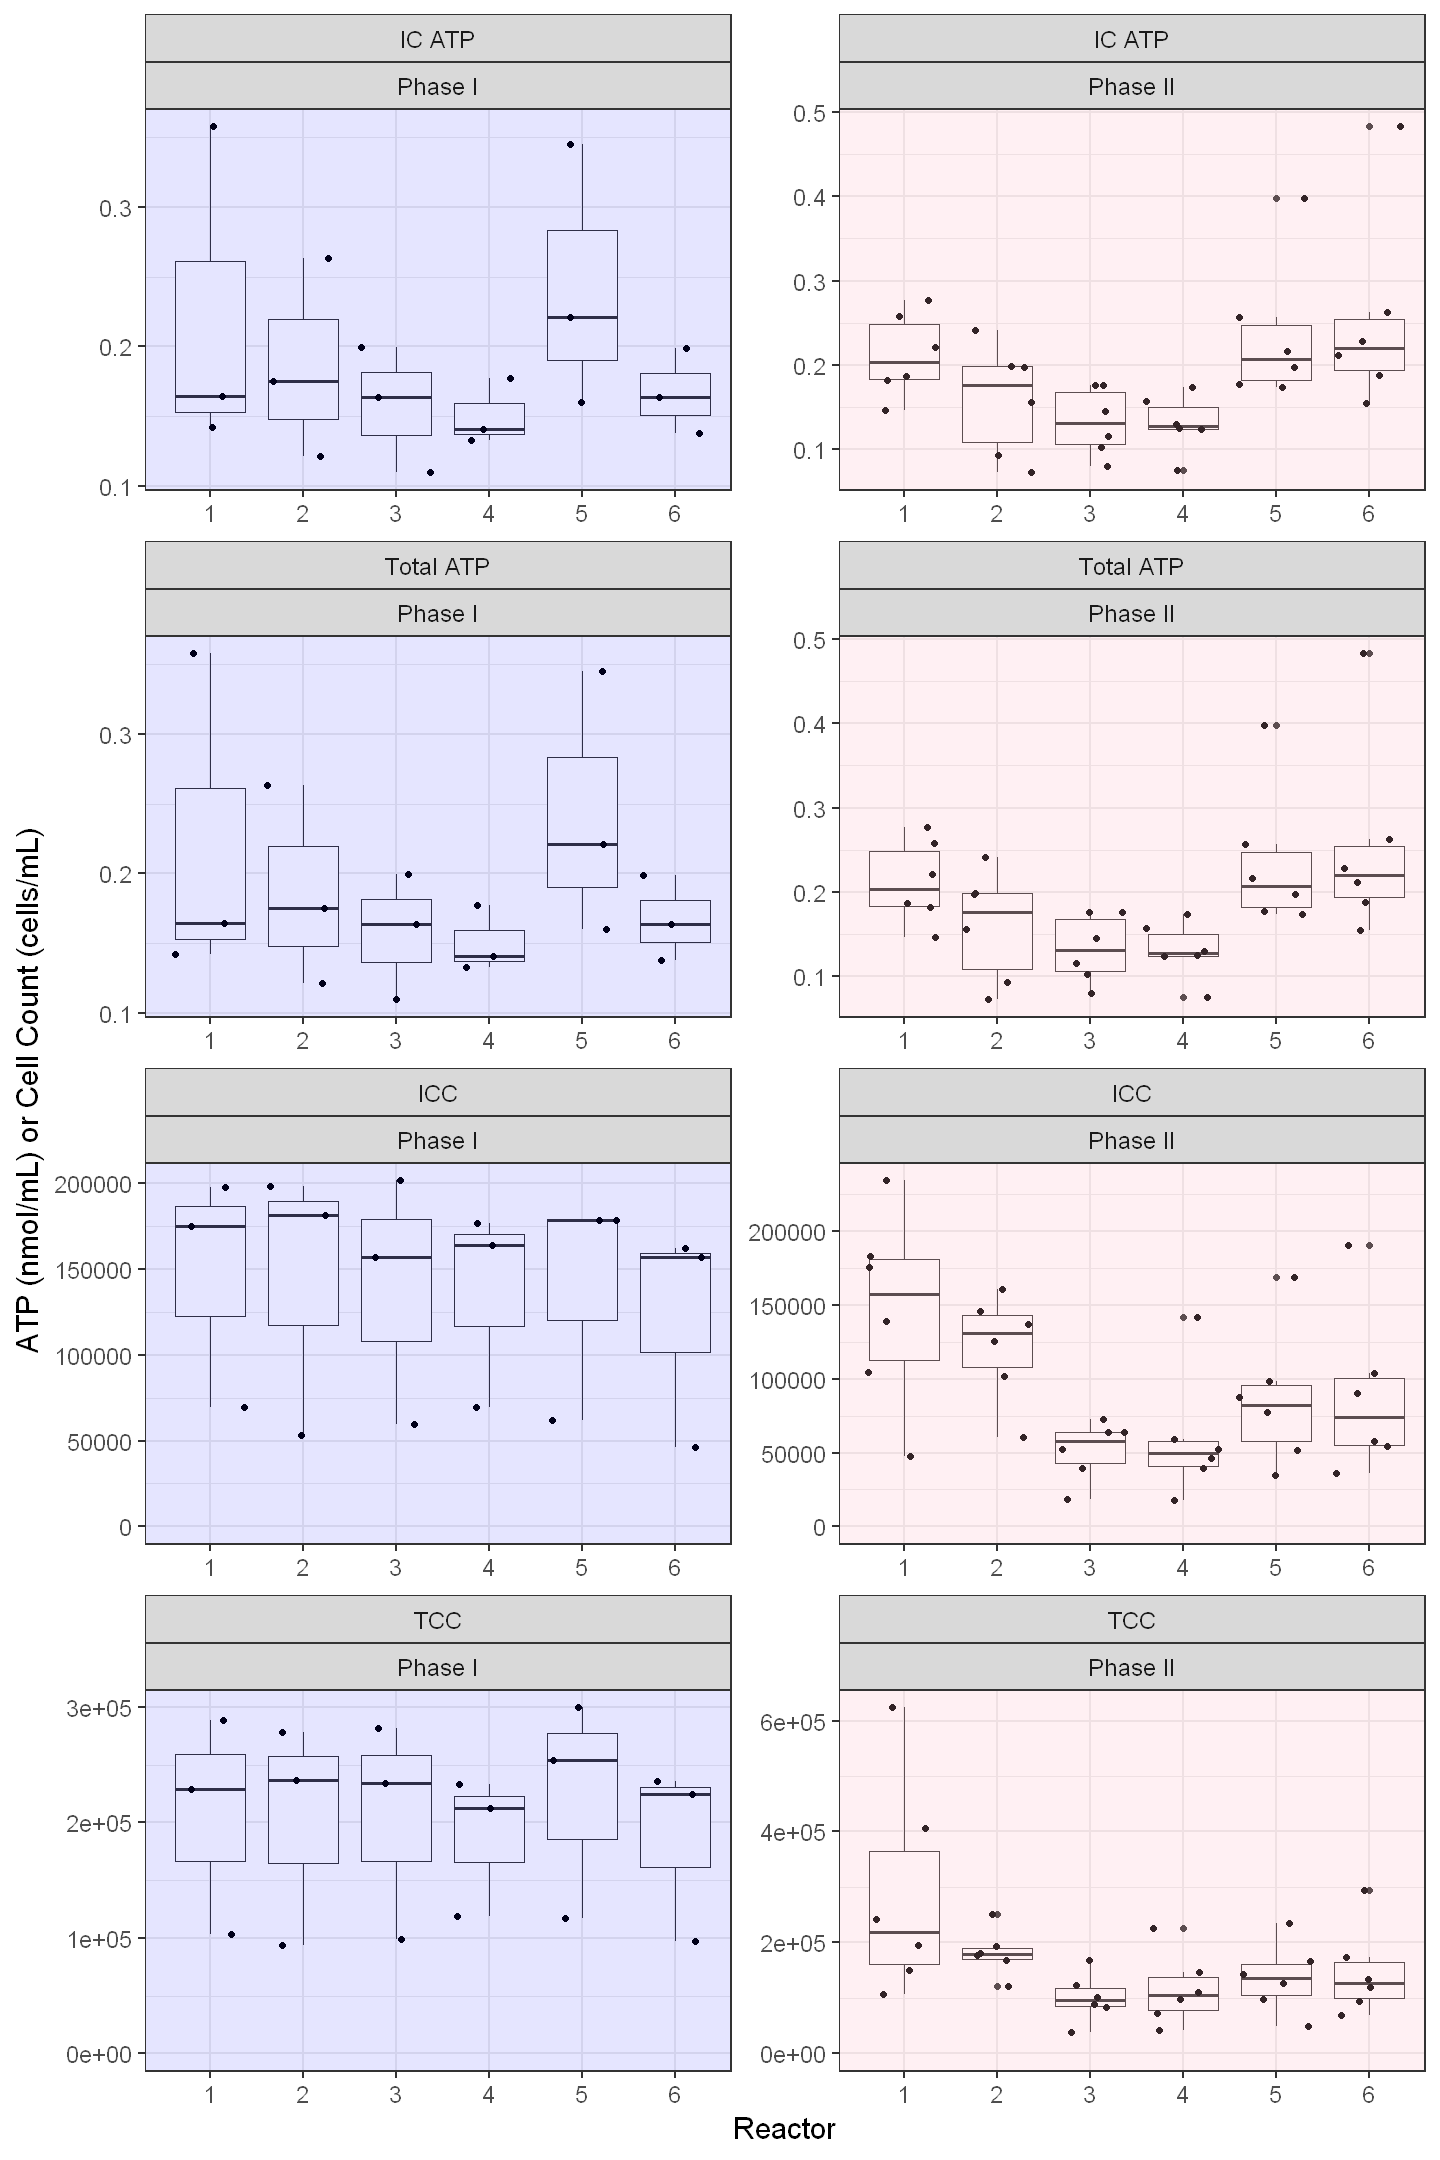

In [547]:
# plot boxplots of ATP in each reactor

a <- tot_un %>% filter( type == 'Bulk' , samples_type == 'AR') 

options(repr.plot.width = 12, repr.plot.height = 18)


tp <- unique(a[c('phase')])
tp$Number <- tp$geomean_blanked <- 0.3



fig_box_ATP <- ggplot(a, aes(x= Number, y= geomean_blanked))+
    geom_boxplot()+ 
    geom_point( position= 'jitter')+
    #scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    ylab('ATP (nmol/mL) or Cell Count (cells/mL)')+
    xlab('Bulk Water Reactor Sample')+
    facet_wrap(measurement~phase, scales= "free", ncol=2) +
    geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.1)+
    geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_box_ATP
                                        

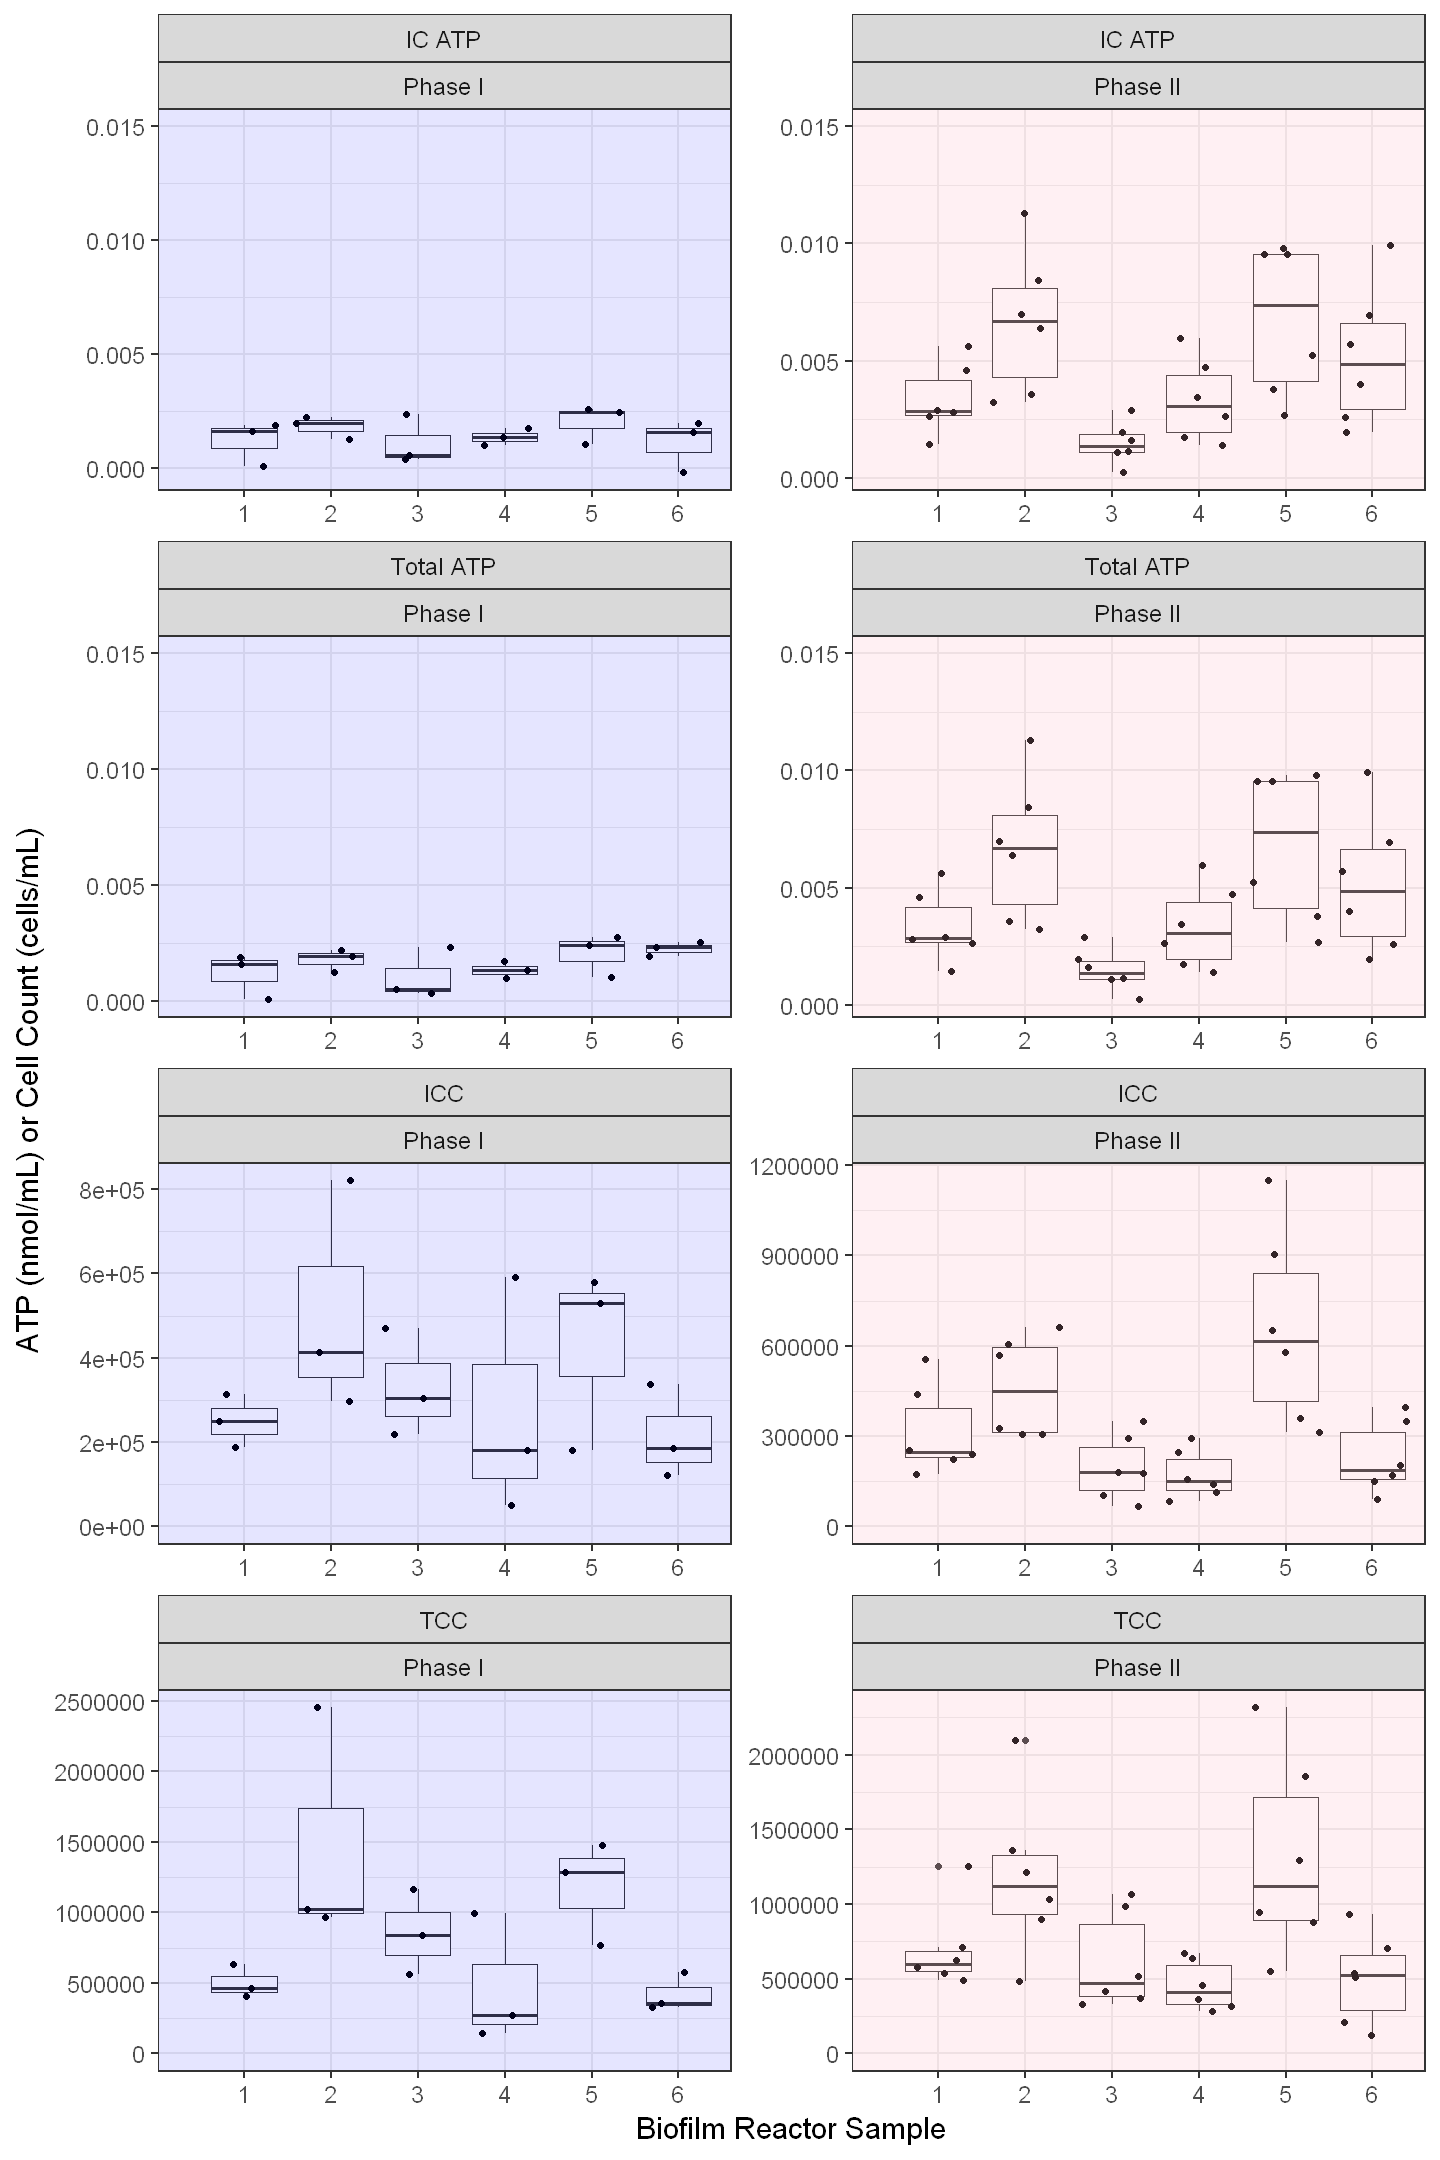

In [558]:
# plot boxplots of ATP in each reactor

a <- tot_un %>% filter( type == 'Biofilm' , samples_type == 'AR') 

options(repr.plot.width = 12, repr.plot.height = 18)


tp <- unique(a[c('phase')])
tp$Number <- tp$geomean_blanked <- 0.015



fig_bf_ATP <- ggplot(a, aes(x= Number, y= geomean_blanked))+
    geom_boxplot()+ 
    geom_point( position= 'jitter')+
    #scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    ylab('ATP (nmol/mL) or Cell Count (cells/mL)')+
    xlab('Biofilm Reactor Sample')+
    facet_wrap(measurement~phase, scales= "free", ncol=2) +
    geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.1)+
    geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_bf_ATP
                                        

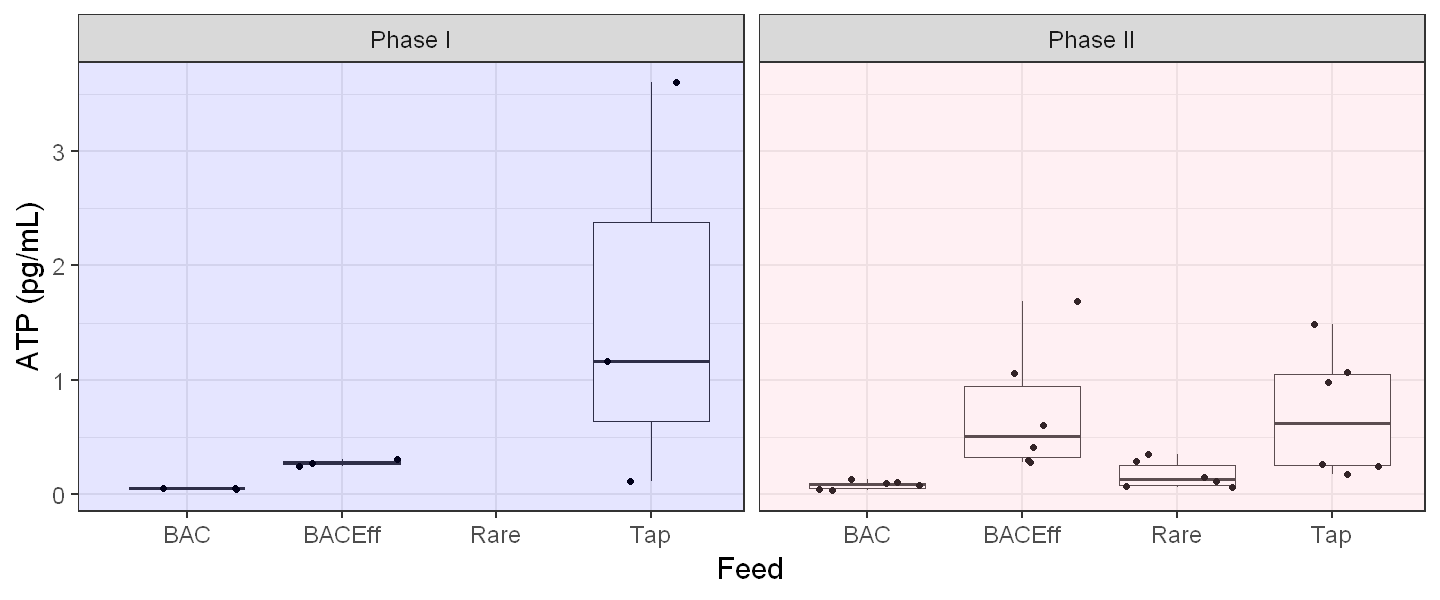

In [1915]:
# plot boxplots of ATP in each feed

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( Treatment =='Feed')  
a$phase <- as.character(a$phase)
a$phase[a$phase == "1"] <- "Phase I"
a$phase[a$phase == "2"] <- "Phase II"
options(repr.plot.width = 12, repr.plot.height = 5)

tp <- unique(a[c('phase')])
tp$samples_type <- tp$geomean_blanked <- 0.3


fig_feed_ATP <- ggplot(a, aes(x= samples_type, y= geomean_blanked))+
    geom_boxplot()+ 
    geom_point( position= 'jitter')+
   # scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E3, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    ylab('ATP (pg/mL)')+
    xlab('Feed')+
    facet_wrap(~phase, scales= "fixed", ncol=2) +
    geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.1)+
    geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
            ymin = -Inf,ymax = Inf,alpha = 0.2)+
    theme_bw(base_size = 18) 
fig_feed_ATP
                                        


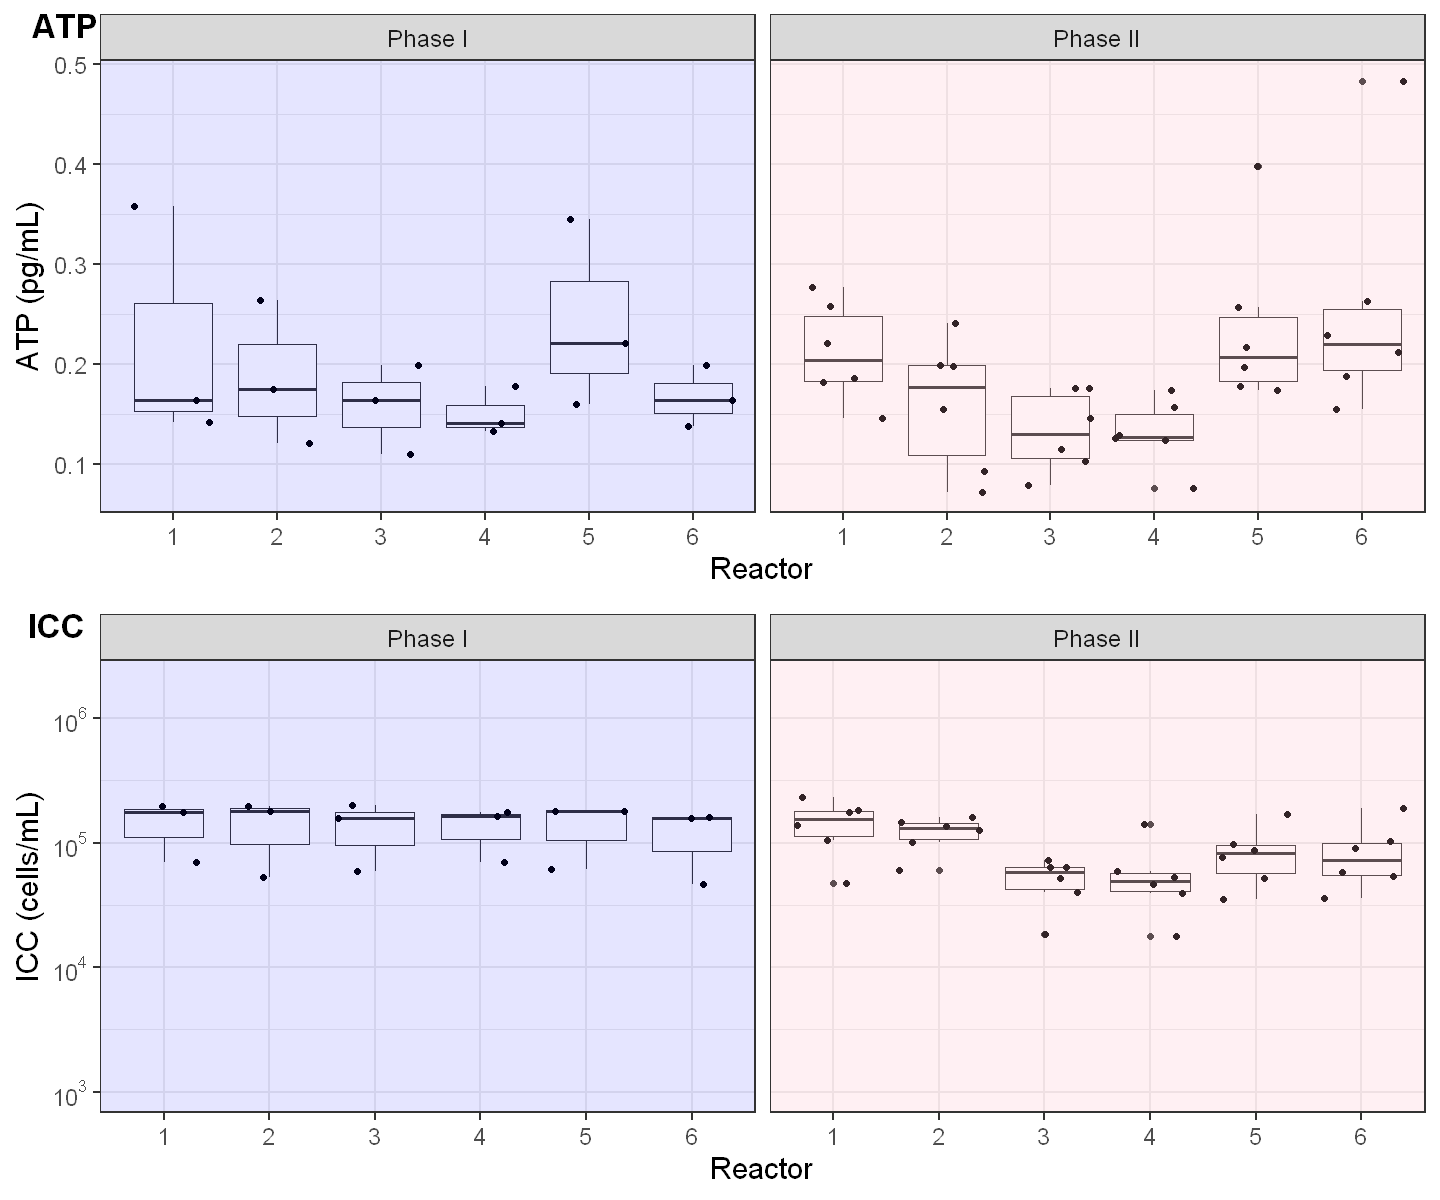

In [324]:
options(repr.plot.width = 12, repr.plot.height =10)
fig_box<- ggarrange( fig_box_ATP,fig_box_ICC, ncol=1, nrow=2, labels= c("ATP", "ICC"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_box

ggsave(paste0(fig_dir, 'fig_box.png'), width=12, height=10)

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 19 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 19 rows containing missing values (`geom_point()`)."
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 19 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 19 rows containing missing values (`geom_point()`)."


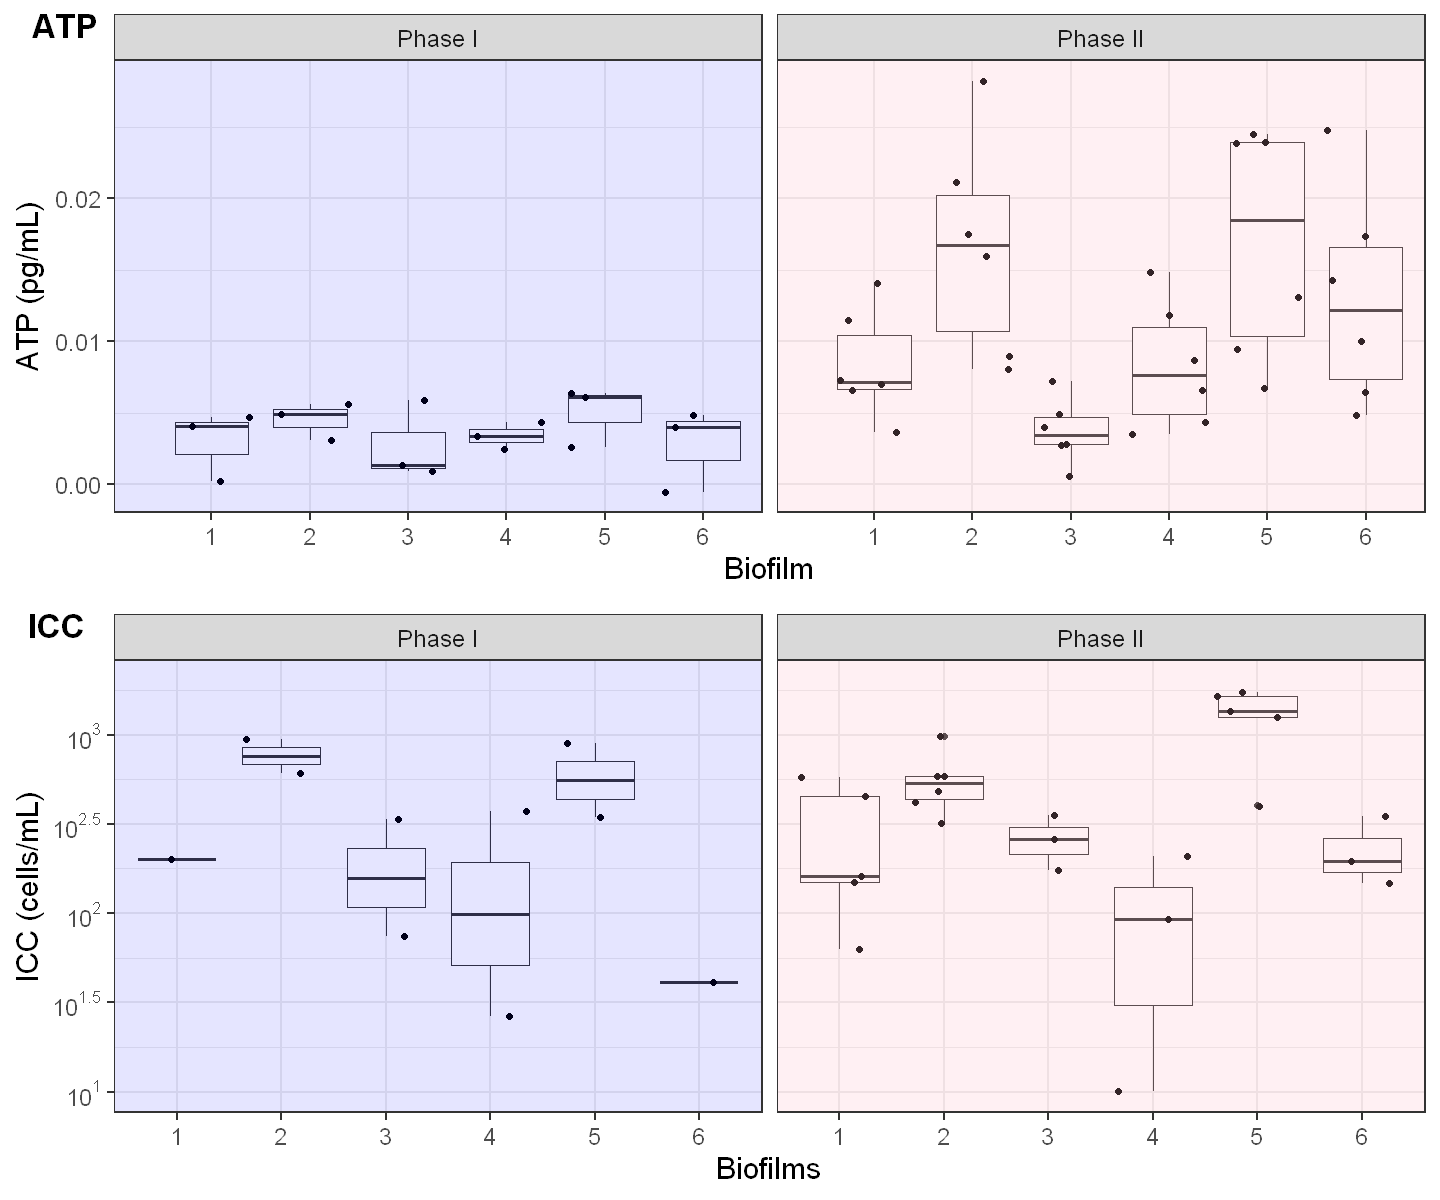

In [325]:
options(repr.plot.width = 12, repr.plot.height =10)
fig_box<- ggarrange( fig_bf_ATP,fig_bf_ICC, ncol=1, nrow=2, labels= c("ATP", "ICC"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_box

ggsave(paste0(fig_dir, 'fig_bf.png'), width=12, height=10)

Warning message:
"Removed 3 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 3 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."


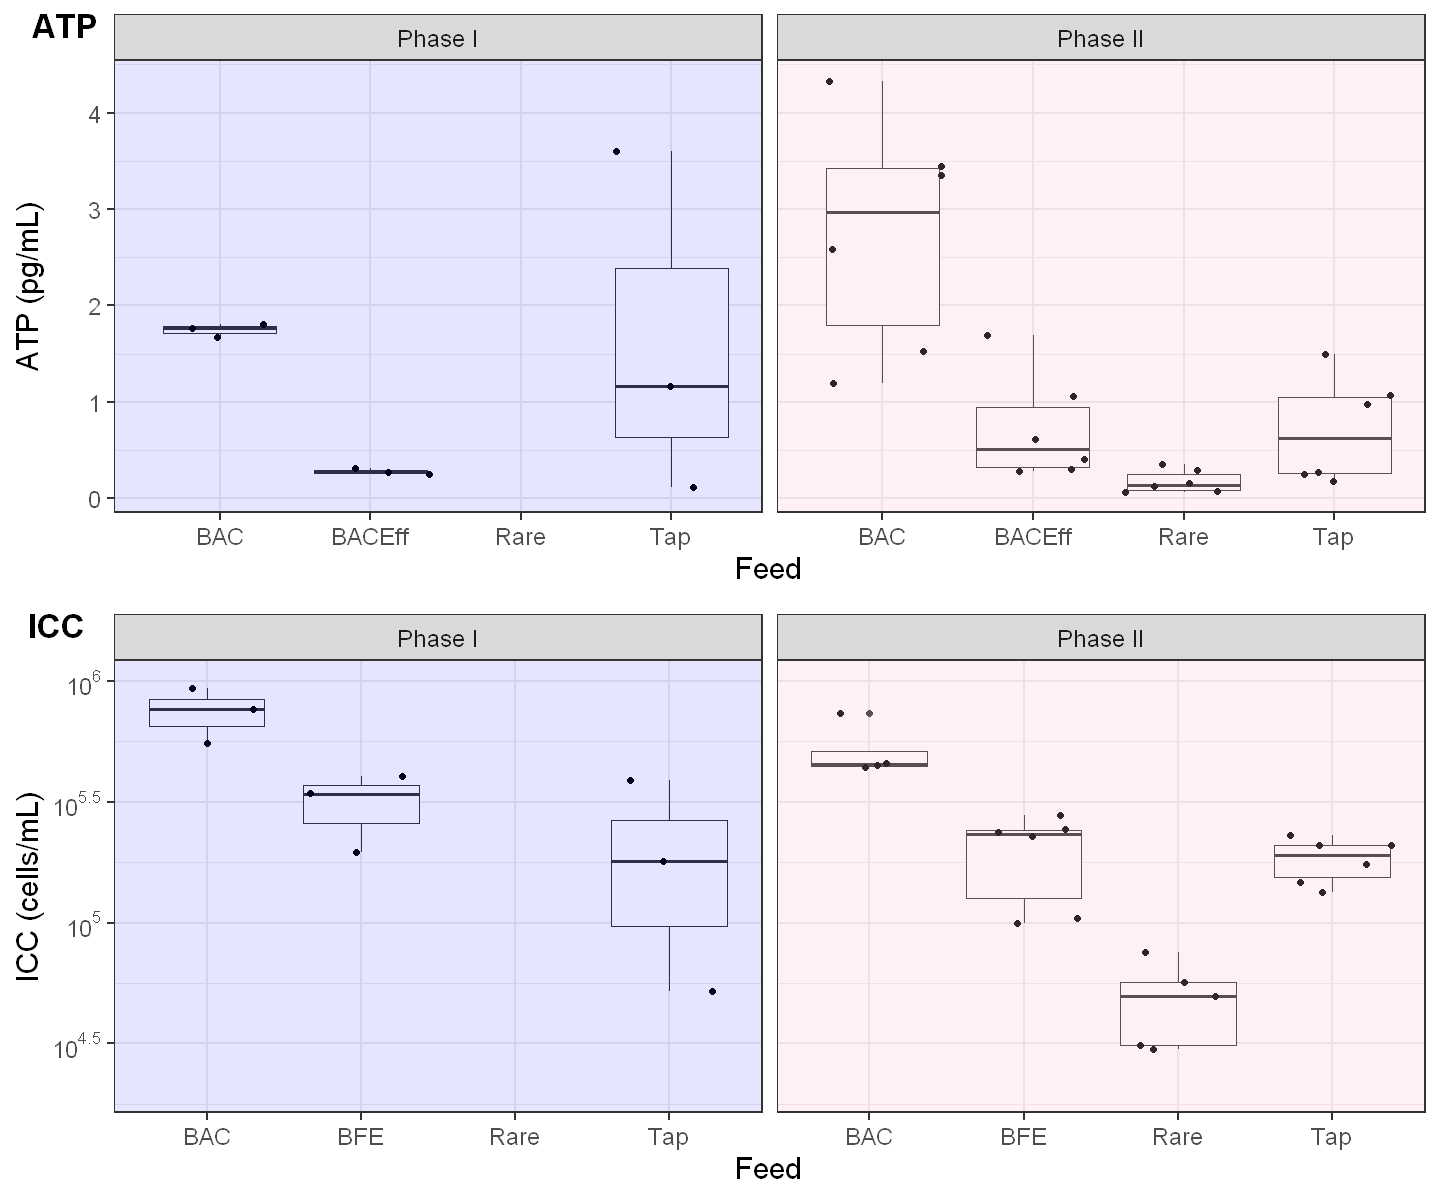

In [400]:
options(repr.plot.width = 12, repr.plot.height =10)
fig_box<- ggarrange( fig_feed_ATP,fig_feed_ICC, ncol=1, nrow=2, labels= c("ATP", "ICC"), font.label = list(size = 20, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_box

ggsave(paste0(fig_dir, 'fig_feed.png'), width=12, height=10)

# Significance

## Averaged

### KW

In [85]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'ICC' )%>%  filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
#kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 3.8836, df = 2, p-value = 0.1434



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.8, df = 2, p-value = 0.6703



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.4678, df = 2, p-value = 0.0394



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.1093, df = 2, p-value = 0.04714



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.62222, df = 2, p-value = 0.7326



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 5.9415, df = 2, p-value = 0.05126



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 11.54, df = 2, p-value = 0.00312



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 11.661, df = 2, p-value = 0.002937


ICC:
Significant differences in 2nd phase ARs, no significant differences in 1st phase ARs or overall. 

Significant differences in overall AR Biofilms, no significant differences in 1st or 2nd phase ARs.

Significant differences in overall and 2nd phase feeds, no significant differences in 1st phase.



In [46]:
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'TCC' )%>%  filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
#kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 4.6667, df = 2, p-value = 0.09697



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.088889, df = 2, p-value = 0.9565



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.3275, df = 2, p-value = 0.04227



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 4.1728, df = 2, p-value = 0.1241



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 1.4222, df = 2, p-value = 0.4911



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 3.1345, df = 2, p-value = 0.2086



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 11.899, df = 2, p-value = 0.002607



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 11.942, df = 2, p-value = 0.002552


TCC:
Significant differences in 2nd phase ARs, no significant differences in 1st phase ARs or overall.

No significant differences 1st phase, 2nd phase, or overall biofilms.

Significant differences in 2nd phase and overall feeds, no significant differences in 1st phase feed. 

In [47]:
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'IC ATP' )%>%  filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
#kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 9.2169, df = 2, p-value = 0.009967



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.8, df = 2, p-value = 0.6703



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 8.5614, df = 2, p-value = 0.01383



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 5.4004, df = 2, p-value = 0.06719



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.35556, df = 2, p-value = 0.8371



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 9.2749, df = 2, p-value = 0.009683



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.3333, df = 2, p-value = 0.04214



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.7485, df = 2, p-value = 0.03424


IC ATP:
Significant differences in overall and 2nd phase ARs, no significant differences in 1st phase ARs.

Significant differences in overall and 2nd phase biofilms, no significant differences in 1st phase biofilms.

Significant differences in 2nd phase feeds, no significant differences in 1st phase or overall feed. 

In [48]:
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'Total ATP' )%>%  filter(Sample_Type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
#kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Treatment, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 9.2169, df = 2, p-value = 0.009967



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 0.8, df = 2, p-value = 0.6703



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 8.5614, df = 2, p-value = 0.01383



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 8.3104, df = 2, p-value = 0.01568



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 2.7556, df = 2, p-value = 0.2521



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 9.2749, df = 2, p-value = 0.009683



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.3333, df = 2, p-value = 0.04214



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Treatment
Kruskal-Wallis chi-squared = 6.7485, df = 2, p-value = 0.03424


In [49]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)


a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Sample_Type, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 3.6923, df = 1, p-value = 0.05466



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 0.41026, df = 1, p-value = 0.5218



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.7692, df = 1, p-value = 0.01631



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 0.92308, df = 1, p-value = 0.3367



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 2.0769, df = 1, p-value = 0.1495



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.7692, df = 1, p-value = 0.01631



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.0256, df = 1, p-value = 0.02497



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 0.10256, df = 1, p-value = 0.7488



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.7692, df = 1, p-value = 0.01631



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.0256, df = 1, p-value = 0.02497



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 0.10256, df = 1, p-value = 0.7488



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Sample_Type
Kruskal-Wallis chi-squared = 5.7692, df = 1, p-value = 0.01631


### Dunn Test

In [50]:

a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1           Seeded ATW - SW -1.189624 0.23419430 0.23419430
2 Seeded ATW - Unseeded ATW  1.351845 0.17642485 0.26463727
3         SW - Unseeded ATW  2.541469 0.01103878 0.03311633

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z    P.unadj      P.adj
1           Seeded ATW - SW -1.5681404 0.11684837 0.17527255
2 Seeded ATW - Unseeded ATW  0.9192547 0.35796236 0.35796236
3         SW - Unseeded ATW  2.4873951 0.01286824 0.03860472

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z     P.unadj      P.adj
1           Seeded ATW - SW 1.297771 0.194365911 0.19436591
2 Seeded ATW - Unseeded ATW 2.919986 0.003500476 0.01050143
3         SW - Unseeded ATW 1.622214 0.104757490 0.15713623

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z     P.unadj      P.adj
1           Seeded ATW - SW 1.297771 0.194365911 0.19436591
2 Seeded ATW - Unseeded ATW 2.919986 0.003500476 0.01050143
3         SW - Unseeded ATW 1.622214 0.104757490 0.15713623

In [49]:

a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29') ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z   P.unadj     P.adj
1          Seeded ATW - Tap -0.5883484 0.5562985 0.5562985
2 Seeded ATW - Unseeded ATW  0.8825226 0.3774943 0.5662414
3        Tap - Unseeded ATW  1.4708710 0.1413260 0.4239780

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z    P.unadj     P.adj
1          Seeded ATW - Tap -1.2747549 0.20239602 0.3035940
2 Seeded ATW - Unseeded ATW  0.3922323 0.69488660 0.6948866
3        Tap - Unseeded ATW  1.6669871 0.09551696 0.2865509

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1          Seeded ATW - Tap 1.7650452 0.07755617 0.11633425
2 Seeded ATW - Unseeded ATW 2.3533936 0.01860293 0.05580879
3        Tap - Unseeded ATW 0.5883484 0.55629846 0.55629846

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1          Seeded ATW - Tap 1.7650452 0.07755617 0.11633425
2 Seeded ATW - Unseeded ATW 2.3533936 0.01860293 0.05580879
3        Tap - Unseeded ATW 0.5883484 0.55629846 0.55629846

In [51]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z     P.unadj       P.adj
1           Seeded ATW - SW 0.5407381 0.588688134 0.588688134
2 Seeded ATW - Unseeded ATW 3.1903546 0.001420983 0.004262949
3         SW - Unseeded ATW 2.6496165 0.008058317 0.012087476

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z      P.unadj       P.adj
1           Seeded ATW - SW 0.7570333 0.4490299133 0.449029913
2 Seeded ATW - Unseeded ATW 3.2985022 0.0009720211 0.002916063
3         SW - Unseeded ATW 2.5414689 0.0110387756 0.016558163

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1           Seeded ATW - SW 0.5948119 0.55196923 0.55196923
2 Seeded ATW - Unseeded ATW 2.4873951 0.01286824 0.03860472
3         SW - Unseeded ATW 1.8925832 0.05841331 0.08761997

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1           Seeded ATW - SW 0.5948119 0.55196923 0.55196923
2 Seeded ATW - Unseeded ATW 2.4873951 0.01286824 0.03860472
3         SW - Unseeded ATW 1.8925832 0.05841331 0.08761997

In [48]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' & Date>as.Date('2022-11-29') ) %>% filter(Sample_Type == 'Feed') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z    P.unadj      P.adj
1          Seeded ATW - Tap 0.000000 1.00000000 1.00000000
2 Seeded ATW - Unseeded ATW 2.353394 0.01860293 0.02790439
3        Tap - Unseeded ATW 2.353394 0.01860293 0.05580879

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z    P.unadj      P.adj
1          Seeded ATW - Tap 0.000000 1.00000000 1.00000000
2 Seeded ATW - Unseeded ATW 2.353394 0.01860293 0.02790439
3        Tap - Unseeded ATW 2.353394 0.01860293 0.05580879

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z    P.unadj      P.adj
1          Seeded ATW - Tap 1.078639 0.28074880 0.28074880
2 Seeded ATW - Unseeded ATW 2.451452 0.01422813 0.04268439
3        Tap - Unseeded ATW 1.372813 0.16981051 0.25471576

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison        Z    P.unadj      P.adj
1          Seeded ATW - Tap 1.078639 0.28074880 0.28074880
2 Seeded ATW - Unseeded ATW 2.451452 0.01422813 0.04268439
3        Tap - Unseeded ATW 1.372813 0.16981051 0.25471576

In [52]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj      P.adj
1           Seeded ATW - SW 0.1081476 0.91387860 0.91387860
2 Seeded ATW - Unseeded ATW 2.1629523 0.03054485 0.09163455
3         SW - Unseeded ATW 2.0548047 0.03989788 0.05984681

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z    P.unadj     P.adj
1           Seeded ATW - SW -0.5407381 0.58868813 0.5886881
2 Seeded ATW - Unseeded ATW  1.1896238 0.23419430 0.3512915
3         SW - Unseeded ATW  1.7303618 0.08356565 0.2506969

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z     P.unadj      P.adj
1           Seeded ATW - SW 0.5407381 0.588688134 0.58868813
2 Seeded ATW - Unseeded ATW 2.8659118 0.004158101 0.01247430
3         SW - Unseeded ATW 2.3251737 0.020062674 0.03009401

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z     P.unadj      P.adj
1           Seeded ATW - SW 0.5407381 0.588688134 0.58868813
2 Seeded ATW - Unseeded ATW 2.8659118 0.004158101 0.01247430
3         SW - Unseeded ATW 2.3251737 0.020062674 0.03009401

In [51]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' & Date>as.Date('2022-11-29')) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' & Date>as.Date('2022-11-29') ) %>% filter(Sample_Type == 'AR') 
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Treatment, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Treatment, data=AR_ICC_2,  method="bh")

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj     P.adj
1          Seeded ATW - Tap 0.3922323 0.69488660 0.6948866
2 Seeded ATW - Unseeded ATW 1.6669871 0.09551696 0.2865509
3        Tap - Unseeded ATW 1.2747549 0.20239602 0.3035940

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison          Z   P.unadj     P.adj
1          Seeded ATW - Tap -0.5883484 0.5562985 0.5562985
2 Seeded ATW - Unseeded ATW  0.5883484 0.5562985 0.8344477
3        Tap - Unseeded ATW  1.1766968 0.2393165 0.7179496

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj     P.adj
1          Seeded ATW - Tap 0.2941742 0.76862479 0.7686248
2 Seeded ATW - Unseeded ATW 2.0592194 0.03947322 0.1184197
3        Tap - Unseeded ATW 1.7650452 0.07755617 0.1163343

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




                 Comparison         Z    P.unadj     P.adj
1          Seeded ATW - Tap 0.2941742 0.76862479 0.7686248
2 Seeded ATW - Unseeded ATW 2.0592194 0.03947322 0.1184197
3        Tap - Unseeded ATW 1.7650452 0.07755617 0.1163343

In [181]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.401922 0.01630917 0.01630917

In [183]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")


a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")


a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")


a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'SW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Unseeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' )  %>% filter( Treatment == 'Seeded ATW' )  
AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Sample_Type, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ Sample_Type, data=AR_ICC_2,  method="bonferroni")

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -1.921538 0.05466394 0.05466394

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z   P.unadj     P.adj
1  AR - Feed 0.6405126 0.5218394 0.5218394

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.401922 0.01630917 0.01630917

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison          Z   P.unadj     P.adj
1  AR - Feed -0.9607689 0.3366684 0.3366684

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison        Z   P.unadj     P.adj
1  AR - Feed 1.441153 0.1495414 0.1495414

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.401922 0.01630917 0.01630917

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.241794 0.02497468 0.02497468

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison          Z  P.unadj    P.adj
1  AR - Feed -0.3202563 0.748774 0.748774

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.401922 0.01630917 0.01630917

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.241794 0.02497468 0.02497468

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison          Z  P.unadj    P.adj
1  AR - Feed -0.3202563 0.748774 0.748774

Warning message:
"Sample_Type was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




  Comparison         Z    P.unadj      P.adj
1  AR - Feed -2.401922 0.01630917 0.01630917

### Wilcoxon Rank Sum

#### ARs vs. Feeds

In [67]:
p= 'Phase II'
m = 'ICC'


sATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_f <- tot %>% filter(measurement== m) %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()

wilcox.test(SW_AR$geomean_blanked, SW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR$geomean_blanked, uATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR$geomean_blanked, sATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  SW_AR$geomean_blanked and SW_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR$geomean_blanked and uATW_f$geomean_blanked
W = 22, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR$geomean_blanked and sATW_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


In [62]:
p= 'Phase II'
m = 'TCC'


sATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_f <- tot %>% filter(measurement== m) %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()


wilcox.test(SW_AR$geomean_blanked, SW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR$geomean_blanked, uATW_f$geomean_blanked,p.adjust.method = "BH", conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR$geomean_blanked, sATW_f$geomean_blanked,p.adjust.method = "BH", conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  SW_AR$geomean_blanked and SW_f$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR$geomean_blanked and uATW_f$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR$geomean_blanked and sATW_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


In [61]:
p= 'Phase II'
m = 'IC ATP'


sATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_f <- tot %>% filter(measurement== m) %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()


wilcox.test(SW_AR$geomean_blanked, SW_f$geomean_blanked,p.adjust.method = "BH", conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR$geomean_blanked, uATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR$geomean_blanked, sATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  SW_AR$geomean_blanked and SW_f$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR$geomean_blanked and uATW_f$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR$geomean_blanked and sATW_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


In [60]:
p= 'Phase II'
m = 'Total ATP'


sATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_f <- tot %>% filter(measurement== m) %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_f <- tot %>% filter(measurement== m)  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()


wilcox.test(SW_AR$geomean_blanked, SW_f$geomean_blanked,  p.adjust.method = "BH", conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR$geomean_blanked, uATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR$geomean_blanked, sATW_f$geomean_blanked, p.adjust.method = "BH",conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  SW_AR$geomean_blanked and SW_f$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR$geomean_blanked and uATW_f$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR$geomean_blanked and sATW_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


#### Phase 2

In [65]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#both 
p= 'Phase II'

BFE_ICC <- tot %>% filter(measurement== "ICC") %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_ICC <- tot %>% filter(measurement== "ICC") %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_ICC <- tot %>% filter(measurement== "ICC")  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot %>% filter(measurement== "ICC")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot %>% filter(measurement== "ICC") %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot %>% filter(measurement== "ICC")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== p, type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_bf <- tot %>% filter(measurement== "ICC")  %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



wilcox.test(Rare_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_ICC$geomean_blanked, Tap_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_bf$geomean_blanked, Tap_bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Tap_ICC$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 22, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and Tap_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0


ICC: 
Tap & ATW ARs

BFE ARs & BFE feed

ATW feed and BFE Feed **

ATW feed and tap feed **

ATW BF and BFE BF *

In [68]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#both 
p= 'Phase II'

BFE_ICC <- tot %>% filter(measurement== "TCC") %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_ICC <- tot %>% filter(measurement== "TCC") %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_ICC <- tot %>% filter(measurement== "TCC")  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot %>% filter(measurement== "TCC")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot %>% filter(measurement== "TCC") %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot %>% filter(measurement== "TCC")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== p, type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_bf <- tot %>% filter(measurement== "TCC")  %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



wilcox.test(Rare_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_ICC$geomean_blanked, Tap_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_bf$geomean_blanked, Tap_bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 28, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Tap_ICC$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 21, p-value = 0.6991
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and Tap_bf$geomean_blanked
W = 7, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0


TCC: 
Tap & ATW ARs

BFE ARs & BFE feed

ATW feed and BFE Feed **

ATW feed and tap feed **

In [71]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#both 
p= 'Phase II'

BFE_ICC <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_ICC <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_ICC <- tot %>% filter(measurement== "IC ATP")  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot %>% filter(measurement== "IC ATP")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot %>% filter(measurement== "IC ATP")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== p, type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_bf <- tot %>% filter(measurement== "IC ATP")  %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



wilcox.test(Rare_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_ICC$geomean_blanked, Tap_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_bf$geomean_blanked, Tap_bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 10, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Tap_ICC$geomean_blanked
W = 8, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 1, p-value = 0.004329
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and Tap_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


IC ATP: 
BFE & ATW ARs **

Tap ARs & Tap feed *

BFE ARs & BFE feed *

ATW feed and BFE Feed *

ATW bf and BFE bf **

ATW bf and tap bf *

In [74]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#both 
p= 'Phase II'

BFE_ICC <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_ICC <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_ICC <- tot %>% filter(measurement== "Total ATP")  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot %>% filter(measurement== "Total ATP")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== p, Sample_Type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot %>% filter(measurement== "Total ATP")  %>% filter(phase== p,  Sample_Type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== p, type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_bf <- tot %>% filter(measurement== "Total ATP")  %>% filter(phase== p,type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



wilcox.test(Rare_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, BFE_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_ICC$geomean_blanked, Tap_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_bf$geomean_blanked, BFE_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_bf$geomean_blanked, Tap_bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and BFE_ICC$geomean_blanked
W = 10, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Tap_ICC$geomean_blanked
W = 8, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 1, p-value = 0.004329
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_bf$geomean_blanked and BFE_bf$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_bf$geomean_blanked and Tap_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


Total ATP: 
BFE & ATW ARs **

Tap ARs & Tap feed

BFE ARs & BFE feed

ATW feed and BFE Feed

ATW bf and BFE bf **

ATW bf and tap bf

## Phase 1 v Phase II

### KW

In [184]:
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)

a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 1.0667, df = 1, p-value = 0.3017



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 3.2667, df = 1, p-value = 0.0707



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.26667, df = 1, p-value = 0.6056



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0, df = 1, p-value = 1



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.26667, df = 1, p-value = 0.6056


In [185]:
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)

a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.066667, df = 1, p-value = 0.7963



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 2.4, df = 1, p-value = 0.1213



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 1.0667, df = 1, p-value = 0.3017



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0, df = 1, p-value = 1



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.066667, df = 1, p-value = 0.7963



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.066667, df = 1, p-value = 0.7963


In [186]:
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.066667, df = 1, p-value = 0.7963



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 1.6667, df = 1, p-value = 0.1967



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 5.4, df = 1, p-value = 0.02014



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 3.2667, df = 1, p-value = 0.0707



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 5.4, df = 1, p-value = 0.02014


In [187]:
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.066667, df = 1, p-value = 0.7963



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 1.6667, df = 1, p-value = 0.1967



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 5.4, df = 1, p-value = 0.02014



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 3.2667, df = 1, p-value = 0.0707



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 5.4, df = 1, p-value = 0.02014


In [478]:
a <- tot_wb %>% filter( measurement == 'ICC' ) %>% filter( Treatment == 'Column Effluent' ) 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'TCC' ) %>% filter( Treatment == 'Column Effluent' )
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'IC ATP' ) %>% filter( Treatment == 'Column Effluent' )
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'Total ATP' ) %>% filter( Treatment == 'Column Effluent' )
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 1.6667, df = 1, p-value = 0.1967



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 3.2667, df = 1, p-value = 0.0707



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 3.2667, df = 1, p-value = 0.0707


In [474]:
a <- tot_wb %>% filter( measurement == 'ICC' )%>% filter( type == 'BAC Media' ) 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'TCC' )%>% filter( type == 'BAC Media' ) 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'IC ATP' )%>% filter( type == 'BAC Media' ) 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)
a <- tot_wb %>% filter( measurement == 'Total ATP' )%>% filter( type == 'BAC Media' ) 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ phase, data = AR_ICC)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.26667, df = 1, p-value = 0.6056



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0, df = 1, p-value = 1



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386



	Kruskal-Wallis rank sum test

data:  geomean_blanked by phase
Kruskal-Wallis chi-squared = 0.6, df = 1, p-value = 0.4386


### Dunn

In [189]:
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")

a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")


Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison         Z   P.unadj     P.adj
1 Phase I - Phase II 0.2581989 0.7962534 0.7962534

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z   P.unadj     P.adj
1 Phase I - Phase II 1.290994 0.1967056 0.1967056

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison          Z  P.unadj    P.adj
1 Phase I - Phase II -0.7745967 0.438578 0.438578

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z    P.unadj      P.adj
1 Phase I - Phase II -2.32379 0.02013675 0.02013675

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison         Z    P.unadj      P.adj
1 Phase I - Phase II -1.807392 0.07070114 0.07070114

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z    P.unadj      P.adj
1 Phase I - Phase II -2.32379 0.02013675 0.02013675

In [190]:
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")

a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'SW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Unseeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")
a <- tot %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(Sample_Type == 'AR') %>% filter(Treatment == 'Seeded ATW') 
AR_ICC <- a %>% dplyr::select(phase, geomean_blanked) %>% drop_na()
dunnTest(geomean_blanked ~ phase, data=AR_ICC,  method="bonferroni")


Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison         Z   P.unadj     P.adj
1 Phase I - Phase II 0.2581989 0.7962534 0.7962534

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z   P.unadj     P.adj
1 Phase I - Phase II 1.290994 0.1967056 0.1967056

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison          Z  P.unadj    P.adj
1 Phase I - Phase II -0.7745967 0.438578 0.438578

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z    P.unadj      P.adj
1 Phase I - Phase II -2.32379 0.02013675 0.02013675

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison         Z    P.unadj      P.adj
1 Phase I - Phase II -1.807392 0.07070114 0.07070114

Warning message:
"phase was coerced to a factor."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




          Comparison        Z    P.unadj      P.adj
1 Phase I - Phase II -2.32379 0.02013675 0.02013675

### WRS

In [83]:
p= 'Phase I'
m = 'IC ATP'

sATW_AR_1 <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR_1 <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_bf_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_bf_1 <- tot %>% filter(measurement== m) %>% filter(phase== p, type == 'Biofilm' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_bf_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
p= 'Phase II'
sATW_AR_2 <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR_2 <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_bf_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_bf_2 <- tot %>% filter(measurement== m) %>% filter(phase== p, type == 'Biofilm' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_bf_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()


wilcox.test(SW_AR_1$geomean_blanked, SW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR_1$geomean_blanked, uATW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR_1$geomean_blanked, sATW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(SW_bf_1$geomean_blanked, SW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(uATW_bf_1$geomean_blanked, uATW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(sATW_bf_1$geomean_blanked, sATW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  SW_AR_1$geomean_blanked and SW_AR_2$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR_1$geomean_blanked and uATW_AR_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR_1$geomean_blanked and sATW_AR_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SW_bf_1$geomean_blanked and SW_bf_2$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_bf_1$geomean_blanked and uATW_bf_2$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_bf_1$geomean_blanked and sATW_bf_2$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0


In [82]:
p= 'Phase I'
m = 'Total ATP'

sATW_AR_1 <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR_1 <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_bf_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_bf_1 <- tot %>% filter(measurement== m) %>% filter(phase== p, type == 'Biofilm' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_bf_1 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
p= 'Phase II'
sATW_AR_2 <- tot %>% filter(measurement== m) %>% filter(phase== p, type=='Bulk', Sample_Type == 'AR' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_AR_2 <- tot %>% filter(measurement== m) %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_AR_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,type=='Bulk', Sample_Type == 'AR' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()
sATW_bf_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "Seeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
uATW_bf_2 <- tot %>% filter(measurement== m) %>% filter(phase== p, type == 'Biofilm' , Treatment == "Unseeded ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
SW_bf_2 <- tot %>% filter(measurement== m)  %>% filter(phase== p,  type == 'Biofilm' , Treatment == "SW") %>% dplyr::select(geomean_blanked) %>% drop_na()


wilcox.test(SW_AR_1$geomean_blanked, SW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(uATW_AR_1$geomean_blanked, uATW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(sATW_AR_1$geomean_blanked, sATW_AR_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(SW_bf_1$geomean_blanked, SW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(uATW_bf_1$geomean_blanked, uATW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(sATW_bf_1$geomean_blanked, sATW_bf_2$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  SW_AR_1$geomean_blanked and SW_AR_2$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_AR_1$geomean_blanked and uATW_AR_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_AR_1$geomean_blanked and sATW_AR_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SW_bf_1$geomean_blanked and SW_bf_2$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  uATW_bf_1$geomean_blanked and uATW_bf_2$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  sATW_bf_1$geomean_blanked and sATW_bf_2$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0


In [108]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

BFE_1 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BAC_1 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
BAC_2 <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()

BFE_1bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2bf <- tot %>% filter(measurement== "ICC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



wilcox.test(Rare_1$geomean_blanked, Rare_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1$geomean_blanked, BFE_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1$geomean_blanked, Tap_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BAC_1$geomean_blanked, BAC_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1bf$geomean_blanked, Rare_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1bf$geomean_blanked, BFE_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1bf$geomean_blanked, Tap_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  Rare_1$geomean_blanked and Rare_2$geomean_blanked
W = 16, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1$geomean_blanked and BFE_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1$geomean_blanked and Tap_2$geomean_blanked
W = 13, p-value = 0.381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BAC_1$geomean_blanked and BAC_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1bf$geomean_blanked and Rare_2bf$geomean_blanked
W = 12, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1bf$geomean_blanked and BFE_2bf$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1bf$geomean_blanked and Tap_2bf$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0


ICC:

Bulk:

none

Biofilm:

none

In [109]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

BFE_1 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BFE_1bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2bf <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BAC_1 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase I', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
BAC_2 <- tot %>% filter(measurement== "TCC") %>% filter(phase== 'Phase II', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
wilcox.test(BAC_1$geomean_blanked, BAC_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1$geomean_blanked, Rare_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1$geomean_blanked, BFE_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1$geomean_blanked, Tap_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1bf$geomean_blanked, Rare_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1bf$geomean_blanked, BFE_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1bf$geomean_blanked, Tap_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  BAC_1$geomean_blanked and BAC_2$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1$geomean_blanked and Rare_2$geomean_blanked
W = 15, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1$geomean_blanked and BFE_2$geomean_blanked
W = 13, p-value = 0.381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1$geomean_blanked and Tap_2$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1bf$geomean_blanked and Rare_2bf$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1bf$geomean_blanked and BFE_2bf$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1bf$geomean_blanked and Tap_2bf$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0


TCC: 

Bulk: 

none

Biofilm:

none

In [110]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

BFE_1 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BFE_1bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2bf <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BAC_1 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase I', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
BAC_2 <- tot %>% filter(measurement== "IC ATP") %>% filter(phase== 'Phase II', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
wilcox.test(BAC_1$geomean_blanked, BAC_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1$geomean_blanked, Rare_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1$geomean_blanked, BFE_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1$geomean_blanked, Tap_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1bf$geomean_blanked, Rare_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1bf$geomean_blanked, BFE_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1bf$geomean_blanked, Tap_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  BAC_1$geomean_blanked and BAC_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1$geomean_blanked and Rare_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1$geomean_blanked and BFE_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1$geomean_blanked and Tap_2$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1bf$geomean_blanked and Rare_2bf$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1bf$geomean_blanked and BFE_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1bf$geomean_blanked and Tap_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0


IC ATP: 

Bulk: 

none

Biofilm:

tap and bfe

In [112]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

BFE_1 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Bulk', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BFE_1bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_1bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_1bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_2bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_2bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_2bf <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='Biofilm', Sample_Type == 'AR' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()

BAC_1 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase I', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
BAC_2 <- tot %>% filter(measurement== "Total ATP") %>% filter(phase== 'Phase II', type=='BAC Media') %>% dplyr::select(geomean_blanked) %>% drop_na()
wilcox.test(BAC_1$geomean_blanked, BAC_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1$geomean_blanked, Rare_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1$geomean_blanked, BFE_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1$geomean_blanked, Tap_2$geomean_blanked, conf.level= 0.95) #not statistically different 


wilcox.test(Rare_1bf$geomean_blanked, Rare_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(BFE_1bf$geomean_blanked, BFE_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_1bf$geomean_blanked, Tap_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 




	Wilcoxon rank sum exact test

data:  BAC_1$geomean_blanked and BAC_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1$geomean_blanked and Rare_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1$geomean_blanked and BFE_2$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1$geomean_blanked and Tap_2$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_1bf$geomean_blanked and Rare_2bf$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  BFE_1bf$geomean_blanked and BFE_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_1bf$geomean_blanked and Tap_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0


Total ATP: 

Bulk: 

none

Biofilm:

tap and bfe

## Individual:


### KW

In [499]:
a <- tot_un %>% filter( measurement == 'ICC' )%>% filter( type == 'Bulk' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'ICC' )%>% filter( type == 'Biofilm' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'ICC' )%>%  filter(samples_type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 8.3293, df = 5, p-value = 0.139



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 1.9825, df = 5, p-value = 0.8516



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 12.357, df = 5, p-value = 0.03021



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 22.471, df = 5, p-value = 0.000426



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 3.9708, df = 5, p-value = 0.5536



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 19.565, df = 5, p-value = 0.001508



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 13.086, df = 2, p-value = 0.00144



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 1.1905, df = 1, p-value = 0.2752



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 11.661, df = 2, p-value = 0.002937


ICC: 
Significant differences in AR bulk 2nd phase

Significant difference in biofilms overall and 2nd phase

Significant difference in feeds overall and 2nd phase


In [500]:
a <- tot_un %>% filter( measurement == 'TCC' )%>% filter( type == 'Bulk' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'TCC' )%>% filter( type == 'Biofilm' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'TCC' )%>%  filter(samples_type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 7.6316, df = 5, p-value = 0.1777



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 1.7485, df = 5, p-value = 0.8827



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 11.769, df = 5, p-value = 0.0381



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 24.34, df = 5, p-value = 0.0001868



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 10.31, df = 5, p-value = 0.06691



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 14.754, df = 5, p-value = 0.01147



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 13.708, df = 2, p-value = 0.001055



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 1.1905, df = 1, p-value = 0.2752



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 11.942, df = 2, p-value = 0.002552


TCC: 
Significant differences in AR bulk 2nd phase

Significant difference in biofilms overall and 2nd phase

Significant difference in feeds overall and 2nd phase


In [501]:
a <- tot_un %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Bulk' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'IC ATP' )%>% filter( type == 'Biofilm' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'IC ATP' )%>%  filter(samples_type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 17.974, df = 5, p-value = 0.002979



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 2.8713, df = 5, p-value = 0.7198



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 16.622, df = 5, p-value = 0.005276



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 12.847, df = 5, p-value = 0.02485



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 3.6667, df = 5, p-value = 0.5983



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 16.814, df = 5, p-value = 0.004867



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 5.7611, df = 2, p-value = 0.0561



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 0.42857, df = 1, p-value = 0.5127



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 6.7485, df = 2, p-value = 0.03424


IC ATP: 
Significant differences in AR bulk 2nd phase and overall

Significant difference in biofilms overall and 2nd phase

Significant difference in feeds 2nd phase


In [502]:
a <- tot_un %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Bulk' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'Total ATP' )%>% filter( type == 'Biofilm' ) %>% filter(samples_type == 'AR') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


a <- tot_un %>% filter( measurement == 'Total ATP' )%>%  filter(samples_type == 'Feed') 

AR_ICC <- a %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC)

AR_ICC_1 <- a %>% filter(phase == 'Phase I') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_1)

AR_ICC_2 <- a %>% filter(phase == 'Phase II') %>% dplyr::select(Number, geomean_blanked) %>% drop_na()
kruskal.test(geomean_blanked ~ Number, data = AR_ICC_2)


	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 17.974, df = 5, p-value = 0.002979



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 2.8713, df = 5, p-value = 0.7198



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 16.622, df = 5, p-value = 0.005276



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 15.009, df = 5, p-value = 0.01032



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 6.2398, df = 5, p-value = 0.2836



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 16.814, df = 5, p-value = 0.004867



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 5.7611, df = 2, p-value = 0.0561



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 0.42857, df = 1, p-value = 0.5127



	Kruskal-Wallis rank sum test

data:  geomean_blanked by Number
Kruskal-Wallis chi-squared = 6.7485, df = 2, p-value = 0.03424


Total ATP: 
Significant differences in AR bulk 2nd phase and overall

Significant difference in biofilms overall and 2nd phase

Significant difference in feeds 2nd phase


### WRS 

In [504]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#phase II
p= 'Phase II'
AR1_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR1_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot_un %>% filter(measurement== "ICC")  %>% filter(phase==p,  samples_type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot_un %>% filter(measurement== "ICC") %>% filter(phase==p, samples_type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot_un %>% filter(measurement== "ICC")  %>% filter(phase== p,  samples_type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR3_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR3_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 24, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR3_ICC$geomean_blanked
W = 32, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 31, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 29, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 21, p-value = 0.6991
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 20, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 23, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 22, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR3_bf$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 29, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 21, p-value = 0.6991
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 1, p-value = 0.004329
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 24, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


ICC: 

Bulk:

AR1 & AR3, AR1 & AR4, AR2 & AR3, AR2 & AR4

Biofilm:

AR1 & AR5, AR2 & AR3,  AR2 & AR4 **, AR3 & AR5 **, AR4 & AR5 **, AR5 & AR6

Feed:

AR2 & feed, AR5 & feed **, AR6 and feed, ATW & BFE feed **, ATW and tap feed **

In [506]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#phase II
p= 'Phase II'
AR1_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR1_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot_un %>% filter(measurement== "TCC")  %>% filter(phase==p,  samples_type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot_un %>% filter(measurement== "TCC") %>% filter(phase==p, samples_type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot_un %>% filter(measurement== "TCC")  %>% filter(phase== p,  samples_type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR3_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR3_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 23, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR3_ICC$geomean_blanked
W = 33, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 31, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 29, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 28, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 8, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 16, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 22, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 22, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 11, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 9, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR3_bf$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 28, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 5, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 24, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 21, p-value = 0.6991
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 20, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0


TCC: 

Bulk: 

AR1 & AR3, AR1 & AR4, AR2 & AR3

Biofilm:

AR2 & AR4 **, AR2 & AR6,  AR4 & AR5 **, AR5 & AR6

Feed: 

AR5 & feed **, ATW & BFE feed **, ATW and tap feed **

In [508]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#phase II
p= 'Phase II'
AR1_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR1_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot_un %>% filter(measurement== "IC ATP")  %>% filter(phase==p,  samples_type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase==p, samples_type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot_un %>% filter(measurement== "IC ATP")  %>% filter(phase== p,  samples_type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR3_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR3_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR3_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 20, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 8, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 17, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR3_bf$geomean_blanked
W = 31, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 7, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 5, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 1, p-value = 0.004329
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 30, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0


IC ATP:

Bulk:

AR1 & AR3 ** , AR1 & AR4 **, AR3 & AR5 **, AR3 & AR6 **, AR4 & AR5 **, AR4 & AR6 ** significantly different

Biofilm:

AR1 & AR2, AR1 & AR3, AR2 & AR3 **, AR2 & AR4, AR3 & AR5 **, AR3 & AR6 significantly different

Feed:

AR2 & feed, AR5 and feed **, AR6 and feed, ATW & BFE

In [509]:
# test pairwise differences between reactors by phase

#Bonferonni correction
# p value divided by number of comparisons (10) --> p = 0.005

#phase II
p= 'Phase II'
AR1_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR1_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase== p) %>% filter(type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()
BFE_f <- tot_un %>% filter(measurement== "Total ATP")  %>% filter(phase==p,  samples_type == 'Feed' , Treatment == "BFE") %>% dplyr::select(geomean_blanked) %>% drop_na()
Rare_f <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase==p, samples_type == 'Feed' , Treatment == "ATW") %>% dplyr::select(geomean_blanked) %>% drop_na()
Tap_f <- tot_un %>% filter(measurement== "Total ATP")  %>% filter(phase== p,  samples_type == 'Feed' , Treatment == "Tap") %>% dplyr::select(geomean_blanked) %>% drop_na()



# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR3_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR2_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, AR6_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR4_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, AR5_ICC$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$geomean_blanked, Rare_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(Rare_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Tap_f$geomean_blanked, BFE_f$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(Rare_f$geomean_blanked, Tap_f$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR3_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR2_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_bf$geomean_blanked, AR6_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR4_bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_bf$geomean_blanked, AR5_bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR3_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 13, p-value = 0.4848
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 26, p-value = 0.2403
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR2_ICC$geomean_blanked
W = 27, p-value = 0.1797
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and AR6_ICC$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 36, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR4_ICC$geomean_blanked
W = 34, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and AR5_ICC$geomean_blanked
W = 20, p-value = 0.8182
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 8, p-value = 0.132
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC$geomean_blanked and Tap_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 17, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$geomean_blanked and Rare_f$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 2, p-value = 0.008658
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and BFE_f$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Tap_f$geomean_blanked and BFE_f$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  Rare_f$geomean_blanked and Tap_f$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 4, p-value = 0.02597
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR3_bf$geomean_blanked
W = 31, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 18, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 7, p-value = 0.09307
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 0, p-value = 0.002165
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 5, p-value = 0.04113
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 19, p-value = 0.9372
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR2_bf$geomean_blanked
W = 12, p-value = 0.3939
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 1, p-value = 0.004329
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_bf$geomean_blanked and AR6_bf$geomean_blanked
W = 3, p-value = 0.01515
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 30, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR4_bf$geomean_blanked
W = 25, p-value = 0.3095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_bf$geomean_blanked and AR5_bf$geomean_blanked
W = 14, p-value = 0.5887
alternative hypothesis: true location shift is not equal to 0


Total ATP:

Bulk:

AR1 & AR3 ** , AR1 & AR4 **, AR3 & AR5 **, AR3 & AR6 **, AR4 & AR5 **, AR4 & AR6 ** significantly different

Biofilm:

AR1 & AR2, AR1 & AR3, AR2 & AR3 **, AR2 & AR4, AR3 & AR5 **, AR3 & AR6 significantly different

Feed:

AR2 & feed, AR5 and feed **, AR6 and feed, ATW & BFE

### Phase 1 vs 2

In [514]:
# test pairwise differences between reactors

AR1_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2 <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2bf <- tot_un %>% filter(measurement== "ICC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC_1$geomean_blanked, AR1_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1$geomean_blanked, AR2_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1$geomean_blanked, AR3_ICC_2$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1$geomean_blanked, AR4_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1$geomean_blanked, AR5_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1$geomean_blanked, AR6_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC_1bf$geomean_blanked, AR1_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1bf$geomean_blanked, AR2_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1bf$geomean_blanked, AR3_ICC_2bf$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1bf$geomean_blanked, AR4_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1bf$geomean_blanked, AR5_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1bf$geomean_blanked, AR6_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC_1$geomean_blanked and AR1_ICC_2$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1$geomean_blanked and AR2_ICC_2$geomean_blanked
W = 12, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1$geomean_blanked and AR3_ICC_2$geomean_blanked
W = 15, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1$geomean_blanked and AR4_ICC_2$geomean_blanked
W = 17, p-value = 0.04762
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1$geomean_blanked and AR5_ICC_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1$geomean_blanked and AR6_ICC_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC_1bf$geomean_blanked and AR1_ICC_2bf$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1bf$geomean_blanked and AR2_ICC_2bf$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1bf$geomean_blanked and AR3_ICC_2bf$geomean_blanked
W = 15, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1bf$geomean_blanked and AR4_ICC_2bf$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1bf$geomean_blanked and AR5_ICC_2bf$geomean_blanked
W = 5, p-value = 0.381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1bf$geomean_blanked and AR6_ICC_2bf$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0


ICC:

Bulk: 

AR4

Biofilm:

None

In [516]:
# test pairwise differences between reactors

AR1_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2 <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2bf <- tot_un %>% filter(measurement== "TCC") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC_1$geomean_blanked, AR1_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1$geomean_blanked, AR2_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1$geomean_blanked, AR3_ICC_2$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1$geomean_blanked, AR4_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1$geomean_blanked, AR5_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1$geomean_blanked, AR6_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC_1bf$geomean_blanked, AR1_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1bf$geomean_blanked, AR2_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1bf$geomean_blanked, AR3_ICC_2bf$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1bf$geomean_blanked, AR4_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1bf$geomean_blanked, AR5_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1bf$geomean_blanked, AR6_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC_1$geomean_blanked and AR1_ICC_2$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1$geomean_blanked and AR2_ICC_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1$geomean_blanked and AR3_ICC_2$geomean_blanked
W = 15, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1$geomean_blanked and AR4_ICC_2$geomean_blanked
W = 15, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1$geomean_blanked and AR5_ICC_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1$geomean_blanked and AR6_ICC_2$geomean_blanked
W = 12, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC_1bf$geomean_blanked and AR1_ICC_2bf$geomean_blanked
W = 4, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1bf$geomean_blanked and AR2_ICC_2bf$geomean_blanked
W = 10, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1bf$geomean_blanked and AR3_ICC_2bf$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1bf$geomean_blanked and AR4_ICC_2bf$geomean_blanked
W = 6, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1bf$geomean_blanked and AR5_ICC_2bf$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1bf$geomean_blanked and AR6_ICC_2bf$geomean_blanked
W = 8, p-value = 0.9048
alternative hypothesis: true location shift is not equal to 0


TCC:

Bulk: 

none

Biofilm:

None

In [517]:
# test pairwise differences between reactors

AR1_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2 <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2bf <- tot_un %>% filter(measurement== "IC ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC_1$geomean_blanked, AR1_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1$geomean_blanked, AR2_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1$geomean_blanked, AR3_ICC_2$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1$geomean_blanked, AR4_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1$geomean_blanked, AR5_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1$geomean_blanked, AR6_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC_1bf$geomean_blanked, AR1_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1bf$geomean_blanked, AR2_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1bf$geomean_blanked, AR3_ICC_2bf$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1bf$geomean_blanked, AR4_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1bf$geomean_blanked, AR5_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1bf$geomean_blanked, AR6_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC_1$geomean_blanked and AR1_ICC_2$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1$geomean_blanked and AR2_ICC_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1$geomean_blanked and AR3_ICC_2$geomean_blanked
W = 12, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1$geomean_blanked and AR4_ICC_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1$geomean_blanked and AR5_ICC_2$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1$geomean_blanked and AR6_ICC_2$geomean_blanked
W = 3, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC_1bf$geomean_blanked and AR1_ICC_2bf$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1bf$geomean_blanked and AR2_ICC_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1bf$geomean_blanked and AR3_ICC_2bf$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1bf$geomean_blanked and AR4_ICC_2bf$geomean_blanked
W = 1, p-value = 0.04762
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1bf$geomean_blanked and AR5_ICC_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1bf$geomean_blanked and AR6_ICC_2bf$geomean_blanked
W = 1, p-value = 0.04762
alternative hypothesis: true location shift is not equal to 0


IC Atp: 

Bulk:

none

Biofilm:

AR2, AR4, AR5, AR6

In [518]:
# test pairwise differences between reactors

AR1_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2 <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Bulk', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_1bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase I' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

AR1_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "1") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR2_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "2") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR3_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "3") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR4_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "4") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR5_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "5") %>% dplyr::select(geomean_blanked) %>% drop_na()
AR6_ICC_2bf <- tot_un %>% filter(measurement== "Total ATP") %>% filter(phase == 'Phase II' , type=='Biofilm', Number== "6") %>% dplyr::select(geomean_blanked) %>% drop_na()

# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC_1$geomean_blanked, AR1_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1$geomean_blanked, AR2_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1$geomean_blanked, AR3_ICC_2$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1$geomean_blanked, AR4_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1$geomean_blanked, AR5_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1$geomean_blanked, AR6_ICC_2$geomean_blanked, conf.level= 0.95) #not statistically different 

wilcox.test(AR1_ICC_1bf$geomean_blanked, AR1_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR2_ICC_1bf$geomean_blanked, AR2_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC_1bf$geomean_blanked, AR3_ICC_2bf$geomean_blanked, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR4_ICC_1bf$geomean_blanked, AR4_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC_1bf$geomean_blanked, AR5_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 
wilcox.test(AR6_ICC_1bf$geomean_blanked, AR6_ICC_2bf$geomean_blanked, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC_1$geomean_blanked and AR1_ICC_2$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1$geomean_blanked and AR2_ICC_2$geomean_blanked
W = 11, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1$geomean_blanked and AR3_ICC_2$geomean_blanked
W = 12, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1$geomean_blanked and AR4_ICC_2$geomean_blanked
W = 14, p-value = 0.2619
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1$geomean_blanked and AR5_ICC_2$geomean_blanked
W = 9, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1$geomean_blanked and AR6_ICC_2$geomean_blanked
W = 3, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC_1bf$geomean_blanked and AR1_ICC_2bf$geomean_blanked
W = 2, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR2_ICC_1bf$geomean_blanked and AR2_ICC_2bf$geomean_blanked
W = 0, p-value = 0.02381
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC_1bf$geomean_blanked and AR3_ICC_2bf$geomean_blanked
W = 7, p-value = 0.7143
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC_1bf$geomean_blanked and AR4_ICC_2bf$geomean_blanked
W = 1, p-value = 0.04762
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC_1bf$geomean_blanked and AR5_ICC_2bf$geomean_blanked
W = 1, p-value = 0.04762
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC_1bf$geomean_blanked and AR6_ICC_2bf$geomean_blanked
W = 3, p-value = 0.1667
alternative hypothesis: true location shift is not equal to 0


Total Atp: 

Bulk:

none

Biofilm:

AR2, AR4, AR5

# Mass Balance 


## Steady State

0  = [tapres conc]*[flowrate] - [conc in reactor bulk]*[flowrate] + [net growth/decay rate in bulk and biofilm]

total cells in reactor at t1 = (ICC at t1)*volume + (bf_ICC)*surface area, where volume = 1000 mL and surface area= 

Units:
* volumes in mL (ICC is in cells/mL; reactor volume 1000 mL)
* area in cm (bf_ICC is in cells/cm2)
* time in days (flowrate converted to mL/day)

Assumptions:
* Assume steady state for the small period of time around each sample
* CFSTR model assumes concentration out equals the concentration anywhere in the fully mixed reactor
* Only surface area with biofilm is the surface area of the PVC slides
* Assume cell counts change linearly over t1 to t2 (hence just an average of cell counts over each time period as input)

In [73]:
tot

Date,Sample_Type,type,geomean,geosd,Treatment,geomean_blanked,measurement,phase
<date>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<chr>
2022-10-12,Feed,Bulk,253575.419,1.014647,Tap,249757.12,TCC,Phase I
2022-10-26,Feed,Bulk,519766.820,1.006154,Tap,518146.04,TCC,Phase I
2022-11-09,Feed,Bulk,82441.212,1.038308,Tap,80099.83,TCC,Phase I
2022-11-16,Feed,Bulk,328501.542,1.074108,Seeded ATW,327024.98,TCC,Phase II
2022-11-16,Feed,Bulk,47714.749,1.034754,Unseeded ATW,46238.19,TCC,Phase II
2022-11-16,Feed,Bulk,304587.275,1.016141,Tap,303110.71,TCC,Phase II
2022-11-21,Feed,Bulk,340598.350,1.015926,Seeded ATW,338580.69,TCC,Phase II
2022-11-21,Feed,Bulk,78917.804,1.136786,Unseeded ATW,76900.15,TCC,Phase II
2022-11-21,Feed,Bulk,164785.077,1.030030,Tap,162767.42,TCC,Phase II


In [74]:
ar_subset <- tot %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR") %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
tap_subset <- tot %>% filter(Sample_Type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
tap_ss <- merge(ar_subset, tap_subset, by= "Date") 

tap_subset <- tot %>% filter(Sample_Type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
rare_subset <- tot %>% filter(Sample_Type == "Feed", Treatment == 'Unseeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
bfe_subset <- tot %>% filter(Sample_Type == "Feed", Treatment == 'Seeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
ar12_subset <- tot %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
ar34_subset <- tot %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Unseeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
ar56_subset <- tot %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Seeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 

tap2_ss <- merge(ar12_subset, tap_subset, by= "Date") 
rare_ss <- merge(ar34_subset, rare_subset, by= "Date") 
bfe_ss <- merge(ar56_subset, bfe_subset, by= "Date") 

mb_ss <- rbind(tap_ss,tap2_ss,rare_ss,bfe_ss )
# head(arbf_subset)
# head(tap_subset)

flowrate = 0.7*1440 # 0.7 mL/min * 1440 min/day
surf_area = 20*15*1.5 #there are 20 slides that are 15 cm long and 1.5 cm wide
volume= 1000


mb_ss["tap_IN"] = (mb_ss$res_ICC_gmean)*flowrate
mb_ss["AR_OUT"] = (mb_ss$AR_gmean)*flowrate
mb_ss["NGTR"] <- mb_ss["AR_OUT"]- mb_ss["tap_IN"] #units of intact cells per day
mb_ss["phase"] <- "1"
mb_ss$phase[mb_ss$Date > as.Date('2022-11-14')] <- "2"

# calculate the relative contribution of the tapres to the change in biomass
mb_ss["tap_vs_growth"] <- mb_ss$tap_IN/mb_ss$NGTR

#mb_ss

In [75]:
mb_ss$Date <- as.Date(mb_ss$Date, format = "%Y-%m-%d")

In [76]:
ar_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR") %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
tap_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
tap_ss <- merge(ar_subset, tap_subset, by= "Date") 

tap_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
rare_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Unseeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
bfe_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Seeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
ar12_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
ar34_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Unseeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 
ar56_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Seeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment)) %>% rename(AR_gmean = geomean_blanked) 

tap2_ss <- merge(ar12_subset, tap_subset, by= "Date") 
rare_ss <- merge(ar34_subset, rare_subset, by= "Date") 
bfe_ss <- merge(ar56_subset, bfe_subset, by= "Date") 

mb_ss <- rbind(tap_ss,tap2_ss,rare_ss,bfe_ss )
# head(arbf_subset)
# head(tap_subset)

flowrate = 0.7*1440 # 0.7 mL/min * 1440 min/day
surf_area = 20*15*1.5 #there are 20 slides that are 15 cm long and 1.5 cm wide
volume= 1000


mb_ss["tap_IN"] = (mb_ss$res_ICC_gmean)*flowrate
mb_ss["AR_OUT"] = (mb_ss$AR_gmean)*flowrate
mb_ss["NGTR"] <- mb_ss["AR_OUT"]- mb_ss["tap_IN"] #units of intact cells per day
mb_ss["phase"] <- "1"
mb_ss$phase[mb_ss$Date > as.Date('2022-11-14')] <- "2"

# calculate the relative contribution of the tapres to the change in biomass
mb_ss["tap_vs_growth"] <- mb_ss$tap_IN/mb_ss$NGTR

#mb_ss

ERROR: Error in eval(expr, envir, enclos): object 'tot_un' not found


### NGTR

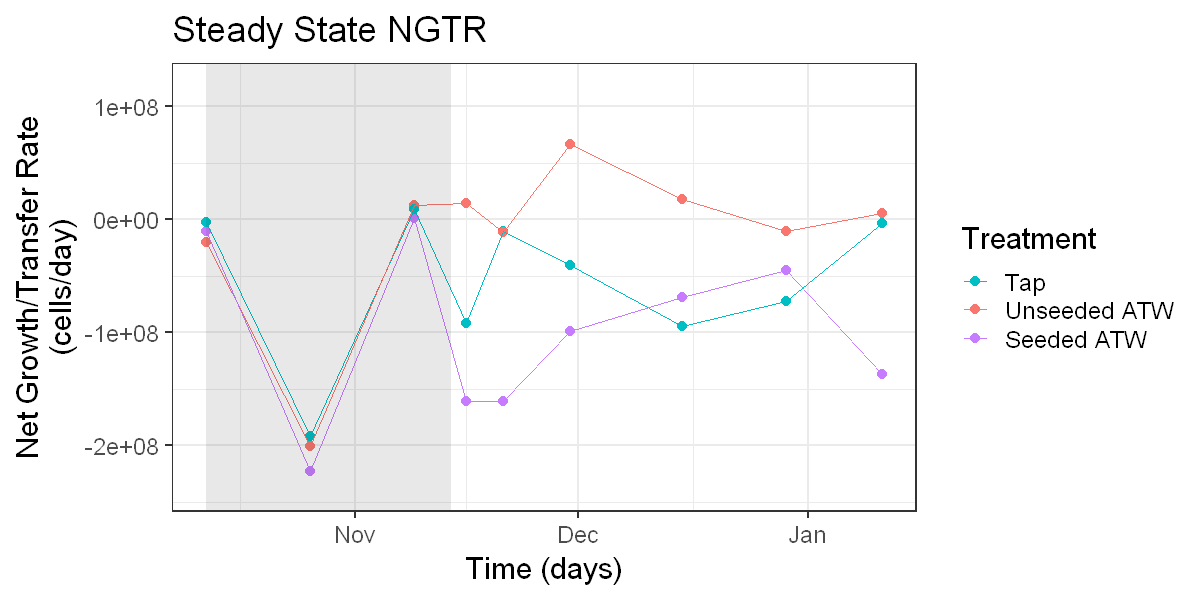

In [77]:
# Plotting
options(repr.plot.width = 10, repr.plot.height = 5)
fig_mb_ss <- ggplot(mb_ss , aes(x= Date, y= NGTR))+
    geom_point(aes(color= Treatment), size= 2.5)+
    geom_line(aes(color= Treatment))+
    scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
   #geom_smooth(aes(color= Treatment), span=0.66, method= "loess", se=FALSE, lwd=1)+
    annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "gray11") +
    ylab("Net Growth/Transfer Rate\n(cells/day)") + xlab("Time (days)") +
    theme_bw(base_size = 18) +
    labs(title = "Steady State NGTR")  + ylim(-2.4E8, 1.2E8)

    #scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
fig_mb_ss    

# ggplot(mb, aes(x= as.character(t2), y= net_growth))+
#     geom_boxplot()+
#     # annotate("rect", xmin = 0, xmax = 162, ymin = 0, ymax = Inf, alpha = 0.2, fill = "green") +
#     # annotate("rect", xmin = 162, xmax = 387, ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink") +
# scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))


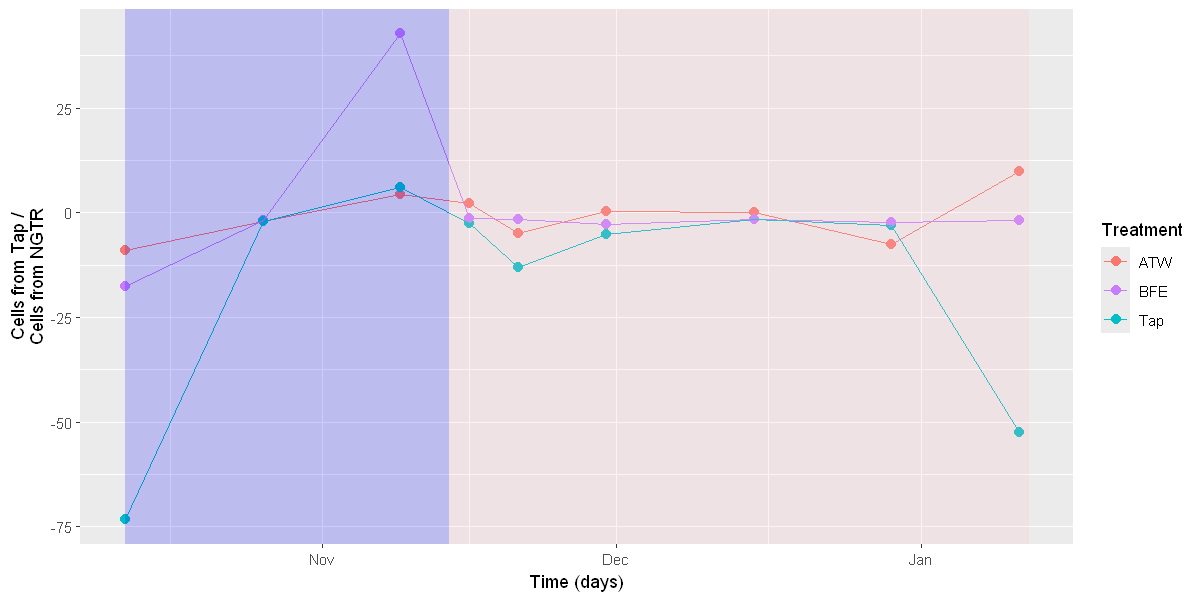

In [243]:
fig_4F <- ggplot(mb_ss , aes(x= Date, y= tap_vs_growth))+
    geom_point(aes(color= Treatment), size= 2.5)+ #aes(shape= AR_num), size= 2.5)+
    geom_line(aes(color= Treatment))+
    scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
#    scale_shape_manual(values=c(16,17,1,2,3))+
    #geom_smooth(method= "loess", se=FALSE, lwd=1, aes(color= Treatment))+
   annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "blue") +
   annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "pink") +
     xlab("Time (days)") + ylab("Cells from Tap /\nCells from NGTR")

fig_4F 

In [244]:
mb_long <- gather(mb_ss, assay,
                        value,
                        'AR_gmean','res_ICC_gmean', 'tap_IN','AR_OUT','NGTR','tap_vs_growth'
                        )

#mb_long[mb_long$value < 0, ]


Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 20 rows containing non-finite outside the scale range
(`stat_boxplot()`)."


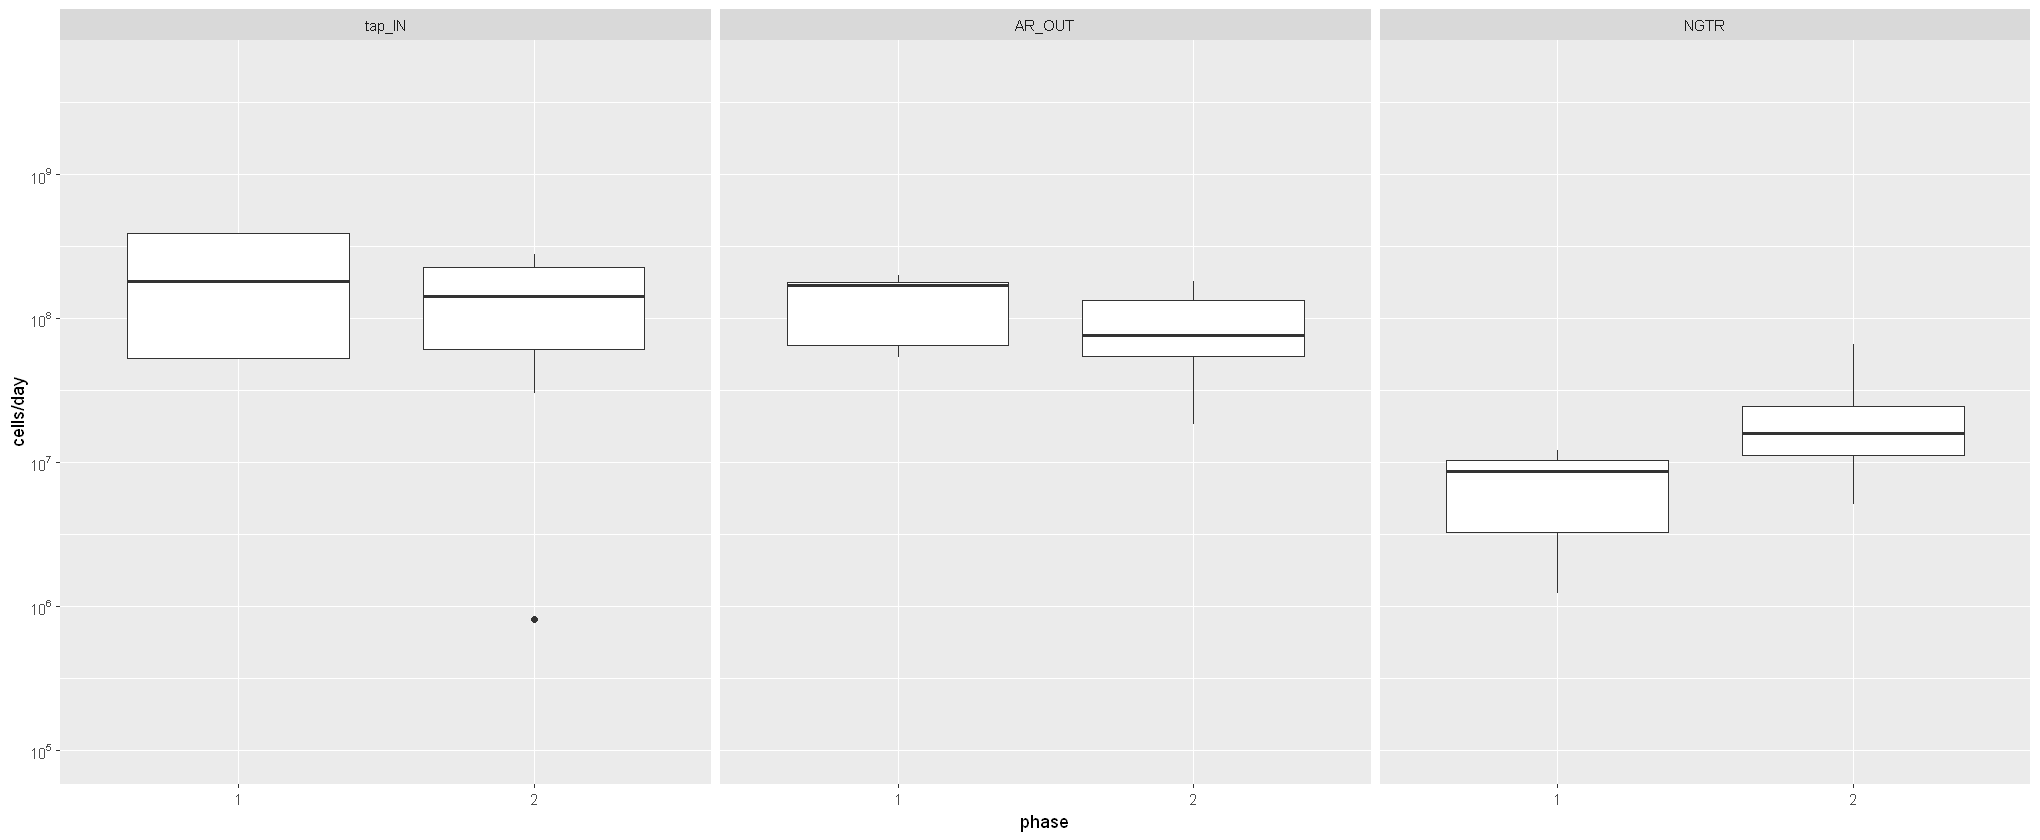

In [245]:
mb_long$assay <- factor(mb_long$assay, levels= c( 'tap_IN', 'AR_OUT', 'NGTR'))


a <- mb_long %>% subset( assay == 'tap_IN' | assay == 'AR_OUT'| assay == 'NGTR' | assay == 'AR_gmean' | assay == 'res_ICC_gmean' | assay == 'tap_vs_growth')
options(repr.plot.width = 17, repr.plot.height = 7)
fig_4B <- ggplot(a, aes(x= phase, y= value))+
    geom_boxplot()+ #aes(color= AR_num)
    # annotate("rect", xmin = 0, xmax = 162, ymin = 100000, ymax = Inf, alpha = 0.2, fill = "blue") +
    # annotate("rect", xmin = 162, xmax = 387, ymin = 100000, ymax = Inf, alpha = 0.2, fill = "pink") +
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E5, 5E9), labels = trans_format("log10", math_format(10^.x)))+
                                        ylab('cells/day')+
    facet_wrap(~assay, scales= "fixed", ncol=6)
fig_4B

## With Accumulation

dM/dt = ([sum of intact cells in reactor at t2] - [total cells in reactor at t1])/change in time = [avg tapres conc]*[flowrate] - [avg conc in reactor bulk]*[flowrate] + [net growth/decay rate in bulk and biofilm]

total cells in reactor at t1 = (ICC at t1)*volume + (bf_ICC)*surface area, where volume = 1000 mL and surface area= 

Units:
* volumes in mL (ICC is in cells/mL; reactor volume 1000 mL)
* area in cm (bf_ICC is in cells/cm2)
* time in days (flowrate converted to mL/day)

Assumptions:
* CFSTR model assumes concentration out equals the concentration anywhere in the fully mixed reactor
* Only surface area with biofilm is the surface area of the PVC slides
* Assume cell counts change linearly over t1 to t2 (hence just an average of cell counts over each time period as input)

In [78]:
#tot_new <- tot %>%  filter(Location != "Tap" & Location != "BAC_Column" & Location != "ATW" ) %>% mutate(AR_num=as.character(parse_number(as.character(Location))))
#tot_old<- tot %>% filter( Location == "Tap" | Location == "BAC_Column" | Location == "ATW"  ) %>% mutate(AR_num=Location)

#tot_n <- rbind(tot_new, tot_old)

ar_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == 'AR') %>% select(c(geomean_blanked, Date, Treatment, Number)) %>% rename(gmean = geomean_blanked) 
bf_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(samples_type == 'AR') %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
tap_subset <- tot_un %>% filter(Treatment == "Tap", samples_type == 'Feed') %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
tap <- merge(ar_subset,bf_subset, by= c("Date","Number")) %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
tap_ac <- merge(tap,tap_subset,by= "Date")

tap_subset2 <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
rare_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Unseeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
bfe_subset <- tot_un %>% filter(samples_type == "Feed", Treatment == 'Seeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
ar12_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
ar34_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Unseeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
ar56_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(samples_type == "AR" , Treatment == "Seeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf12_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(samples_type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf34_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(samples_type == "AR" , Treatment == "Unseeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf56_subset <- tot_un %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(samples_type == "AR" , Treatment == "Seeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 

tap2<- merge(ar12_subset, bf12_subset, by= c("Date","Number"))  %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
tap2_ac <- merge(tap2, tap_subset2, by= "Date") 

rare<- merge(ar34_subset, bf34_subset, by= c("Date","Number"))  %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
rare_ac <- merge(rare, rare_subset, by= "Date") 

bfe <- merge(ar56_subset,bf56_subset,by= c("Date","Number")) %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
bfe_ac <- merge(bfe, bfe_subset, by= "Date") 

mb_ac <- rbind(tap_ac,tap2_ac,rare_ac,bfe_ac)
mb_ac

ERROR: Error in eval(expr, envir, enclos): object 'tot_un' not found


In [95]:
#tot_new <- tot %>%  filter(Location != "Tap" & Location != "BAC_Column" & Location != "ATW" ) %>% mutate(AR_num=as.character(parse_number(as.character(Location))))
#tot_old<- tot %>% filter( Location == "Tap" | Location == "BAC_Column" | Location == "ATW"  ) %>% mutate(AR_num=Location)

tot_n <- tot %>% mutate(Number = case_when(
    Treatment == "Tap" ~ 1,
    Treatment == "Seeded ATW" ~ 3,
    Treatment == "Unseeded ATW" ~ 2
    
  ))

ar_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == 'AR') %>% select(c(geomean_blanked, Date, Treatment, Number)) %>% rename(gmean = geomean_blanked) 
bf_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(Sample_Type == 'AR') %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
tap_subset <- tot_n %>% filter(Treatment == "Tap", Sample_Type == 'Feed') %>% filter(phase== "Phase I") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
tap <- merge(ar_subset,bf_subset, by= c("Date","Number")) %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
tap_ac <- merge(tap,tap_subset,by= "Date")

tap_subset2 <- tot_n %>% filter(Sample_Type == "Feed", Treatment == 'Tap') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
rare_subset <- tot_n %>% filter(Sample_Type == "Feed", Treatment == 'Unseeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
bfe_subset <- tot_n %>% filter(Sample_Type == "Feed", Treatment == 'Seeded ATW') %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% select(c(geomean_blanked, Date)) %>% rename(res_ICC_gmean = geomean_blanked)
ar12_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
ar34_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Unseeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
ar56_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Bulk" ) %>% filter(Sample_Type == "AR" , Treatment == "Seeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf12_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(Sample_Type == "AR" , Treatment == "Tap" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf34_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(Sample_Type == "AR" , Treatment == "Unseeded ATW") %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 
bf56_subset <- tot_n %>% filter(!is.na(geomean_blanked)) %>% filter(phase== "Phase II") %>% filter(measurement== "ICC") %>% filter(type == "Biofilm" ) %>% filter(Sample_Type == "AR" , Treatment == "Seeded ATW" ) %>% select(c(geomean_blanked, Date, Treatment,Number)) %>% rename(gmean = geomean_blanked) 

tap2<- merge(ar12_subset, bf12_subset, by= c("Date","Number"))  %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
tap2_ac <- merge(tap2, tap_subset2, by= "Date") 

rare<- merge(ar34_subset, bf34_subset, by= c("Date","Number"))  %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
rare_ac <- merge(rare, rare_subset, by= "Date") 

bfe <- merge(ar56_subset,bf56_subset,by= c("Date","Number")) %>% rename(AR_gmean = gmean.x) %>% rename(BF_gmean = gmean.y)
bfe_ac <- merge(bfe, bfe_subset, by= "Date") 

mb_ac <- rbind(tap_ac,tap2_ac,rare_ac,bfe_ac)
mb_ac

Date,Number,AR_gmean,Treatment.x,BF_gmean,Treatment.y,res_ICC_gmean
<date>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
2022-10-12,1,178083.84,Tap,520912.58,Tap,180547.6706
2022-10-12,2,160158.04,Unseeded ATW,528050.11,Unseeded ATW,180547.6706
2022-10-12,3,170199.78,Seeded ATW,445649.11,Seeded ATW,180547.6706
2022-10-26,1,198047.78,Tap,322198.42,Tap,388178.3232
2022-10-26,2,188655.33,Unseeded ATW,235486.89,Unseeded ATW,388178.3232
2022-10-26,3,167410.63,Seeded ATW,320037.84,Seeded ATW,388178.3232
2022-11-09,1,61001.10,Tap,237762.96,Tap,52339.2369
2022-11-09,2,64326.64,Unseeded ATW,118688.54,Unseeded ATW,52339.2369
2022-11-09,3,53559.97,Seeded ATW,149244.46,Seeded ATW,52339.2369


In [96]:
# declaring an empty data frame
mb = data.frame(
  Number = character(), t1 = numeric(),t2 = numeric(),dt = numeric(), AR_ICC_gmean= numeric(), tapres_ICC_gmean = numeric(),
    AR_ICC_t1 = numeric(), AR_ICC_t2 = numeric(),tapres_ICC_t1 = numeric(), tapres_ICC_t2 = numeric(),bf_ICC_t1 = numeric(),bf_ICC_t2 = numeric(),
    stringsAsFactors = FALSE)
 
#loop to create new data frame for time points t1 and t2
# days_list <- arbf$day[(arbf$AR_num == "tapres") & !is.na(arbf$ICC_gmean)]
days_list <- mb_ac %>% filter( !is.na(AR_gmean)) %>% select(Date) 
days_list <- unique(days_list)
l= length(days_list)
flowrate= 0.7*1440 # 0.7 mL/min * 1440 min/day
surf_area = 20*15*1.5 #there are 20 slides that are 15 cm long and 1.5 cm wide
volume= 1000

for (x in 1:3) {
    for (d in 1:8) {
        t1 <- days_list[d,]
        t2 <- days_list[(d+1),]
        
        arbf_tapres <- mb_ac %>% filter(Number == x) %>% filter(!is.na(res_ICC_gmean)) 
        tapres_ICC_gmean <- exp(mean(log(arbf_tapres$res_ICC_gmean[arbf_tapres$Date >=t1 & arbf_tapres$Date <= t2])))
        
        arbf_subset <- mb_ac %>% filter(Number == x) %>% filter(!is.na(AR_gmean)) 
        
        AR_ICC_gmean <- exp(mean(log( arbf_subset$AR_gmean[ arbf_subset$Date >=t1 & arbf_subset$Date <= t2])))
        
        arbf_subset <- arbf_subset %>% filter(!is.na(BF_gmean)) 
        
        tapres_ICC_t1<-arbf_tapres$res_ICC_gmean[arbf_tapres$Date == t1][1]
        tapres_ICC_t2<-arbf_tapres$res_ICC_gmean[arbf_tapres$Date == t2][1]
        dt <- t2-t1
        AR_ICC_t1 <- mb_ac$AR_gmean[(mb_ac$Number == x) & (mb_ac$Date == t1)]
        AR_ICC_t2 <- mb_ac$AR_gmean[(mb_ac$Number == x) & (mb_ac$Date == t2)]
        bf_ICC_t1 <- mb_ac$BF_gmean[(mb_ac$Number == x) & (mb_ac$Date == t1)]
        bf_ICC_t2 <- mb_ac$BF_gmean[(mb_ac$Number == x) & (mb_ac$Date == t2)]
 

        
        
        vec <- c(x, t1, t2, dt, AR_ICC_gmean, tapres_ICC_gmean, AR_ICC_t1, AR_ICC_t2, tapres_ICC_t1, tapres_ICC_t2,bf_ICC_t1,bf_ICC_t2)    
        # assigning this vector to ith row
        i=d+(8*(x-1))
        mb[i, ] <- vec    
    }
}




In [97]:
mb$t1 <- as.Date(days_list[1:8,], format = "%Y-%m-%d")
mb$t2 <- as.Date(days_list[2:9,], format = "%Y-%m-%d")
#mb

In [98]:

#calculate new parameters 
mb["total_cells_t1"] <- (mb$AR_ICC_t1*volume) + (mb$bf_ICC_t1*surf_area)
mb["total_cells_t2"] <- (mb$AR_ICC_t2*volume) + (mb$bf_ICC_t2*surf_area)
mb["dN.dt"] = (mb$total_cells_t2 - mb$total_cells_t1)/mb$dt
mb["dN.dt_bulk"] = ((mb$AR_ICC_t2*volume) - (mb$AR_ICC_t1*volume))/mb$dt
mb["dN.dt_bf"] = ((mb$bf_ICC_t2*surf_area) - (mb$bf_ICC_t1*surf_area))/mb$dt
mb["tap_IN"] = as.numeric(mb$tapres_ICC_gmean)*flowrate 
mb["AR_OUT"] = mb$AR_ICC_gmean*flowrate #geometric mean of AR ICC at two timepoints
mb["NGTR"] <- mb["dN.dt"] + mb["AR_OUT"]- mb["tap_IN"] #units of intact cells per day
mb["phase"] <- "1"
mb$phase[mb$t2 > as.Date('2022-11-14')] <- "2"


# calculate the relative contribution of the tapres to the change in biomass
mb["tap_vs_growth"] <- mb$tap_IN/mb$NGTR


#calculate percentage of cells in biofilm over total
mb["frac_cells_bf_to_total"] <- (mb$bf_ICC_t1*surf_area) / mb$total_cells_t1

mb

,Number,t1,t2,dt,AR_ICC_gmean,tapres_ICC_gmean,AR_ICC_t1,AR_ICC_t2,tapres_ICC_t1,tapres_ICC_t2,⋯,total_cells_t2,dN.dt,dN.dt_bulk,dN.dt_bf,tap_IN,AR_OUT,NGTR,phase,tap_vs_growth,frac_cells_bf_to_total
,<chr>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,2022-10-12,2022-10-26,14,187800.72,264735.136,178083.84,198047.78,180547.6706,388178.3232,⋯,343037069,-4961245,1425995.33,-6387240.6,266853017,189303124,-82511138.0,1,-3.2341454,0.5682758
2,1,2022-10-26,2022-11-09,14,109914.21,142537.564,198047.78,61001.10,388178.3232,52339.2369,⋯,167994435,-12503045,-9789048.42,-2713996.9,143677865,110793519,-45387391.1,1,-3.1655899,0.4226636
3,1,2022-11-09,2022-11-16,7,91717.68,109535.596,61001.10,137901.33,52339.2369,229236.1802,⋯,307537183,19934678,10985746.41,8948931.8,110411881,92451421,1974218.3,2,55.9268850,0.6368862
4,1,2022-11-16,2022-11-21,5,130429.73,174990.907,137901.33,123362.95,229236.1802,133581.9562,⋯,228101329,-15887171,-2907675.96,-12979494.8,176390834,131473165,-60804839.4,2,-2.9009341,0.5515946
5,1,2022-11-21,2022-11-30,9,144050.15,166868.968,123362.95,168206.46,133581.9562,208450.7023,⋯,441211146,23678869,4982612.63,18696256.0,168203920,145202547,677495.1,2,248.2732744,0.4591748
6,1,2022-11-30,2022-12-15,15,95066.47,175383.678,168206.46,53729.41,208450.7023,147562.1535,⋯,179400122,-17454068,-7631803.48,-9822264.8,176786747,95827000,-98413815.7,2,-1.7963611,0.6187620
7,1,2022-12-15,2022-12-29,14,85683.43,175568.236,53729.41,136641.20,147562.1535,208889.6430,⋯,259430693,5716469,5922271.20,-205801.9,176972782,86368902,-84887410.8,2,-2.0847942,0.7005052
8,1,2022-12-29,2023-01-11,13,153166.64,191209.396,136641.20,171690.66,208889.6430,175025.5907,⋯,403991771,11120083,2696111.94,8423971.0,192739071,154391969,-27227019.0,2,-7.0789634,0.4733036
9,2,2022-10-12,2022-10-26,14,173823.66,264735.136,160158.04,188655.33,180547.6706,388178.3232,⋯,294624428,-7368297,2035520.78,-9403817.9,266853017,175214254,-99007059.6,1,-2.6952928,0.5973709


In [99]:
tap_mb <- mb  %>% filter(Number %in% c("1")) %>% mutate(Treatment="Tap")
atw_mb <- mb  %>% filter(Number %in% c("2")) %>% mutate(Treatment="Unseeded ATW")
bfe_mb <- mb  %>% filter(Number %in% c("3")) %>% mutate(Treatment="Seeded ATW")

mb  <- rbind(tap_mb, atw_mb,bfe_mb)



### NGTR

In [101]:
mb$Treatment <- factor(mb$Treatment , levels=c('Tap', 'Unseeded ATW', 'Seeded ATW'))


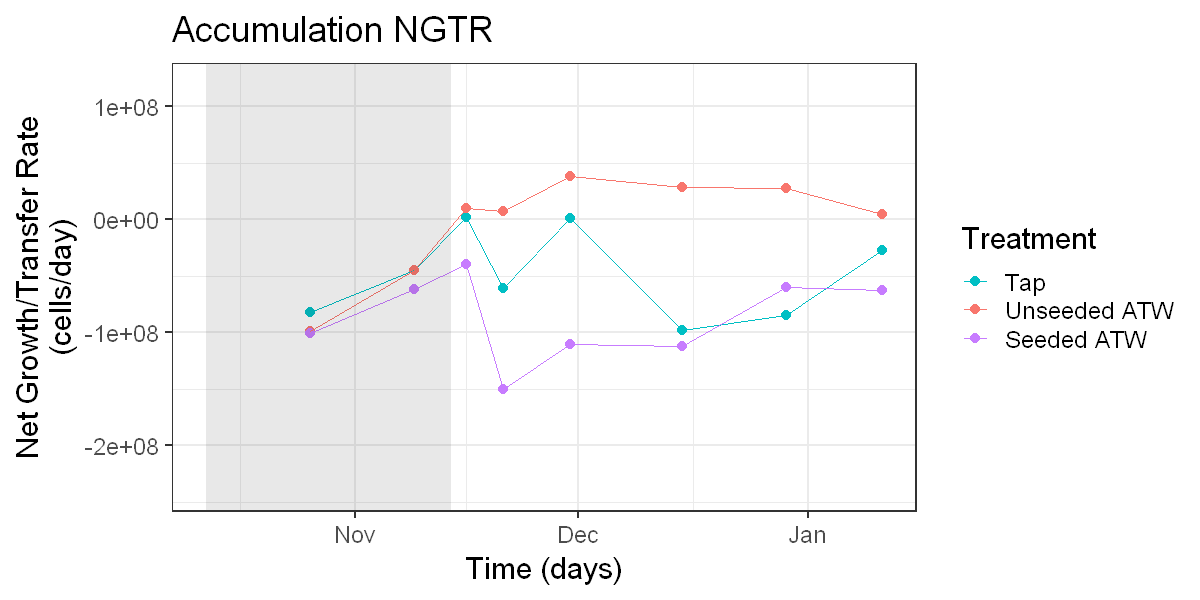

In [102]:
options(repr.plot.width = 10, repr.plot.height = 5)
fig_ac <- ggplot(mb, aes(x= t2, y= NGTR))+
    geom_point(aes(col= Treatment), size= 2.5)+ 
    geom_line(aes(color= Treatment))+
    scale_color_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
    #geom_smooth(method= "loess", se=FALSE, lwd=1, aes(color= Treatment),)+
    annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "gray11") +
    ylab("Net Growth/Transfer Rate\n(cells/day)") + xlab("Time (days)") +
    theme_bw(base_size = 18) +
    labs(title = "Accumulation NGTR")  + ylim(-2.4E8, 1.2E8)
    #scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  labels = trans_format("log10", math_format(10^.x)))
                                    
fig_ac


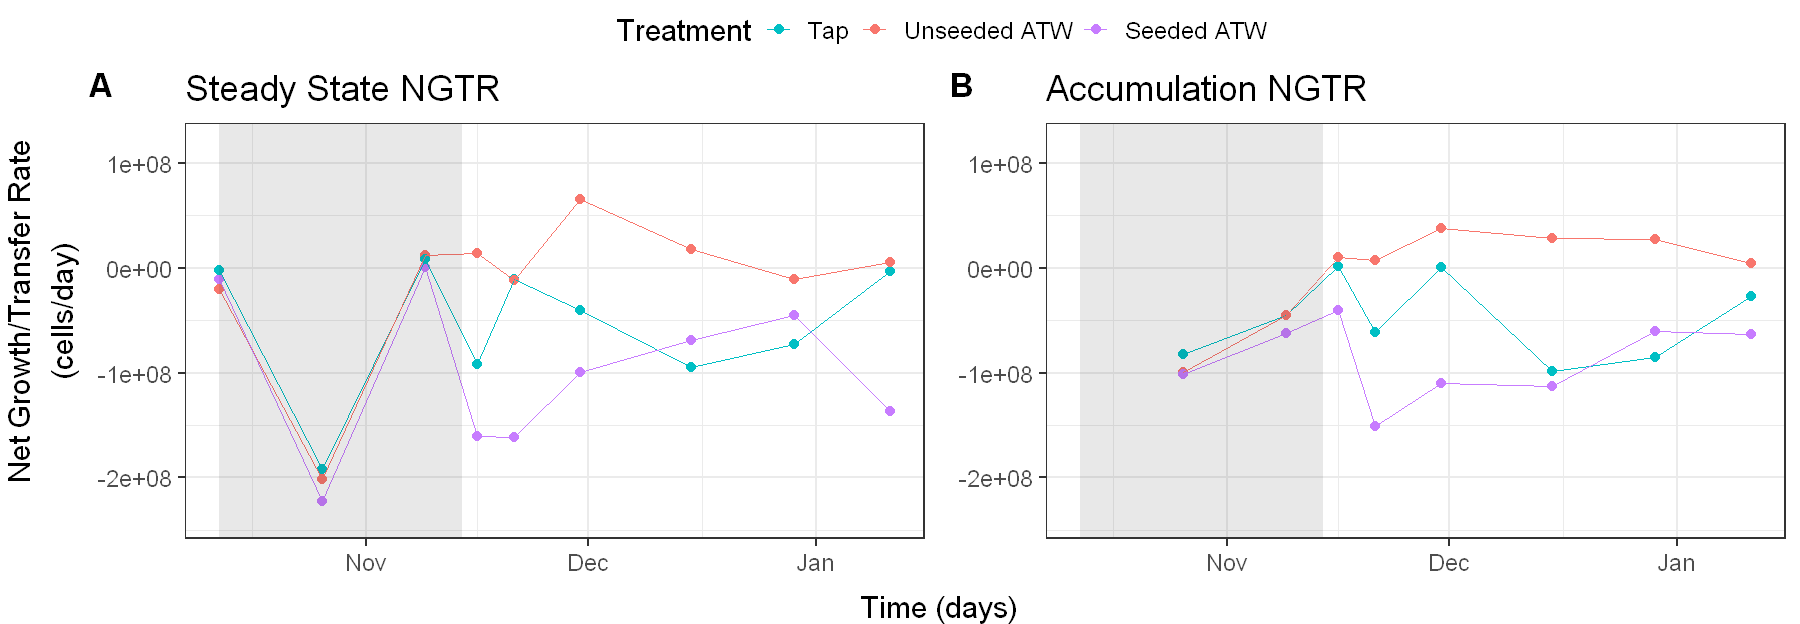

In [152]:
fig_s9<- ggarrange( fig_mb_ss+ rremove("ylab") + rremove("xlab"),fig_ac+ rremove("ylab") + rremove("xlab"), 
                   ncol=2, nrow=1, labels= c("A", "B"), font.label = list(size = 20, 
                   color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))


fig_s9<-annotate_figure(fig_s9, left = text_grob("Net Growth/Transfer Rate\n(cells/day)", rot = 90,  size = 18),
                    bottom = text_grob("Time (days)", size = 18))
fig_s9
ggsave(paste0(fig_dir, 'fig_s9.png'), width=10, height=5)

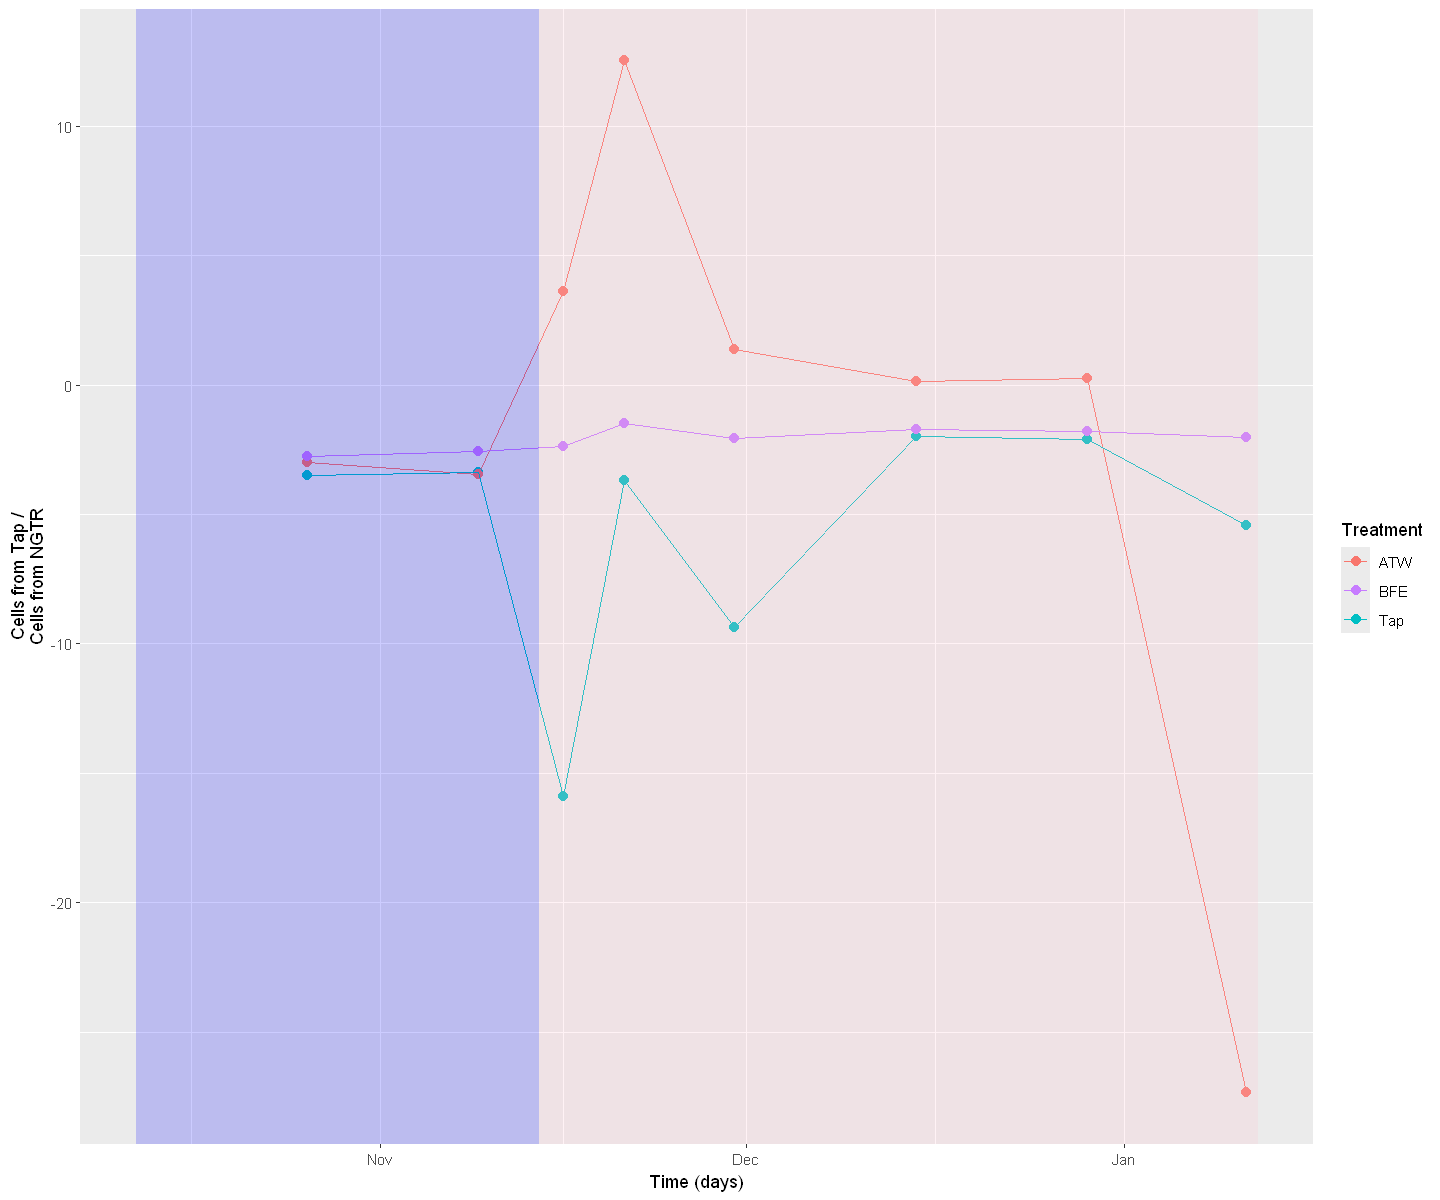

In [250]:
options(repr.plot.width = 12, repr.plot.height = 10)
fig_4E <- ggplot(mb, aes(x= t2, y= tap_vs_growth))+
    geom_point(aes(col= Treatment), size= 2.5)+ #aes(shape= AR_num), size= 2.5)+
    geom_line(aes(color= Treatment))+
    scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
   # scale_shape_manual(values=c(16,17,1,2,3))+
   # geom_smooth(method= "loess", se=FALSE, lwd=1, colour= "black")+
     # ylim(c(0, 0.02))+
    annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "blue") +
   annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "pink") +
   xlab("Time (days)") + ylab("Cells from Tap /\nCells from NGTR")
fig_4E 


In [254]:
mb_long <- gather(mb,
                        assay,
                        value, 'AR_ICC_t1','AR_ICC_t2','tapres_ICC_t1','tapres_ICC_t2','bf_ICC_t1','bf_ICC_t2','total_cells_t1','total_cells_t2',
                                 'dN.dt','tap_IN','AR_OUT','NGTR','tap_vs_growth', 'dN.dt_bulk', 'dN.dt_bf')
#mb_long



Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message:
"Removed 54 rows containing non-finite outside the scale range
(`stat_boxplot()`)."


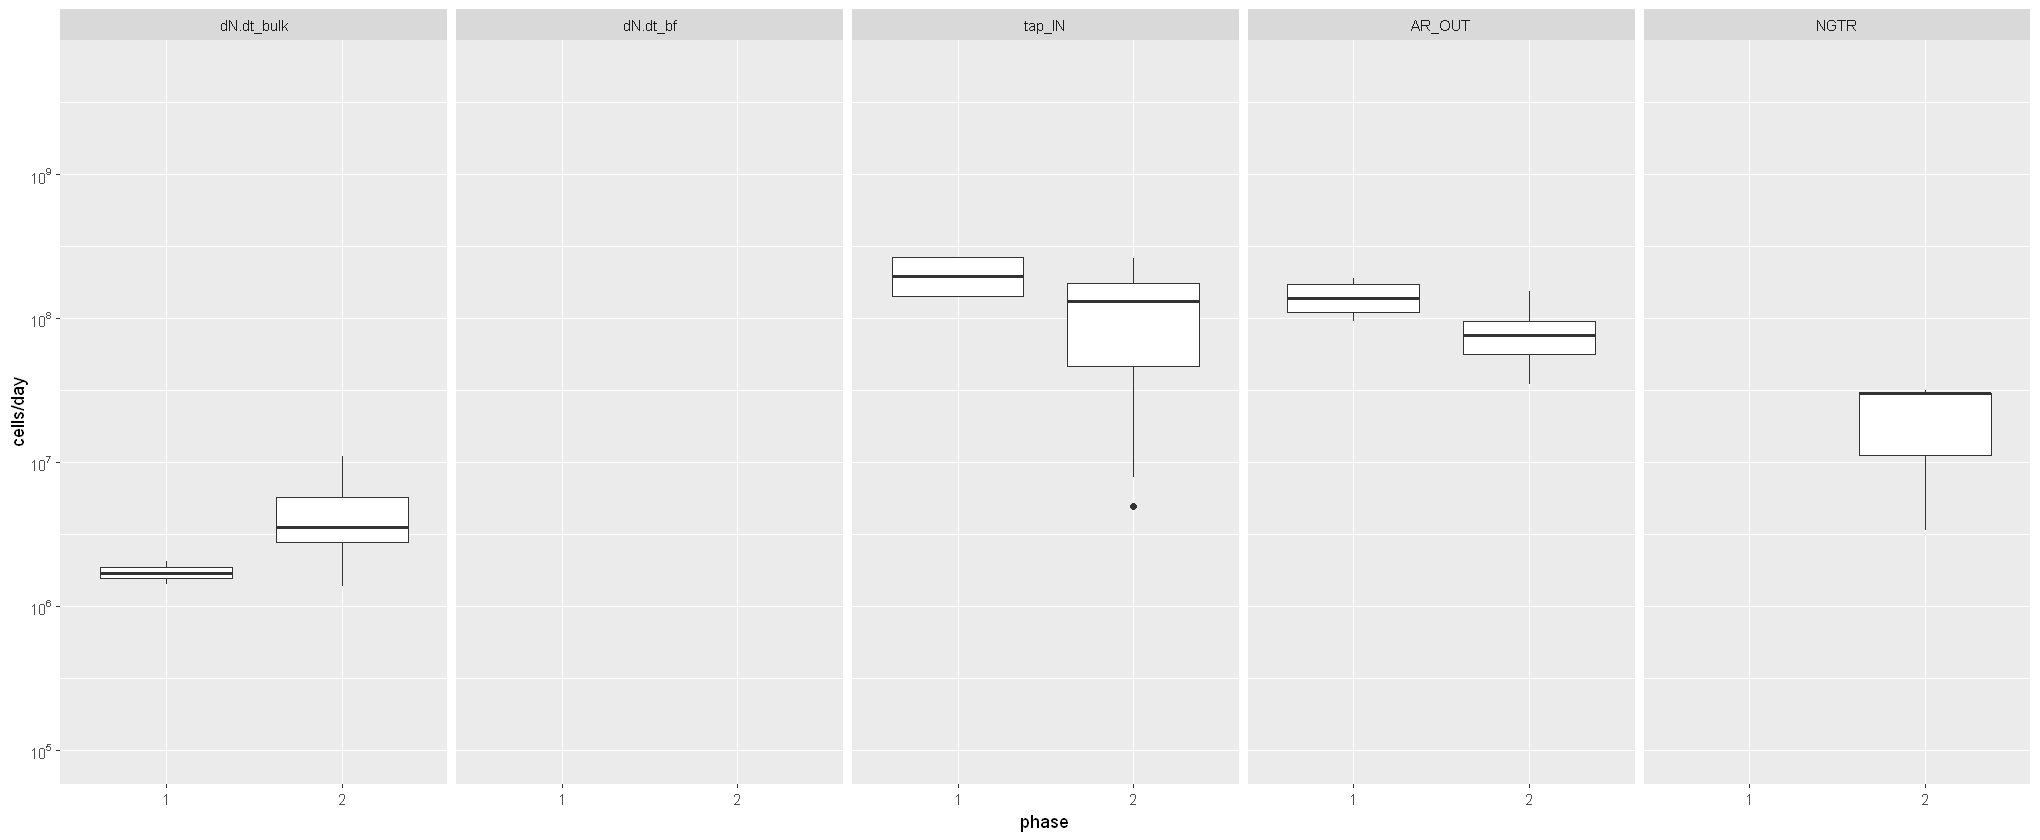

In [255]:
mb_long$assay <- factor(mb_long$assay, levels= c('dN.dt_bulk', 'dN.dt_bf', 'tap_IN', 'AR_OUT', 'NGTR'))

a <- mb_long %>% subset( assay == 'tap_IN' | assay == 'AR_OUT'| assay == 'NGTR'  | assay == 'dN.dt_bulk' | assay == 'dN.dt_bf')
options(repr.plot.width = 17, repr.plot.height = 7)
fig_4A <- ggplot(a, aes(x= phase, y= value))+
    geom_boxplot()+ #aes(color= AR_num)
    # annotate("rect", xmin = 0, xmax = 162, ymin = 100000, ymax = Inf, alpha = 0.2, fill = "blue") +
    # annotate("rect", xmin = 162, xmax = 387, ymin = 100000, ymax = Inf, alpha = 0.2, fill = "pink") +
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E5, 5E9), labels = trans_format("log10", math_format(10^.x)))+ 
      ylab('cells/day')+
    facet_wrap(~assay, scales= "fixed", ncol=6)
fig_4A 

## Fraction of cells in biofilm

### Time Series

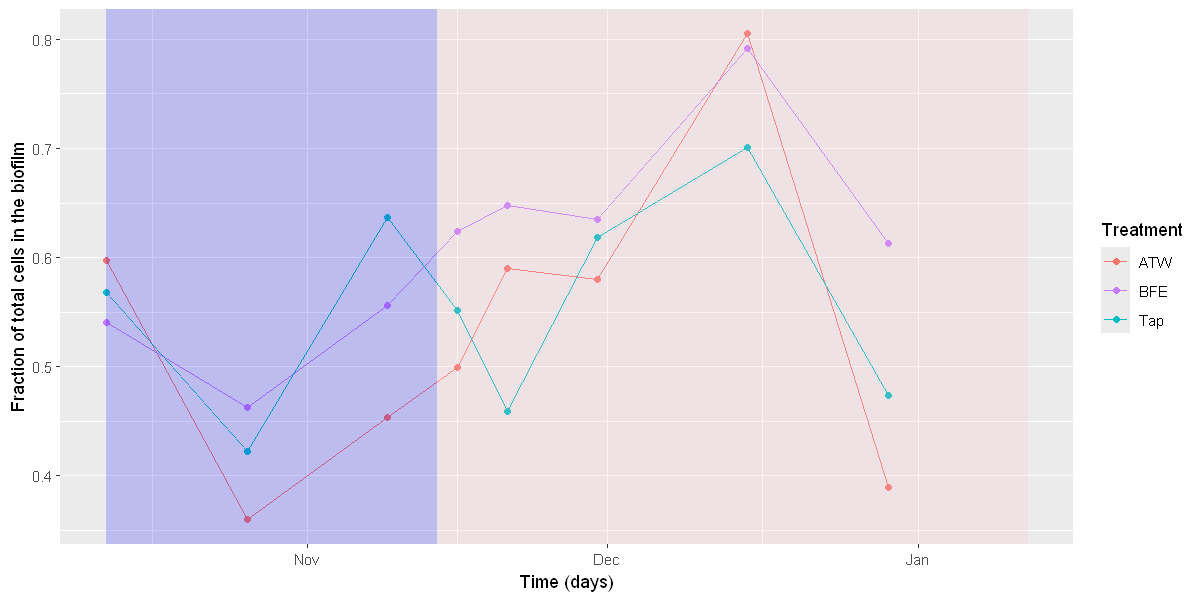

In [338]:
options(repr.plot.width = 10, repr.plot.height = 5)
fig_S10 <- ggplot(mb, aes(x= t1, y= frac_cells_bf_to_total))+
    geom_point(aes(color= Treatment))+ #aes(shape= AR_num), size= 2.5)+
    geom_line(aes(color= Treatment))+
    scale_color_manual(values = c('#F8766D',"#C77CFF","#00BFC4") )+ 
  # scale_shape_manual(values=c(16,17,1,2,3))+
    #geom_smooth(method= "loess", se=FALSE, lwd=1, colour= "black")+
#     geom_rect(aes(xmin=0,xmax=50,ymin=-Inf,ymax=Inf),alpha=0.1,fill="green")+
   annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "blue") +
   annotate("rect", xmin = as.Date('2022-11-14'), xmax = as.Date('2023-01-12'), ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "pink") +
    ylab("Fraction of total cells in the biofilm") + xlab("Time (days)") 
# scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),  labels = trans_format("log10", math_format(10^.x)))
                                    
fig_S10

### Boxplot

In [111]:
mb_new <- mb %>% mutate(phase = recode(phase, '1' = 'Phase 1')) %>% mutate(phase = recode(phase, '2' = 'Phase 2'))
mb_new <- mb_new %>% mutate(label = recode(Treatment, 'Unseeded ATW' = 'uATW', 'Seeded ATW' = 'sATW'))


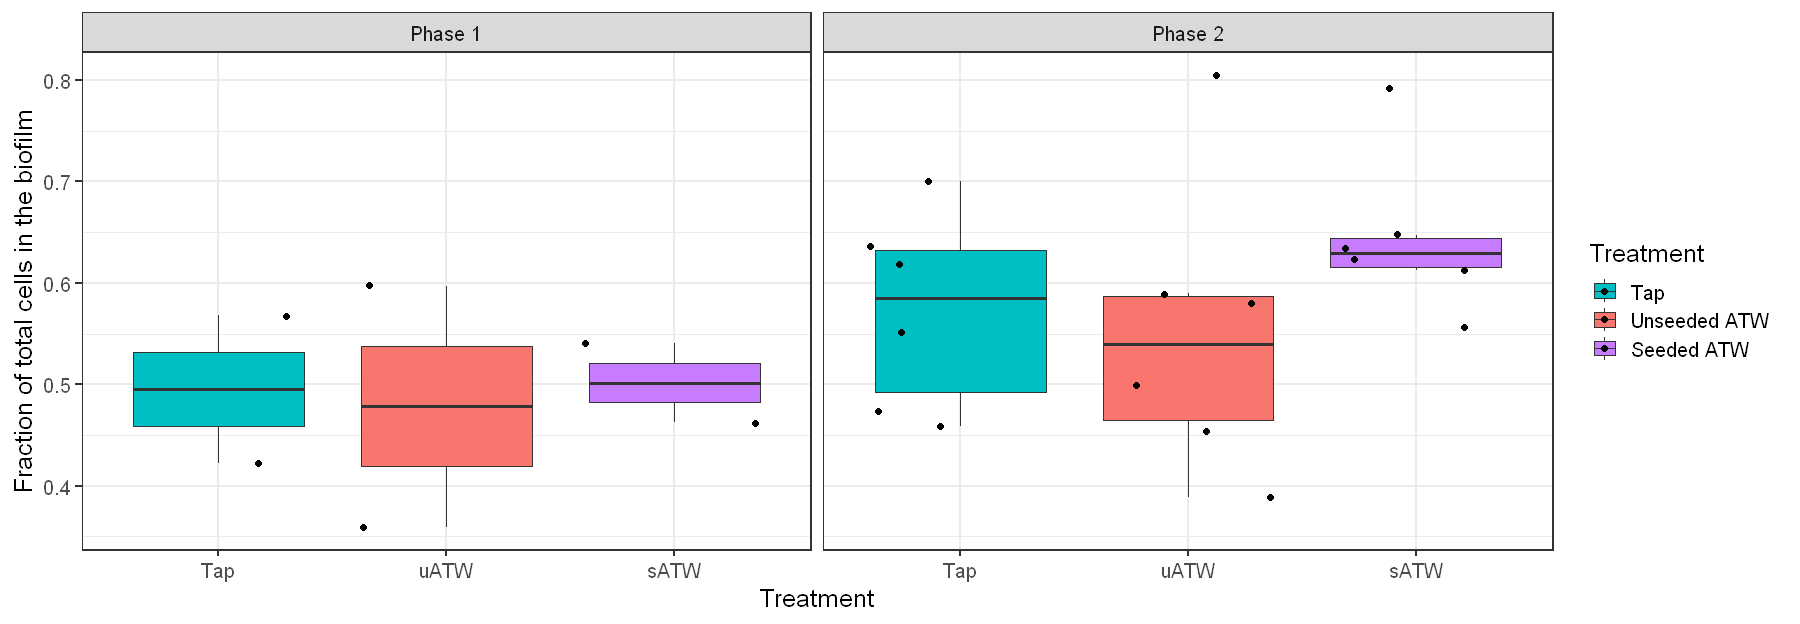

In [153]:
fig_s10 <- ggplot(mb_new, aes(x= label, y= frac_cells_bf_to_total, fill=Treatment))+
    geom_boxplot(outlier.shape = NA)+ 
    geom_point( position= 'jitter')+
    scale_fill_manual(values = c("#00BFC4",'#F8766D',"#C77CFF") )+ 
   # scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), limits= c(1E2, 2E6), labels = trans_format("log10", math_format(10^.x)))+ 
    ylab("Fraction of total cells in the biofilm") + xlab("Treatment") +
 #   geom_vline(xintercept = 6.5,size=1)+                                    
 #   geom_vline(xintercept = 3.5,size=1)+  
                                        #facet_wrap(~type, scales= "free", ncol=2) +
   # geom_rect(data = subset(tp,phase == 'Phase I'), fill = "blue1", xmin = -Inf,xmax = Inf,
  #          ymin = -Inf,ymax = Inf,alpha = 0.1)+
  #  geom_rect(data = subset(tp,phase == 'Phase II'), fill = "pink1", xmin = -Inf,xmax = Inf,
   #         ymin = -Inf,ymax = Inf,alpha = 0.2)+
    facet_wrap('phase', scales='fixed' )  +
    theme(axis.text.x = element_text(face = "bold")) +
    theme_bw(base_size = 15 )
                                        
fig_s10
           
ggsave(paste0(fig_dir, 'fig_s10.png'), width=10, height=5)

## Water Quality Plots

In [55]:
# Averaging ARs

new_rep<-rep(4:6,times=18)

ARs_Tap_1 <- FCM_std %>% dplyr::filter(Location %in% "AR1") %>%  mutate(Source="Tap ARs") 
ARs_Tap_2<- FCM_std %>% dplyr::filter (Location %in% "AR2") %>%  mutate(Source="Tap ARs") %>% mutate(Replicate=new_rep)  
ARs_Tap <- rbind(ARs_Tap_1,ARs_Tap_2) 

ARs_ATW_1 <- FCM_std %>% dplyr::filter(Location %in% "AR3") %>%  mutate(Source="ATW ARs") 
ARs_ATW_2<- FCM_std %>% dplyr::filter (Location %in% "AR4") %>%  mutate(Source="ATW ARs") %>% mutate(Replicate=new_rep)  
ARs_ATW <- rbind(ARs_ATW_1,ARs_ATW_2) 

ARs_BFE_1 <- FCM_std %>% dplyr::filter(Location %in% "AR5") %>%  mutate(Source="BFE ARs") 
ARs_BFE_2<- FCM_std %>% dplyr::filter (Location %in% "AR6") %>%  mutate(Source="BFE ARs") %>% mutate(Replicate=new_rep)  
ARs_BFE <- rbind(ARs_BFE_1,ARs_BFE_2) 


BFs_Tap_1 <- FCM_std %>% dplyr::filter(Location %in% "BF1") %>%  mutate(Source="Tap BFs") 
BFs_Tap_2<- FCM_std %>% dplyr::filter (Location %in% "BF2") %>%  mutate(Source="Tap BFs") %>% mutate(Replicate=new_rep)  
BFs_Tap <- rbind(BFs_Tap_1,BFs_Tap_2) 

BFs_ATW_1 <- FCM_std %>% dplyr::filter(Location %in% "BF3") %>%  mutate(Source="ATW BFs") 
BFs_ATW_2<- FCM_std %>% dplyr::filter (Location %in% "BF4") %>%  mutate(Source="ATW BFs") %>% mutate(Replicate=new_rep)  
BFs_ATW <- rbind(BFs_ATW_1,BFs_ATW_2) 

BFs_BFE_1 <- FCM_std %>% dplyr::filter(Location %in% "BF5") %>%  mutate(Source="BFE BFs") 
BFs_BFE_2<- FCM_std %>% dplyr::filter (Location %in% "BF6") %>%  mutate(Source="BFE BFs") %>% mutate(Replicate=new_rep)  
BFs_BFE <- rbind(BFs_BFE_1,BFs_BFE_2) 


ARs <- rbind(ARs_Tap,ARs_ATW,ARs_BFE,BFs_Tap,BFs_ATW,BFs_BFE) %>% reshape(timevar =  "Replicate", v.names = "TCC_density", idvar=c("Date","Stain","Source"), direction="wide")

Tap <- FCM_std %>% dplyr::filter(Location %in% "Tap") %>% mutate(Source="Tap") 
ATW <- FCM_std %>% dplyr::filter(Location %in% "RAR") %>% mutate(Source="ATW") 
BFE <- FCM_std %>% dplyr::filter(Location %in% "BFE") %>% mutate(Source="BFE") 
BAC <- FCM_std %>% dplyr::filter(Location %in% "BAC") %>% mutate(Source="BAC") 
Blk <- FCM_std %>% dplyr::filter(Location %in% "Blk") %>% mutate(Source="Blk") 


Sources <- rbind(Tap,ATW,BFE,BAC,Blk) %>% reshape(timevar =  "Replicate", v.names = "TCC_density", idvar=c("Date","Stain","Source"), direction="wide")

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
"some constant variables (X,Location,Sample,TCC_count) are really varying"
Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
"some constant variables (X,Sample,TCC_count) are really varying"


In [85]:
Sources[,c(8:10)]

,TCC_density.1,TCC_density.2,TCC_density.3
,<int>,<int>,<int>
1,267060,259620,240960
4,191520,171820,164880
7,250840,252140,257800
10,185380,183340,177400
13,521500,516100,521720
16,370820,403720,392400
19,85480,79300,82660
22,54680,45520,60980
25,300100,309800,303940


In [86]:
# Adding means and sd 
ARs_new <- ARs %>% filter_at(vars(TCC_density.1,TCC_density.2,TCC_density.3,TCC_density.4,TCC_density.5,TCC_density.6),any_vars(!is.na(.)))  %>% mutate(geomean = apply(ARs[,c(8:13)], 1, function(x) exp(mean(log(x))))) %>% mutate(geosd = apply(ARs[,c(8:13)], 1, function(x) exp(sd(log(x))))) %>% dplyr::select(-c(8:13))




Sources_new <- Sources %>% filter_at(vars(TCC_density.1,TCC_density.2,TCC_density.3),any_vars(!is.na(.)))  %>% mutate(geomean = apply(Sources[,c(8:10)], 1, function(x) exp(mean(log(x))))) %>% mutate(geosd = apply(Sources[,c(8:10)], 1, function(x) exp(sd(log(x))))) %>% dplyr::select(-c(8:10))


meta_ave <- rbind(ARs_new ,Sources_new)

meta_ave$Date = as.Date(meta_ave$Date, format = "%d-%b-%Y")

In [87]:
ar_long <- gather(ar_full,
                        cols = c('qubit_clean','pH','temp','cl_total','cl_free','ATPt_avg_nM','ATPe_avg_nM','ATPi_avg_nM','flow_rate_mL.min','TCC_gmean','ICC_gmean','bf_TCC_gmean','bf_ICC_gmean', 'bf_ATPi_avg_nmol.cm2', 'bf_ATPt_avg_nmol.cm2'),
                        names_to = 'assay',
                        values_to = 'value')
# ar_long <- subset(ar_long, select= -c(type))
arbf_long <- pivot_longer(arbf,
                        cols = c('qubit_clean','pH','temp','cl_total','cl_free','ATPt_avg_nM','ATPe_avg_nM','ATPi_avg_nM','flow_rate_mL.min','TCC_gmean','ICC_gmean','bf_TCC_gmean','bf_ICC_gmean', 'bf_ATPi_avg_nmol.cm2', 'bf_ATPt_avg_nmol.cm2'),
                        names_to = 'assay',
                        values_to = 'value')


ERROR: [1m[33mError[39m in `gather()`:[22m
[1m[22m[33m![39m Arguments in `...` must be passed by position, not name.
[31mx[39m Problematic arguments:
[36m*[39m cols = c(...)
[36m*[39m names_to = "assay"
[36m*[39m values_to = "value"


In [ ]:
## Plot time series of bulk water parameters in linear scale
options(repr.plot.width = 12, repr.plot.height = 8)
a <- ar_long %>% subset( assay == "TCC_gmean" | assay == "ICC_gmean") %>% rename(Reactor= AR_num)
a$assay[a$assay == "TCC_gmean"] <- "Total"
a$assay[a$assay == "ICC_gmean"]  <- "Intact/Intracellular"

fig_2A <- ggplot(a, aes(x= day, y= value))+
    geom_point(aes(shape= assay))+
    scale_shape_manual(values=c(1, 16))+    
    # geom_point(aes(shape= Reactor))+
    # scale_shape_manual(values=c(16,17,1,2,3))+
    geom_smooth(method= "loess", se=FALSE, lwd=1, color= "black", aes(linetype = assay))+
    scale_linetype_manual(values=c("twodash", "solid"))+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))+
    annotate("rect", xmin = 0, xmax = 162, ymin = 0, ymax = Inf, alpha = 0.2, fill = "blue") +
    annotate("rect", xmin = 162, xmax = 387, ymin = 0, ymax = Inf, alpha = 0.2, fill = "pink") +
    ylab("Bulk Cell Counts (cells/mL)")+ labs(linetype='') +
     theme(panel.background=element_blank(),legend.position="top", panel.border=element_rect(color = "black", fill = NA))
fig_2A       

# Fingerprinting

## Alpha diversity

In [85]:
adiv<- read.csv('Adiv_df.csv')

In [86]:
adiv["phase"] <- "1"
adiv$phase[adiv$Date > as.Date('2022-11-14')] <- "2"

In [87]:
adiv

Sample_name,D0,D1,sd.D1,D2,sd.D2,Date,Location,Stain,Replicate,TCC_count,TCC_density,phase
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
01-DEC-2022_AR1_SG_1,11284,3851.492,49.67259,2161.341,40.73185,2022-12-01,AR1,SG,1,14015,280300,2
01-DEC-2022_AR1_SG_2,10471,3541.480,45.97499,1973.873,38.81170,2022-12-01,AR1,SG,2,13691,273820,2
01-DEC-2022_AR1_SG_3,11151,3979.618,47.54531,2279.128,43.25080,2022-12-01,AR1,SG,3,12863,257260,2
01-DEC-2022_AR1_SGPI_1,12680,4781.841,59.67337,2708.686,60.16406,2022-12-01,AR1,SGPI,1,11033,220660,2
01-DEC-2022_AR1_SGPI_2,12180,4444.216,60.63586,2482.416,53.88856,2022-12-01,AR1,SGPI,2,11599,231980,2
01-DEC-2022_AR1_SGPI_3,12676,4926.144,53.19929,2896.658,48.44747,2022-12-01,AR1,SGPI,3,10886,217720,2
01-DEC-2022_AR2_SG_1,11916,3950.239,56.17081,2128.691,47.44063,2022-12-01,AR2,SG,1,15474,309480,2
01-DEC-2022_AR2_SG_2,10797,3611.714,48.48219,2025.776,41.48351,2022-12-01,AR2,SG,2,15020,300400,2
01-DEC-2022_AR2_SG_3,11081,4072.824,48.52844,2411.138,46.03218,2022-12-01,AR2,SG,3,14529,290580,2


In [88]:
#phase II, ICC, 
p= 2
AR1_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR1") %>% dplyr::select(D2) %>% drop_na()
AR2_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR2") %>% dplyr::select(D2) %>% drop_na()
AR3_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR3") %>% dplyr::select(D2) %>% drop_na()
AR4_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR4") %>% dplyr::select(D2) %>% drop_na()
AR5_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR5") %>% dplyr::select(D2) %>% drop_na()
AR6_ICC <- adiv  %>% filter(Stain== 'SG')  %>% filter(phase== p) %>% filter(Location== "AR6") %>% dplyr::select(D2) %>% drop_na()


# wilcox.test(arbf$ICC_gmean[arbf$phase== "1"], arbf$ICC_gmean[arbf$phase== "2"], conf.level= 0.95) 
wilcox.test(AR1_ICC$D2, AR2_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$D2, AR3_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$D2, AR4_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR1_ICC$D2, AR5_ICC$D2, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR1_ICC$D2, AR6_ICC$D2, conf.level= 0.95) #statistically different (<0.05) 
wilcox.test(AR3_ICC$D2, AR2_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR4_ICC$D2, AR2_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$D2, AR2_ICC$D2, conf.level= 0.95) #statistically different (<0.05)
wilcox.test(AR6_ICC$D2, AR2_ICC$D2, conf.level= 0.95) #statistically different (<0.05)
wilcox.test(AR3_ICC$D2, AR4_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$D2, AR5_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR3_ICC$D2, AR6_ICC$D2, conf.level= 0.95) #not statistically different 
wilcox.test(AR5_ICC$D2, AR4_ICC$D2, conf.level= 0.95) #statistically different (<0.05)
wilcox.test(AR6_ICC$D2, AR4_ICC$D2, conf.level= 0.95) #statistically different (<0.05)
wilcox.test(AR6_ICC$D2, AR5_ICC$D2, conf.level= 0.95) #not statistically different 



	Wilcoxon rank sum exact test

data:  AR1_ICC$D2 and AR2_ICC$D2
W = 108, p-value = 0.09071
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$D2 and AR3_ICC$D2
W = 75, p-value = 0.005177
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$D2 and AR4_ICC$D2
W = 58, p-value = 0.0006624
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$D2 and AR5_ICC$D2
W = 95, p-value = 0.03421
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR1_ICC$D2 and AR6_ICC$D2
W = 94, p-value = 0.03149
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$D2 and AR2_ICC$D2
W = 213, p-value = 0.1108
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR4_ICC$D2 and AR2_ICC$D2
W = 230, p-value = 0.03149
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$D2 and AR2_ICC$D2
W = 191, p-value = 0.3717
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$D2 and AR2_ICC$D2
W = 188, p-value = 0.4245
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$D2 and AR4_ICC$D2
W = 149, p-value = 0.696
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$D2 and AR5_ICC$D2
W = 179, p-value = 0.6058
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR3_ICC$D2 and AR6_ICC$D2
W = 178, p-value = 0.6279
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR5_ICC$D2 and AR4_ICC$D2
W = 135, p-value = 0.4064
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$D2 and AR4_ICC$D2
W = 127, p-value = 0.2788
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  AR6_ICC$D2 and AR5_ICC$D2
W = 164, p-value = 0.9626
alternative hypothesis: true location shift is not equal to 0


ICC, phase 2: AR1 & AR5, AR1 & AR6, AR2 & AR5, AR2 & AR6, AR4 & AR5, AR4 & AR6, are statistically significant in terms of alpha diversity for phase 2.

TCC, phase 2: AR1 & AR3, AR1 & AR4, AR1 & AR5, AR1 & AR6, AR2 & AR4,  are statistically significant in terms of alpha diversity for phase 2.

ICC, phase 1: AR1 & AR5, AR1 & AR6, AR2 & AR6, are statistically different in terms of alpha diversity for phase 1.

TCC, phase 1: AR1 & AR5, AR1 & AR6, AR2 & AR5, AR2 & AR6, AR3 & AR6, AR4 & AR6 are statistically different in terms of alpha diversity for phase 1.

ICC, overall: none statistically significant in terms of alpha diversity for overall.

TCC, overall: AR1 & AR4, AR4 & AR6 are statistically significant in terms of alpha diversity overall.

## Plot alpha diversity

In [100]:
adiv %>% filter(Stain == 'SG',phase == '2',Location !='Count') %>% group_by(Location,Date) %>% summarize()

`summarise()` has grouped output by 'Location'. You can override using the
`.groups` argument.


Location,Date
<chr>,<chr>
AR1,2022-11-17
AR1,2022-11-22
AR1,2022-12-01
AR1,2022-12-16
AR1,2022-12-30
AR1,2023-01-12
AR2,2022-11-17
AR2,2022-11-22
AR2,2022-12-01


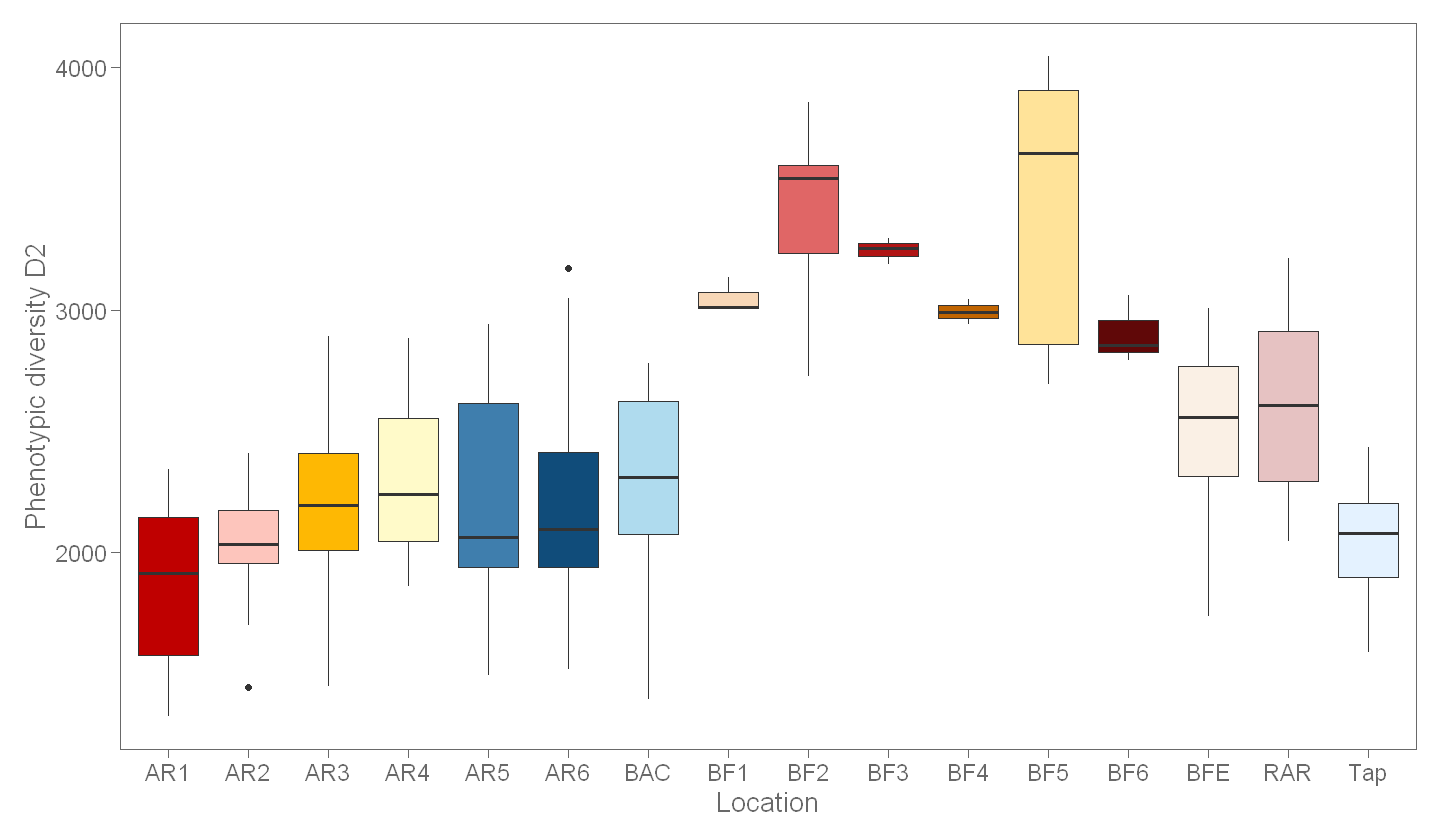

In [101]:
options(repr.plot.width = 12, repr.plot.height = 7)

# Plot 
plot_D2 <- ggplot(adiv %>% filter(Stain == 'SG',phase == '2',Location !='Count'), aes(x=Location, y=D2)) +
  geom_boxplot(aes(fill = Location),alpha = 1,show.legend = FALSE)+
  scale_fill_manual(values=colors3) +
  labs(x="Location", y="Phenotypic diversity D2",colour="Location") +
  theme(legend.position = "right", panel.grid.major = element_line(colour=NA),
        panel.grid.minor = element_line(colour=NA))
plot_D2 <- papertheme(plot_D2)
plot_D2

## Plot Beta Diversity

# Periodicity

when feed water changed

when tubing changed


In [228]:
#adjust by 1 day HRT?
replaced_new <- c('2022-11-14', '2022-11-28', '2022-12-05','2022-12-12', '2022-12-20') 
replaced_2_5 <- c('2022-11-17', '2022-11-19','2022-12-01','2022-12-08', '2022-12-15', '2022-12-29', '2023-01-02', '2023-01-06', '2023-01-09','2023-01-12')
replaced_veryold <- c('2022-11-22', '2022-12-22') 

replaced_tubing <- c('2022-11-07', '2022-12-07', '2023-01-05') 


Warning message in geom_vline(xintercept = as.integer(as.Date(replaced_tubing)), :
"Ignoring unknown parameters: `label`"
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
"log-10 transformation introduced infinite values."


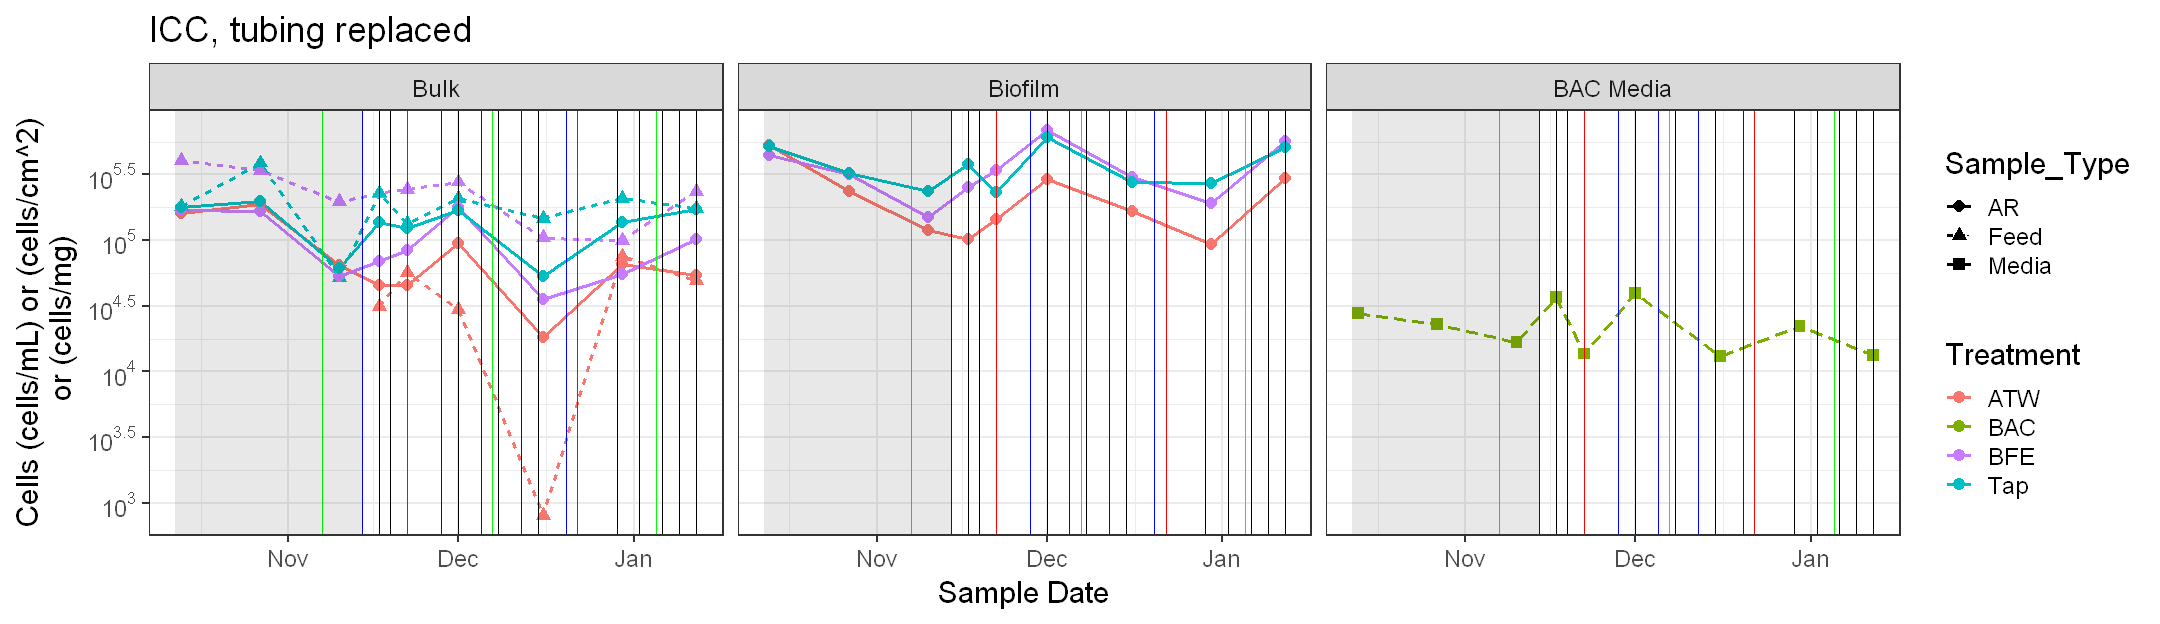

In [232]:
options(repr.plot.width=18, repr.plot.height=5.2)

plot_fcm <- ggplot(FCM_mean  %>% filter(Stain == 'SGPI'), 
                   aes(x=Date, y=geomean_blanked, color=Treatment, shape= Sample_Type, linetype = Sample_Type))+  
# scale_shape_manual(values = c(22,3,42)) +
 geom_line(size=1)+
 geom_point(size=3)+
 scale_color_manual(values = c('#F8766D',"#7CAE00","#C77CFF","#00BFC4")) +

 #geom_smooth(method= "loess",  span = 0.66, se=FALSE, lwd=1.5)+
 geom_errorbar(aes(ymin=geomean_blanked-geosd, ymax=geomean_blanked+geosd), width=0.2, position=position_dodge(0.05)) +
 labs(title = "ICC, tubing replaced", x="Sample Date", y="Cells (cells/mL) or (cells/cm^2)\n or (cells/mg)") + 
 geom_vline(xintercept = as.integer(as.Date(replaced_2_5)), colour="black") +
 geom_vline(xintercept = as.integer(as.Date(replaced_new)), colour="blue") +
 geom_vline(xintercept = as.integer(as.Date(replaced_veryold)), colour="red") +
 geom_vline(xintercept = as.integer(as.Date(replaced_tubing)), colour="green", label='Tubing Replaced') +

 scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),   labels = trans_format("log10", math_format(10^.x))) +
# scale_y_continuous(trans = log10_trans(), labels = trans_format("log10", math_format(10^.x))) +
 annotate("rect", xmin = as.Date('2022-10-12'), xmax = as.Date('2022-11-14'), ymin = 0, ymax = Inf, alpha = 0.1, fill = "gray11") +
 facet_wrap('type', scales = "fixed")+
 theme_bw(base_size = 18) 

plot_fcm

ggsave(paste0(fig_dir, 'fig_s5.png'), width=18, height=5.2)                                    

least squares fit of sine wave 


https://stats.stackexchange.com/questions/60994/fit-a-sinusoidal-term-to-data

In [551]:
FCM_mean["phase"] <- "1"
FCM_mean$phase[FCM_mean$Date > as.Date('2022-11-14')] <- "2"

In [421]:
nls.mod <- nls(ICC ~ sin(2*pi/c*as.integer(as.Date(Date))),start=list( c=1))
co <- coef(nls.mod) 
f <- function(x,  c) {sin(2*pi*c*x) }

curve(f(x,  c=co["c"]), add=TRUE ,lwd=2, col="steelblue")

ERROR: Error in nls(ICC ~ sin(2 * pi * c * as.integer(as.Date(Date))), start = list(c = 1)): step factor 0.000488281 reduced below 'minFactor' of 0.000976562


In [548]:
diff(as.integer(as.Date(replaced_new)))

[1] 14  7  7  8

[1] 2

[1] 2


Call:
lm(formula = ICC ~ sin(2 * pi/per * as.integer(as.Date(Date))) + 
    cos(2 * pi/per * as.integer(as.Date(Date))))

Residuals:
     1      2      3      4      5      6 
 -4919 -19857  12458  -4972  24829  -7538 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                  3.387e+04  1.083e+04   3.127
sin(2 * pi/per * as.integer(as.Date(Date))) -1.179e+16  6.045e+15  -1.950
cos(2 * pi/per * as.integer(as.Date(Date))) -4.618e+04  1.683e+04  -2.743
                                            Pr(>|t|)  
(Intercept)                                   0.0522 .
sin(2 * pi/per * as.integer(as.Date(Date)))   0.1463  
cos(2 * pi/per * as.integer(as.Date(Date)))   0.0711 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20590 on 3 degrees of freedom
Multiple R-squared:  0.7335,	Adjusted R-squared:  0.5558 
F-statistic: 4.128 on 2 and 3 DF,  p-value: 0.1376


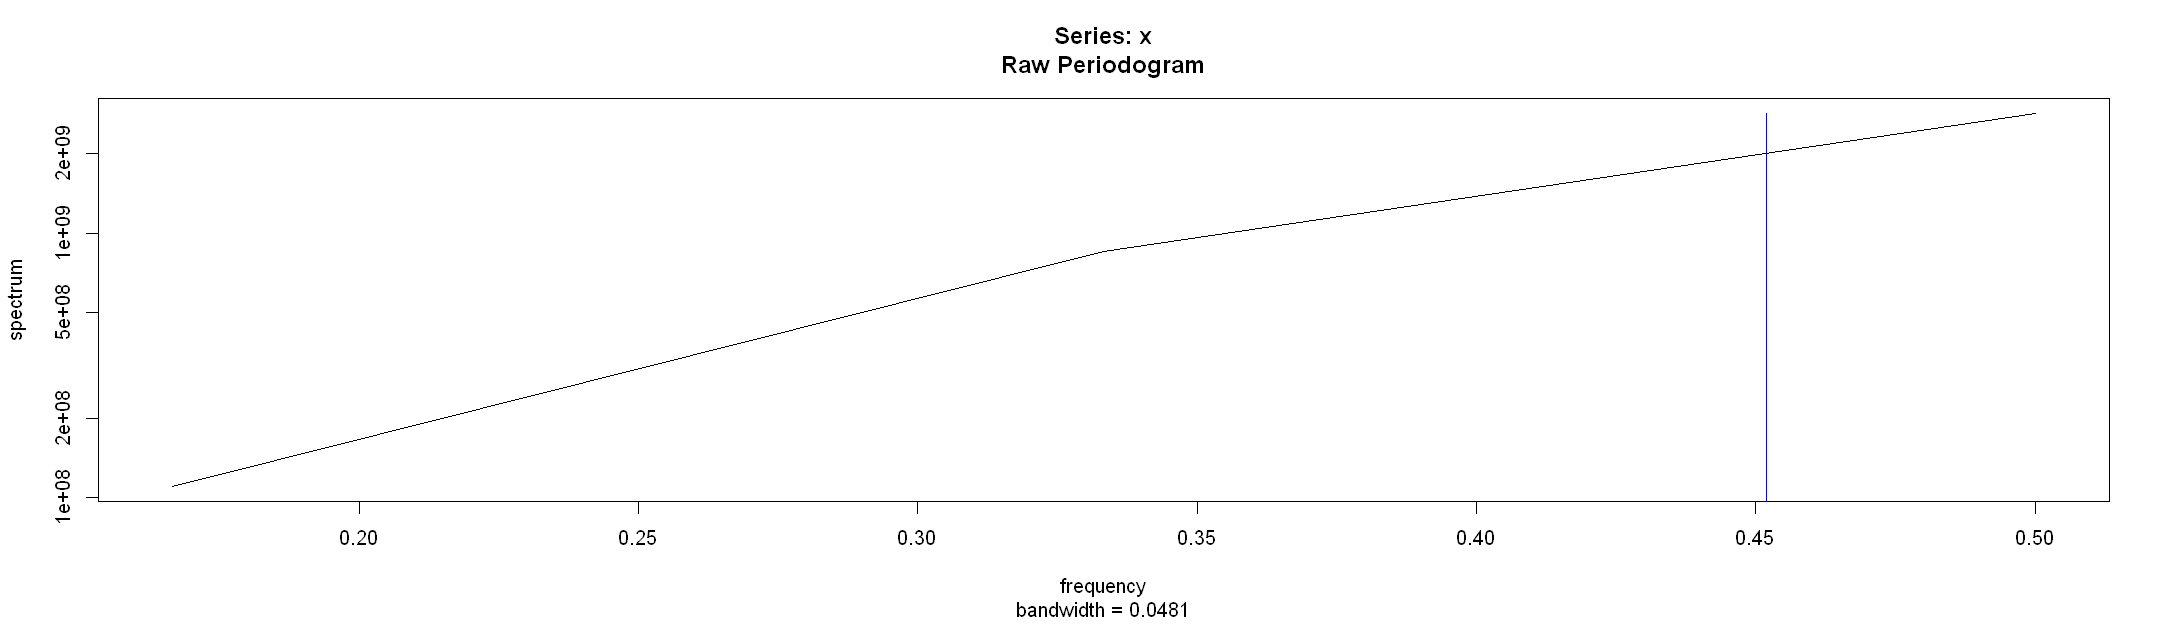


Call:
lm(formula = ICC ~ sin(2 * pi/per * as.integer(as.Date(Date))) + 
    cos(2 * pi/per * as.integer(as.Date(Date))) + sin(4 * pi/per * 
    as.integer(as.Date(Date))) + cos(4 * pi/per * as.integer(as.Date(Date))))

Residuals:
      1       2       3       4       5       6 
-7775.6  1141.7  6000.2 -1895.3   753.6  1775.4 

Coefficients: (1 not defined because of singularities)
                                             Estimate Std. Error t value
(Intercept)                                 8.500e+04  1.150e+04   7.391
sin(2 * pi/per * as.integer(as.Date(Date))) 1.560e+14  3.310e+15   0.047
cos(2 * pi/per * as.integer(as.Date(Date))) 2.667e+02  1.150e+04   0.023
sin(4 * pi/per * as.integer(as.Date(Date))) 7.798e+15  1.655e+15   4.712
cos(4 * pi/per * as.integer(as.Date(Date)))        NA         NA      NA
                                            Pr(>|t|)  
(Intercept)                                   0.0178 *
sin(2 * pi/per * as.integer(as.Date(Date)))   0.9667  
cos(2 * pi/p

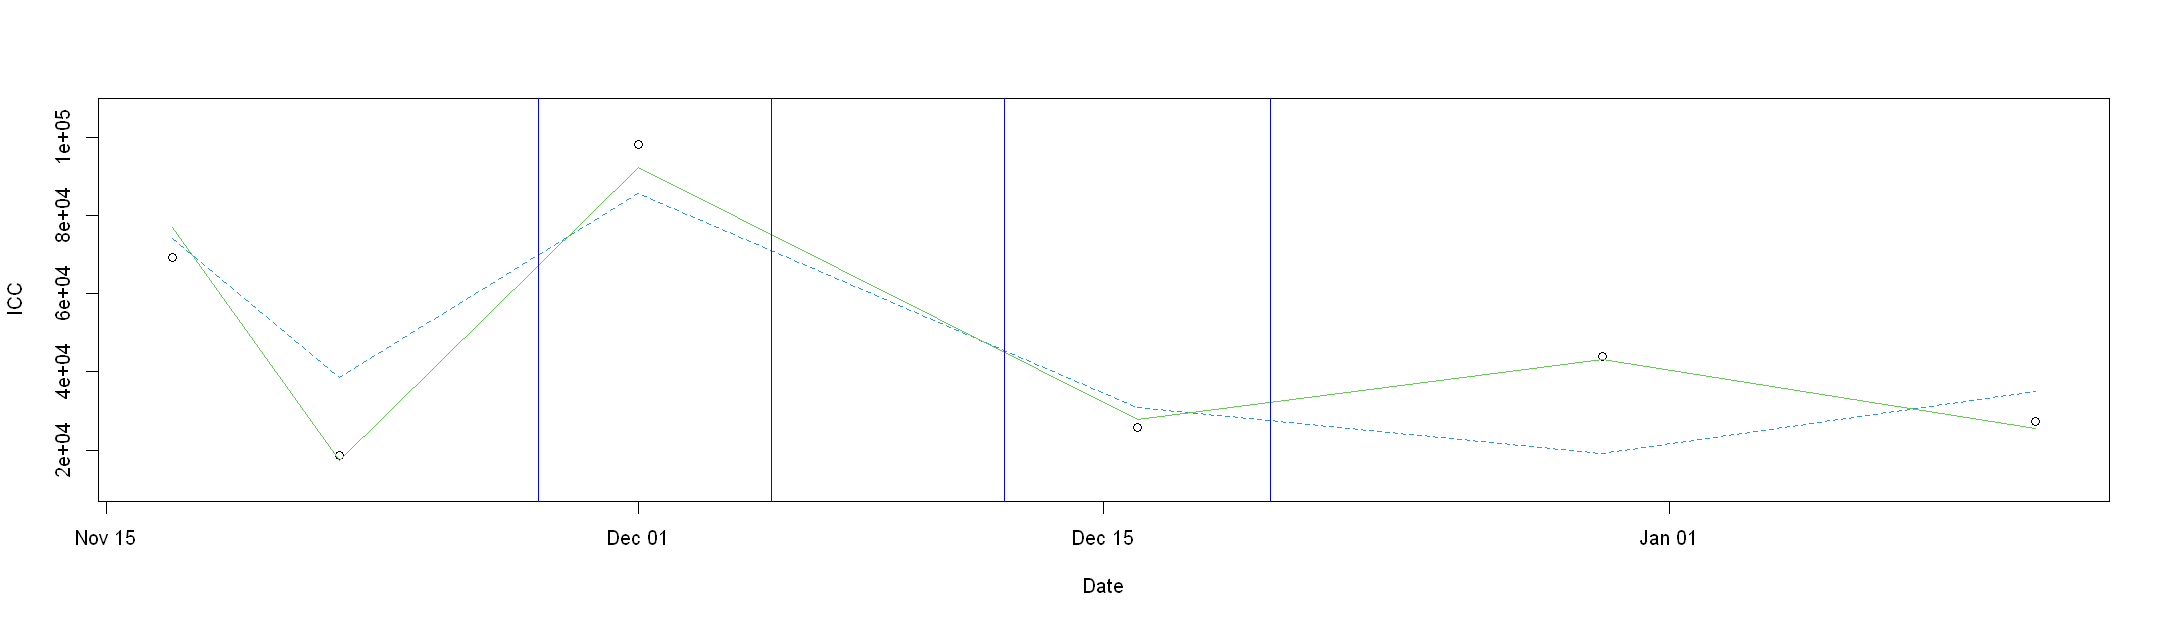

In [571]:
Data <- FCM_mean  %>% filter(Stain == 'SG') %>% filter(Treatment == "BAC" & phase =='2' )
Date <- Data$Date 
ICC <- Data$geomean_blanked

ssp <- spectrum(ICC)  
per <- 1/ssp$freq[ssp$spec==max(ssp$spec)]
per
#per <- mean(diff(as.integer(as.Date(replaced_new))))
per
reslm <- lm(ICC ~ sin(2*pi/per*as.integer(as.Date(Date)))+cos(2*pi/per*as.integer(as.Date(Date))))
summary(reslm)

rg <- diff(range(ICC))
plot(ICC~Date,ylim=c(min(ICC)-0.1*rg,max(ICC)+0.1*rg))
lines(fitted(reslm)~Date,col=4,lty=2)   # dashed blue line is sin fit

# including 2nd harmonic really improves the fit
reslm2 <- lm(ICC ~ sin(2*pi/per*as.integer(as.Date(Date)))+cos(2*pi/per*as.integer(as.Date(Date)))+sin(4*pi/per*as.integer(as.Date(Date)))+cos(4*pi/per*as.integer(as.Date(Date))))
summary(reslm2)
lines(fitted(reslm2)~Date,col=3)  # solid green line is periodic with second harmonic
abline(v=as.integer(as.Date(replaced_new)), col="blue") 

ICC, ATW, ARs Bulk - replace new  - Sine fit for second harmonic p<0.05


ICC and TCC, BFE, Feed- replace new  - Sine fit for first and second harmonic p<0.05

TCC, ICC, BAC media, just 2nd phase

Tap, AR, ICC, Biofilm, phase 2 - replace 2_5 - 1st harmonic



baseline mu before change, find with gompertz
3 sd threshold
if ICC >> mu  region A
if ICC << mu and ATP >> ICC   region B
if OPs  region C

# FCM LOD

In [4]:
Blank_TCC_1 <- LOD_raw[,2:8] %>% filter(Location=='Blank1' | Location=='Blank2' | Location=='Blank3') %>% filter(grepl("7|8|9" , Stain)) %>% select(TCC_density)
#Blank_TCC_2<- ungroup(FCM_new)  %>% filter(samples_type == "Blk", type=='Bulk' ) %>% filter(Stain == 'SG') %>% rename('TCC_density' = geomean )  %>% select(TCC_density)
#Blank_TCC <- rbind(Blank_TCC_1,Blank_TCC_2)
blk_mean_TCC<- mean(Blank_TCC_1$TCC_density)
blk_sd_TCC<- sd(Blank_TCC_1$TCC_density)
LOD_TCC <- blk_mean_TCC + 2 * blk_sd_TCC
LOD_TCC

Blank_ICC_1 <- LOD_raw[,2:8] %>% filter(Location=='Blank1' | Location=='Blank2' | Location=='Blank3') %>% filter(grepl("10|11|12" , Stain)) %>% select(TCC_density)
#Blank_ICC_2<- ungroup(FCM_new)  %>% filter(samples_type == "Blk", type=='Bulk' ) %>% filter(Stain == 'SGPI') %>% rename('TCC_density' = geomean )  %>% select(TCC_density)
#Blank_ICC <- rbind(Blank_ICC_1,Blank_TCC_2)
blk_mean_ICC <- mean(Blank_ICC_1$TCC_density)
blk_sd_ICC <- sd(Blank_ICC_1$TCC_density)
LOD_ICC <- blk_mean_ICC + 2 * blk_sd_ICC
LOD_ICC

evian_TCC<- LOD_raw %>% filter(Location=='1x') %>% filter(grepl("1|2|3" , Stain))
evian_mean_TCC <- mean(evian_TCC$TCC_density)
evian_mean_TCC


evian_ICC<- LOD_raw %>% filter(Location=='1x') %>% filter(grepl("4|5|6" , Stain))
evian_mean_ICC <- mean(evian_ICC$TCC_density)
evian_mean_ICC

[1] 4413.333

[1] 3808.315

[1] 40440

[1] 25760

In [14]:

new_TCC <- data.frame(
  Location = c('100000x','10000x','1000x', '100x','10x','5x','2x','1x', 'Blank1','Blank2','Blank3'),
  conc = c(evian_mean_TCC*0.00001-blk_mean_TCC, evian_mean_TCC*0.0001-blk_mean_TCC,evian_mean_TCC*0.001-blk_mean_TCC,evian_mean_TCC*0.01-blk_mean_TCC,evian_mean_TCC*0.1-blk_mean_TCC,evian_mean_TCC*0.2-blk_mean_TCC,evian_mean_TCC*0.5-blk_mean_TCC,evian_mean_TCC-blk_mean_TCC,0,0,0)
)

new_ICC <- data.frame(
  Location = c('100000x','10000x','1000x', '100x','10x','5x','2x','1x', 'Blank1','Blank2','Blank3'),
  conc = c(evian_mean_ICC*0.00001-blk_mean_ICC, evian_mean_ICC*0.0001-blk_mean_ICC,evian_mean_ICC*0.001-blk_mean_ICC,evian_mean_ICC*0.01-blk_mean_ICC,evian_mean_ICC*0.1-blk_mean_ICC,evian_mean_ICC*0.2-blk_mean_ICC,evian_mean_ICC*0.5-blk_mean_ICC,evian_mean_ICC-blk_mean_ICC,0,0,0)
)

In [15]:
updated_TCC <- LOD_raw[1:66,] %>%
  left_join(new_TCC, by = "Location") 

updated_ICC <- LOD_raw[1:66,] %>%
  left_join(new_ICC, by = "Location") 


In [16]:
ICC_LOD <- updated_ICC %>% filter(grepl("4|5|6|10|11|12" , Stain))
TCC_LOD <- updated_TCC %>% filter(grepl("1|2|3|7|8|9" , Stain))

In [17]:

calibration_model <- lm(TCC_density ~ conc, data = ICC_LOD)
summary(calibration_model)

residuals <- calibration_model$residuals
sd_residuals <- sd(residuals)
print(sd_residuals)


Call:
lm(formula = TCC_density ~ conc, data = ICC_LOD)

Residuals:
     Min       1Q   Median       3Q      Max 
-3152.79  -812.79    50.72   591.03  3089.25 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.729e+03  2.091e+02   17.84   <2e-16 ***
conc        9.986e-01  2.689e-02   37.13   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1151 on 31 degrees of freedom
Multiple R-squared:  0.978,	Adjusted R-squared:  0.9773 
F-statistic:  1379 on 1 and 31 DF,  p-value: < 2.2e-16


[1] 1133.107


In [22]:
 3*1133.107/ 9.986e-01          

I_LoD <- 2*blk_sd_ICC/ 9.986e-01         
I_LoD

LOD_ICC


[1] 3404.087

[1] 1025.306

[1] 3808.315

In [19]:

calibration_model <- lm(TCC_density ~ conc, data = TCC_LOD)
summary(calibration_model)

residuals <- calibration_model$residuals
sd_residuals <- sd(residuals)
print(sd_residuals)


Call:
lm(formula = TCC_density ~ conc, data = TCC_LOD)

Residuals:
    Min      1Q  Median      3Q     Max 
-2690.0 -1205.0   406.9  1307.0  3467.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.910e+03  2.672e+02   18.37   <2e-16 ***
conc        9.949e-01  2.444e-02   40.71   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1666 on 40 degrees of freedom
Multiple R-squared:  0.9764,	Adjusted R-squared:  0.9758 
F-statistic:  1657 on 1 and 40 DF,  p-value: < 2.2e-16


[1] 1645.632


In [7]:
Blank_ICC_1

TCC_density
<int>
3780
2460
2520
2740
2540
2220
3500
2680
2620


In [6]:
blk_sd_TCC
blk_sd_ICC

[1] 240

[1] 511.9353

In [23]:
 3*1645.632/9.949e-01       

T_LOD <- 2*blk_sd_TCC/9.949e-01
T_LOD

LOD_TCC

[1] 4962.203

[1] 482.4605

[1] 4413.333

# Rare Analysis

In [3]:
rare_raw

X,Date,Location,Stain,Replicate,NA.,Sample,TCC_count,TCC_density
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,2022-11-08,08-NOV-2022,08-NOV-2022,Counting,H1,08-NOV-2022_08-NOV-2022_08-NOV-2022_Counting_H1,5844,116880
2,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A10,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A10,19,380
3,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A11,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A11,11,220
4,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A12,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A12,8,160
5,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A7,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A7,83,1660
6,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A8,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A8,78,1560
7,2022-11-08,08-NOV-2022,08-NOV-2022,Rare,A9,08-NOV-2022_08-NOV-2022_08-NOV-2022_Rare_A9,77,1540
8,2022-11-08,08-NOV-2022,08-NOV-2022,Raredec,B10,08-NOV-2022_08-NOV-2022_08-NOV-2022_Raredec_B10,242,4840
9,2022-11-08,08-NOV-2022,08-NOV-2022,Raredec,B11,08-NOV-2022_08-NOV-2022_08-NOV-2022_Raredec_B11,239,4780
